In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv2DTranspose, UpSampling2D, Embedding, Concatenate

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

Training Samples and Labels

In [4]:
noise_dim = 100

In [5]:
(trainSamples, trainLabels), (testSamples, testLabels) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [6]:
train_filter = np.where((trainLabels == 2 ) ) 
test_filter = np.where((testLabels == 2) ) 

In [7]:
trainSamples, trainLabels = trainSamples[train_filter], trainLabels[train_filter]
testSamples, testLabels = testSamples[test_filter], testLabels[test_filter]

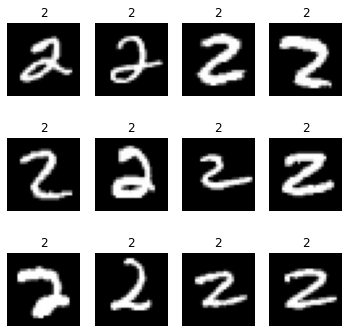

In [8]:
plt.figure(figsize=(6, 6))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(trainSamples[i][:,:],cmap='gray')
    plt.title(trainLabels[i])
    plt.axis("off")

In [9]:
trainSamples.shape

(5958, 28, 28)

Obtaining a Noise Vector with a Generator

In [10]:
def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)) 
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))

    model.summary()
    return model

generator = make_generator_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

Creating Network

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    model.summary()

    return model

discriminator = make_discriminator_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

Loading Samples

In [12]:
def sample_from_dataset(n,samples):
    prev_numbers = []
    new_samples = []
    while len(new_samples)<n:
        number = random.randrange(len(samples))
        if number in prev_numbers: continue
        prev_numbers.append(number)
        new_samples.append(samples[number])
    new_samples = np.array(new_samples,dtype=float)    

    return new_samples

Training the Network

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [14]:
from numpy.random import randn

def calc_ok(vct):
    ok = 0
    for x in vct: 
        if x>=0.5: 
            ok+=1 
    return ok

history = []
def do_step(images):
    batch_size = len(images)
    images = np.array(images)
    input_noise = randn(batch_size * noise_dim)
    input_noise = input_noise.reshape(batch_size, noise_dim)
    input_noise = tf.convert_to_tensor(input_noise)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(input_noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        fake_acc = (batch_size-calc_ok(fake_output))/batch_size
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        
        real_output = discriminator(images, training=True)
        real_acc = calc_ok(real_output)/batch_size
        real_loss = cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss 

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) 
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) 
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    print("Epoch",epoch+4000,'g_loss=',gen_loss.numpy(),'d_loss=',disc_loss.numpy(),"real_acc=",real_acc,"fake_acc=",fake_acc)
    history.append([gen_loss.numpy(),disc_loss.numpy(),real_acc,fake_acc])

Epoch 4000 g_loss= 0.74972534 d_loss= 14.464522 real_acc= 0.06 fake_acc= 0.98


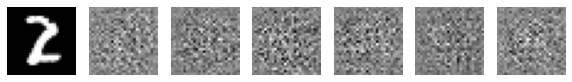

Epoch 4001 g_loss= 0.72193414 d_loss= 8.104653 real_acc= 0.38 fake_acc= 0.82
Epoch 4002 g_loss= 0.6910771 d_loss= 3.0131683 real_acc= 0.7 fake_acc= 0.4
Epoch 4003 g_loss= 0.66537505 d_loss= 1.1582742 real_acc= 0.88 fake_acc= 0.12
Epoch 4004 g_loss= 0.64318305 d_loss= 0.90531707 real_acc= 0.96 fake_acc= 0.02
Epoch 4005 g_loss= 0.6322009 d_loss= 0.8107917 real_acc= 0.96 fake_acc= 0.0
Epoch 4006 g_loss= 0.61560273 d_loss= 0.77775663 real_acc= 1.0 fake_acc= 0.0
Epoch 4007 g_loss= 0.60592204 d_loss= 0.7892347 real_acc= 1.0 fake_acc= 0.0
Epoch 4008 g_loss= 0.5933489 d_loss= 0.804599 real_acc= 1.0 fake_acc= 0.0
Epoch 4009 g_loss= 0.5869075 d_loss= 0.8127773 real_acc= 1.0 fake_acc= 0.0
Epoch 4010 g_loss= 0.57237154 d_loss= 0.83131987 real_acc= 1.0 fake_acc= 0.0


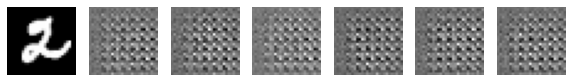

Epoch 4011 g_loss= 0.56843114 d_loss= 0.836358 real_acc= 1.0 fake_acc= 0.0
Epoch 4012 g_loss= 0.5599161 d_loss= 0.84780335 real_acc= 1.0 fake_acc= 0.0
Epoch 4013 g_loss= 0.555349 d_loss= 0.8539156 real_acc= 1.0 fake_acc= 0.0
Epoch 4014 g_loss= 0.54069114 d_loss= 0.8737474 real_acc= 1.0 fake_acc= 0.0
Epoch 4015 g_loss= 0.540786 d_loss= 0.87377405 real_acc= 1.0 fake_acc= 0.0
Epoch 4016 g_loss= 0.52536964 d_loss= 0.8955563 real_acc= 1.0 fake_acc= 0.0
Epoch 4017 g_loss= 0.52759254 d_loss= 0.89226884 real_acc= 1.0 fake_acc= 0.0
Epoch 4018 g_loss= 0.51769805 d_loss= 0.90707624 real_acc= 1.0 fake_acc= 0.0
Epoch 4019 g_loss= 0.51724094 d_loss= 0.90763503 real_acc= 1.0 fake_acc= 0.0
Epoch 4020 g_loss= 0.5169537 d_loss= 0.90809 real_acc= 1.0 fake_acc= 0.0


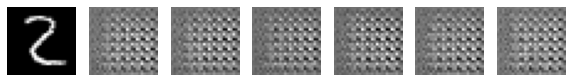

Epoch 4021 g_loss= 0.50403136 d_loss= 0.9272647 real_acc= 1.0 fake_acc= 0.0
Epoch 4022 g_loss= 0.51210105 d_loss= 0.91551393 real_acc= 1.0 fake_acc= 0.0
Epoch 4023 g_loss= 0.50344473 d_loss= 0.9281481 real_acc= 1.0 fake_acc= 0.0
Epoch 4024 g_loss= 0.50147325 d_loss= 0.9314911 real_acc= 1.0 fake_acc= 0.0
Epoch 4025 g_loss= 0.4998089 d_loss= 0.9340019 real_acc= 1.0 fake_acc= 0.0
Epoch 4026 g_loss= 0.49808282 d_loss= 0.9366074 real_acc= 1.0 fake_acc= 0.0
Epoch 4027 g_loss= 0.4971481 d_loss= 0.9380935 real_acc= 1.0 fake_acc= 0.0
Epoch 4028 g_loss= 0.49987334 d_loss= 0.9344734 real_acc= 1.0 fake_acc= 0.0
Epoch 4029 g_loss= 0.49732465 d_loss= 0.93823427 real_acc= 1.0 fake_acc= 0.0
Epoch 4030 g_loss= 0.49300304 d_loss= 0.9443594 real_acc= 1.0 fake_acc= 0.0


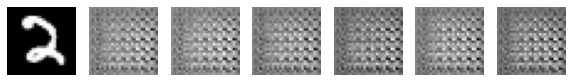

Epoch 4031 g_loss= 0.501508 d_loss= 0.931627 real_acc= 1.0 fake_acc= 0.0
Epoch 4032 g_loss= 0.49220362 d_loss= 0.94617003 real_acc= 1.0 fake_acc= 0.0
Epoch 4033 g_loss= 0.49498078 d_loss= 0.94141585 real_acc= 1.0 fake_acc= 0.0
Epoch 4034 g_loss= 0.48962674 d_loss= 0.9500458 real_acc= 1.0 fake_acc= 0.0
Epoch 4035 g_loss= 0.4982312 d_loss= 0.9361008 real_acc= 1.0 fake_acc= 0.0
Epoch 4036 g_loss= 0.4952662 d_loss= 0.94116265 real_acc= 1.0 fake_acc= 0.0
Epoch 4037 g_loss= 0.4942898 d_loss= 0.9426202 real_acc= 1.0 fake_acc= 0.0
Epoch 4038 g_loss= 0.49630192 d_loss= 0.9394273 real_acc= 1.0 fake_acc= 0.0
Epoch 4039 g_loss= 0.50159717 d_loss= 0.93172437 real_acc= 1.0 fake_acc= 0.0
Epoch 4040 g_loss= 0.49820164 d_loss= 0.93656695 real_acc= 1.0 fake_acc= 0.0


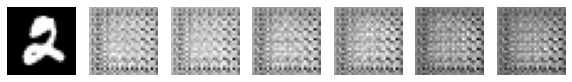

Epoch 4041 g_loss= 0.49283004 d_loss= 0.9452491 real_acc= 1.0 fake_acc= 0.0
Epoch 4042 g_loss= 0.49387515 d_loss= 0.94329435 real_acc= 1.0 fake_acc= 0.0
Epoch 4043 g_loss= 0.5008992 d_loss= 0.93208003 real_acc= 1.0 fake_acc= 0.0
Epoch 4044 g_loss= 0.505958 d_loss= 0.9248162 real_acc= 1.0 fake_acc= 0.0
Epoch 4045 g_loss= 0.4970838 d_loss= 0.9382676 real_acc= 1.0 fake_acc= 0.0
Epoch 4046 g_loss= 0.49996132 d_loss= 0.93427294 real_acc= 1.0 fake_acc= 0.0
Epoch 4047 g_loss= 0.4983822 d_loss= 0.936223 real_acc= 1.0 fake_acc= 0.0
Epoch 4048 g_loss= 0.5000296 d_loss= 0.93371165 real_acc= 1.0 fake_acc= 0.0
Epoch 4049 g_loss= 0.50500154 d_loss= 0.9262859 real_acc= 1.0 fake_acc= 0.0
Epoch 4050 g_loss= 0.51325655 d_loss= 0.91375875 real_acc= 1.0 fake_acc= 0.0


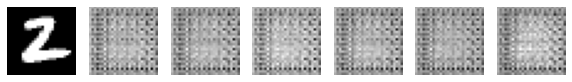

Epoch 4051 g_loss= 0.50975907 d_loss= 0.9186744 real_acc= 1.0 fake_acc= 0.0
Epoch 4052 g_loss= 0.5151282 d_loss= 0.91075426 real_acc= 1.0 fake_acc= 0.0
Epoch 4053 g_loss= 0.5154508 d_loss= 0.9106002 real_acc= 1.0 fake_acc= 0.0
Epoch 4054 g_loss= 0.51017123 d_loss= 0.91815805 real_acc= 1.0 fake_acc= 0.0
Epoch 4055 g_loss= 0.5167664 d_loss= 0.9083884 real_acc= 1.0 fake_acc= 0.0
Epoch 4056 g_loss= 0.50833267 d_loss= 0.9209884 real_acc= 1.0 fake_acc= 0.0
Epoch 4057 g_loss= 0.5211719 d_loss= 0.90190995 real_acc= 1.0 fake_acc= 0.0
Epoch 4058 g_loss= 0.5211041 d_loss= 0.901896 real_acc= 1.0 fake_acc= 0.0
Epoch 4059 g_loss= 0.5157315 d_loss= 0.9100437 real_acc= 1.0 fake_acc= 0.0
Epoch 4060 g_loss= 0.52463144 d_loss= 0.8968922 real_acc= 1.0 fake_acc= 0.0


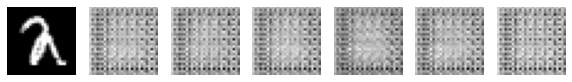

Epoch 4061 g_loss= 0.5229801 d_loss= 0.8992007 real_acc= 1.0 fake_acc= 0.0
Epoch 4062 g_loss= 0.52552116 d_loss= 0.8961508 real_acc= 1.0 fake_acc= 0.0
Epoch 4063 g_loss= 0.531156 d_loss= 0.88739157 real_acc= 1.0 fake_acc= 0.0
Epoch 4064 g_loss= 0.52920663 d_loss= 0.89048845 real_acc= 1.0 fake_acc= 0.0
Epoch 4065 g_loss= 0.53610706 d_loss= 0.88047963 real_acc= 1.0 fake_acc= 0.0
Epoch 4066 g_loss= 0.538898 d_loss= 0.87667704 real_acc= 1.0 fake_acc= 0.0
Epoch 4067 g_loss= 0.53527546 d_loss= 0.88158 real_acc= 1.0 fake_acc= 0.0
Epoch 4068 g_loss= 0.5366081 d_loss= 0.87977684 real_acc= 1.0 fake_acc= 0.0
Epoch 4069 g_loss= 0.5390473 d_loss= 0.87614596 real_acc= 1.0 fake_acc= 0.0
Epoch 4070 g_loss= 0.547753 d_loss= 0.8643026 real_acc= 1.0 fake_acc= 0.0


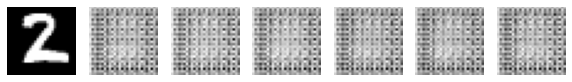

Epoch 4071 g_loss= 0.54689497 d_loss= 0.86537695 real_acc= 1.0 fake_acc= 0.0
Epoch 4072 g_loss= 0.5483393 d_loss= 0.8635926 real_acc= 1.0 fake_acc= 0.0
Epoch 4073 g_loss= 0.55193144 d_loss= 0.858762 real_acc= 1.0 fake_acc= 0.0
Epoch 4074 g_loss= 0.5546014 d_loss= 0.85489035 real_acc= 1.0 fake_acc= 0.0
Epoch 4075 g_loss= 0.55270314 d_loss= 0.8575103 real_acc= 1.0 fake_acc= 0.0
Epoch 4076 g_loss= 0.5591945 d_loss= 0.84872836 real_acc= 1.0 fake_acc= 0.0
Epoch 4077 g_loss= 0.5590633 d_loss= 0.8487716 real_acc= 1.0 fake_acc= 0.0
Epoch 4078 g_loss= 0.5584373 d_loss= 0.8498879 real_acc= 1.0 fake_acc= 0.0
Epoch 4079 g_loss= 0.5618798 d_loss= 0.84516215 real_acc= 1.0 fake_acc= 0.0
Epoch 4080 g_loss= 0.5592998 d_loss= 0.8488267 real_acc= 1.0 fake_acc= 0.0


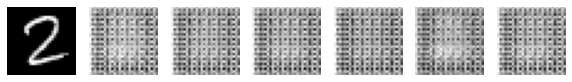

Epoch 4081 g_loss= 0.5705984 d_loss= 0.8336113 real_acc= 1.0 fake_acc= 0.0
Epoch 4082 g_loss= 0.5741275 d_loss= 0.82892853 real_acc= 1.0 fake_acc= 0.0
Epoch 4083 g_loss= 0.56925863 d_loss= 0.83549356 real_acc= 1.0 fake_acc= 0.0
Epoch 4084 g_loss= 0.5760622 d_loss= 0.8265901 real_acc= 1.0 fake_acc= 0.0
Epoch 4085 g_loss= 0.5771128 d_loss= 0.82515836 real_acc= 1.0 fake_acc= 0.0
Epoch 4086 g_loss= 0.5735168 d_loss= 0.82998854 real_acc= 1.0 fake_acc= 0.0
Epoch 4087 g_loss= 0.57894784 d_loss= 0.822928 real_acc= 1.0 fake_acc= 0.0
Epoch 4088 g_loss= 0.5766819 d_loss= 0.8257634 real_acc= 1.0 fake_acc= 0.0
Epoch 4089 g_loss= 0.5843023 d_loss= 0.81597346 real_acc= 1.0 fake_acc= 0.0
Epoch 4090 g_loss= 0.5819781 d_loss= 0.81892866 real_acc= 1.0 fake_acc= 0.0


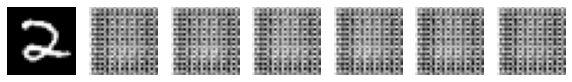

Epoch 4091 g_loss= 0.58520424 d_loss= 0.81476516 real_acc= 1.0 fake_acc= 0.0
Epoch 4092 g_loss= 0.590906 d_loss= 0.8079257 real_acc= 1.0 fake_acc= 0.0
Epoch 4093 g_loss= 0.5887579 d_loss= 0.8105496 real_acc= 1.0 fake_acc= 0.0
Epoch 4094 g_loss= 0.58419883 d_loss= 0.8163959 real_acc= 1.0 fake_acc= 0.0
Epoch 4095 g_loss= 0.593735 d_loss= 0.8040433 real_acc= 1.0 fake_acc= 0.0
Epoch 4096 g_loss= 0.59628415 d_loss= 0.8011205 real_acc= 1.0 fake_acc= 0.0
Epoch 4097 g_loss= 0.5929919 d_loss= 0.80520153 real_acc= 1.0 fake_acc= 0.0
Epoch 4098 g_loss= 0.59821045 d_loss= 0.79876417 real_acc= 1.0 fake_acc= 0.0
Epoch 4099 g_loss= 0.59753776 d_loss= 0.7994417 real_acc= 1.0 fake_acc= 0.0
Epoch 4100 g_loss= 0.59742415 d_loss= 0.79941523 real_acc= 1.0 fake_acc= 0.0


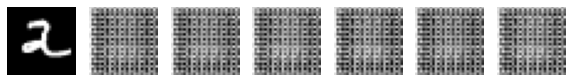

Epoch 4101 g_loss= 0.60452455 d_loss= 0.79114527 real_acc= 1.0 fake_acc= 0.02
Epoch 4102 g_loss= 0.60213906 d_loss= 0.79393846 real_acc= 1.0 fake_acc= 0.0
Epoch 4103 g_loss= 0.6038381 d_loss= 0.79197764 real_acc= 1.0 fake_acc= 0.0
Epoch 4104 g_loss= 0.6078402 d_loss= 0.7869387 real_acc= 1.0 fake_acc= 0.0
Epoch 4105 g_loss= 0.6065416 d_loss= 0.7886113 real_acc= 1.0 fake_acc= 0.0
Epoch 4106 g_loss= 0.61259156 d_loss= 0.781368 real_acc= 1.0 fake_acc= 0.0
Epoch 4107 g_loss= 0.60564804 d_loss= 0.7898446 real_acc= 1.0 fake_acc= 0.0
Epoch 4108 g_loss= 0.61608624 d_loss= 0.7775156 real_acc= 1.0 fake_acc= 0.0
Epoch 4109 g_loss= 0.6171667 d_loss= 0.7760651 real_acc= 1.0 fake_acc= 0.0
Epoch 4110 g_loss= 0.61804044 d_loss= 0.77506995 real_acc= 1.0 fake_acc= 0.0


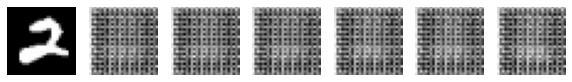

Epoch 4111 g_loss= 0.6189232 d_loss= 0.7740109 real_acc= 1.0 fake_acc= 0.0
Epoch 4112 g_loss= 0.6192123 d_loss= 0.7734934 real_acc= 1.0 fake_acc= 0.0
Epoch 4113 g_loss= 0.6259494 d_loss= 0.7660399 real_acc= 1.0 fake_acc= 0.0
Epoch 4114 g_loss= 0.62698376 d_loss= 0.7646037 real_acc= 1.0 fake_acc= 0.0
Epoch 4115 g_loss= 0.6287585 d_loss= 0.7628441 real_acc= 1.0 fake_acc= 0.0
Epoch 4116 g_loss= 0.6258344 d_loss= 0.76620066 real_acc= 1.0 fake_acc= 0.0
Epoch 4117 g_loss= 0.63155127 d_loss= 0.759383 real_acc= 1.0 fake_acc= 0.0
Epoch 4118 g_loss= 0.63153327 d_loss= 0.7594856 real_acc= 1.0 fake_acc= 0.0
Epoch 4119 g_loss= 0.6344832 d_loss= 0.7561249 real_acc= 1.0 fake_acc= 0.0
Epoch 4120 g_loss= 0.63599944 d_loss= 0.75432074 real_acc= 1.0 fake_acc= 0.04


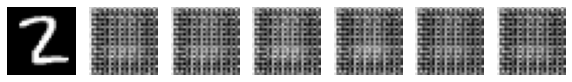

Epoch 4121 g_loss= 0.6385615 d_loss= 0.75141317 real_acc= 1.0 fake_acc= 0.0
Epoch 4122 g_loss= 0.64123064 d_loss= 0.7484161 real_acc= 1.0 fake_acc= 0.0
Epoch 4123 g_loss= 0.64150995 d_loss= 0.74840385 real_acc= 1.0 fake_acc= 0.04
Epoch 4124 g_loss= 0.63853204 d_loss= 0.75161225 real_acc= 1.0 fake_acc= 0.02
Epoch 4125 g_loss= 0.6477545 d_loss= 0.7414695 real_acc= 1.0 fake_acc= 0.08
Epoch 4126 g_loss= 0.6493291 d_loss= 0.7397403 real_acc= 1.0 fake_acc= 0.04
Epoch 4127 g_loss= 0.6497882 d_loss= 0.7389412 real_acc= 1.0 fake_acc= 0.0
Epoch 4128 g_loss= 0.6459661 d_loss= 0.74963546 real_acc= 1.0 fake_acc= 0.02
Epoch 4129 g_loss= 0.6520514 d_loss= 0.7365703 real_acc= 1.0 fake_acc= 0.04
Epoch 4130 g_loss= 0.6541686 d_loss= 0.73413676 real_acc= 1.0 fake_acc= 0.02


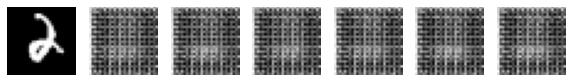

Epoch 4131 g_loss= 0.6586479 d_loss= 0.72950655 real_acc= 1.0 fake_acc= 0.06
Epoch 4132 g_loss= 0.6569349 d_loss= 0.7313078 real_acc= 1.0 fake_acc= 0.08
Epoch 4133 g_loss= 0.6582418 d_loss= 0.73000205 real_acc= 1.0 fake_acc= 0.08
Epoch 4134 g_loss= 0.6618666 d_loss= 0.72573763 real_acc= 1.0 fake_acc= 0.02
Epoch 4135 g_loss= 0.65755117 d_loss= 0.73066723 real_acc= 1.0 fake_acc= 0.02
Epoch 4136 g_loss= 0.6664563 d_loss= 0.72123474 real_acc= 1.0 fake_acc= 0.14
Epoch 4137 g_loss= 0.66195273 d_loss= 0.72609264 real_acc= 1.0 fake_acc= 0.08
Epoch 4138 g_loss= 0.66369975 d_loss= 0.72404474 real_acc= 1.0 fake_acc= 0.06
Epoch 4139 g_loss= 0.6659617 d_loss= 0.72171015 real_acc= 1.0 fake_acc= 0.12
Epoch 4140 g_loss= 0.66735274 d_loss= 0.75250983 real_acc= 0.98 fake_acc= 0.1


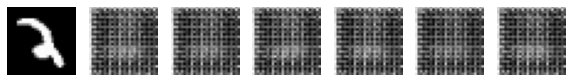

Epoch 4141 g_loss= 0.67467874 d_loss= 0.7124558 real_acc= 1.0 fake_acc= 0.2
Epoch 4142 g_loss= 0.669488 d_loss= 0.7177579 real_acc= 1.0 fake_acc= 0.06
Epoch 4143 g_loss= 0.6701221 d_loss= 0.71738464 real_acc= 1.0 fake_acc= 0.26
Epoch 4144 g_loss= 0.6747249 d_loss= 0.7125585 real_acc= 1.0 fake_acc= 0.24
Epoch 4145 g_loss= 0.67844063 d_loss= 0.7086203 real_acc= 1.0 fake_acc= 0.28
Epoch 4146 g_loss= 0.67323214 d_loss= 0.71382415 real_acc= 1.0 fake_acc= 0.1
Epoch 4147 g_loss= 0.6789993 d_loss= 0.7079846 real_acc= 1.0 fake_acc= 0.28
Epoch 4148 g_loss= 0.68037933 d_loss= 0.70641524 real_acc= 1.0 fake_acc= 0.24
Epoch 4149 g_loss= 0.683537 d_loss= 0.70337176 real_acc= 1.0 fake_acc= 0.34
Epoch 4150 g_loss= 0.6821295 d_loss= 0.7048673 real_acc= 1.0 fake_acc= 0.26


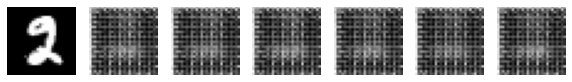

Epoch 4151 g_loss= 0.67882293 d_loss= 0.7083403 real_acc= 1.0 fake_acc= 0.38
Epoch 4152 g_loss= 0.68871653 d_loss= 0.70056236 real_acc= 1.0 fake_acc= 0.44
Epoch 4153 g_loss= 0.6955679 d_loss= 0.69311017 real_acc= 1.0 fake_acc= 0.52
Epoch 4154 g_loss= 0.690028 d_loss= 0.6967375 real_acc= 1.0 fake_acc= 0.46
Epoch 4155 g_loss= 0.6964958 d_loss= 0.77311397 real_acc= 0.98 fake_acc= 0.56
Epoch 4156 g_loss= 0.68836546 d_loss= 0.6983394 real_acc= 1.0 fake_acc= 0.4
Epoch 4157 g_loss= 0.6919218 d_loss= 0.7122406 real_acc= 0.98 fake_acc= 0.44
Epoch 4158 g_loss= 0.69491065 d_loss= 0.6918088 real_acc= 1.0 fake_acc= 0.58
Epoch 4159 g_loss= 0.6953746 d_loss= 0.69141334 real_acc= 1.0 fake_acc= 0.56
Epoch 4160 g_loss= 0.6940115 d_loss= 0.6927682 real_acc= 1.0 fake_acc= 0.48


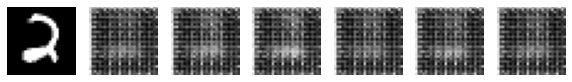

Epoch 4161 g_loss= 0.70083237 d_loss= 0.69133466 real_acc= 1.0 fake_acc= 0.76
Epoch 4162 g_loss= 0.69821244 d_loss= 0.6887033 real_acc= 1.0 fake_acc= 0.6
Epoch 4163 g_loss= 0.6980379 d_loss= 0.6890347 real_acc= 1.0 fake_acc= 0.56
Epoch 4164 g_loss= 0.699621 d_loss= 0.68722296 real_acc= 1.0 fake_acc= 0.64
Epoch 4165 g_loss= 0.69845283 d_loss= 0.69060135 real_acc= 1.0 fake_acc= 0.6
Epoch 4166 g_loss= 0.70759475 d_loss= 0.67950296 real_acc= 1.0 fake_acc= 0.7
Epoch 4167 g_loss= 0.7069217 d_loss= 0.6799287 real_acc= 1.0 fake_acc= 0.78
Epoch 4168 g_loss= 0.70435256 d_loss= 0.6825822 real_acc= 1.0 fake_acc= 0.68
Epoch 4169 g_loss= 0.70923865 d_loss= 0.67777 real_acc= 1.0 fake_acc= 0.82
Epoch 4170 g_loss= 0.71194357 d_loss= 0.6751407 real_acc= 1.0 fake_acc= 0.78


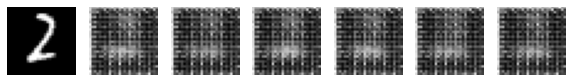

Epoch 4171 g_loss= 0.7154085 d_loss= 0.6768137 real_acc= 1.0 fake_acc= 0.82
Epoch 4172 g_loss= 0.72016466 d_loss= 0.7614351 real_acc= 0.98 fake_acc= 0.86
Epoch 4173 g_loss= 0.72044545 d_loss= 0.6762538 real_acc= 1.0 fake_acc= 0.84
Epoch 4174 g_loss= 0.7188486 d_loss= 0.66871464 real_acc= 1.0 fake_acc= 0.84
Epoch 4175 g_loss= 0.7217502 d_loss= 0.6661499 real_acc= 1.0 fake_acc= 0.82
Epoch 4176 g_loss= 0.72495055 d_loss= 0.9037344 real_acc= 0.98 fake_acc= 0.88
Epoch 4177 g_loss= 0.7190941 d_loss= 0.66864794 real_acc= 1.0 fake_acc= 0.84
Epoch 4178 g_loss= 0.7261407 d_loss= 0.66359663 real_acc= 1.0 fake_acc= 0.88
Epoch 4179 g_loss= 0.7207314 d_loss= 0.66672295 real_acc= 1.0 fake_acc= 0.92
Epoch 4180 g_loss= 0.7226084 d_loss= 0.6670836 real_acc= 1.0 fake_acc= 0.86


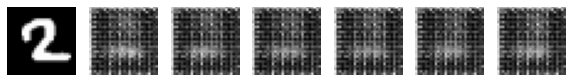

Epoch 4181 g_loss= 0.7251023 d_loss= 0.66276586 real_acc= 1.0 fake_acc= 0.94
Epoch 4182 g_loss= 0.72556216 d_loss= 0.6657081 real_acc= 1.0 fake_acc= 0.98
Epoch 4183 g_loss= 0.7244862 d_loss= 0.66339964 real_acc= 1.0 fake_acc= 0.88
Epoch 4184 g_loss= 0.7266466 d_loss= 0.82698435 real_acc= 0.98 fake_acc= 0.94
Epoch 4185 g_loss= 0.7274461 d_loss= 0.66032654 real_acc= 1.0 fake_acc= 0.92
Epoch 4186 g_loss= 0.7314895 d_loss= 0.6765857 real_acc= 1.0 fake_acc= 0.96
Epoch 4187 g_loss= 0.7325696 d_loss= 0.65577006 real_acc= 1.0 fake_acc= 0.96
Epoch 4188 g_loss= 0.7283203 d_loss= 0.7309526 real_acc= 0.98 fake_acc= 0.94
Epoch 4189 g_loss= 0.72455305 d_loss= 0.6632102 real_acc= 1.0 fake_acc= 0.96
Epoch 4190 g_loss= 0.7353781 d_loss= 0.65390044 real_acc= 1.0 fake_acc= 0.94


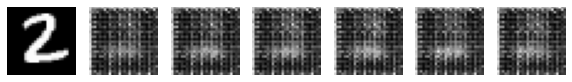

Epoch 4191 g_loss= 0.7342264 d_loss= 0.66654634 real_acc= 1.0 fake_acc= 0.92
Epoch 4192 g_loss= 0.73613966 d_loss= 0.6523976 real_acc= 1.0 fake_acc= 1.0
Epoch 4193 g_loss= 0.72959036 d_loss= 0.6583254 real_acc= 1.0 fake_acc= 0.96
Epoch 4194 g_loss= 0.7409908 d_loss= 0.64793074 real_acc= 1.0 fake_acc= 1.0
Epoch 4195 g_loss= 0.7360869 d_loss= 0.6523598 real_acc= 1.0 fake_acc= 0.96
Epoch 4196 g_loss= 0.74051553 d_loss= 0.64841396 real_acc= 1.0 fake_acc= 0.98
Epoch 4197 g_loss= 0.7436856 d_loss= 0.645657 real_acc= 1.0 fake_acc= 0.98
Epoch 4198 g_loss= 0.7425225 d_loss= 0.64651144 real_acc= 1.0 fake_acc= 1.0
Epoch 4199 g_loss= 0.7429501 d_loss= 0.6463496 real_acc= 1.0 fake_acc= 1.0
Epoch 4200 g_loss= 0.7449715 d_loss= 0.6443034 real_acc= 1.0 fake_acc= 1.0


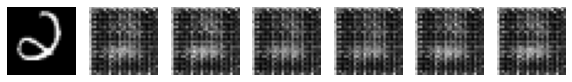

Epoch 4201 g_loss= 0.7480491 d_loss= 0.6414531 real_acc= 1.0 fake_acc= 0.98
Epoch 4202 g_loss= 0.7497807 d_loss= 0.6407476 real_acc= 1.0 fake_acc= 1.0
Epoch 4203 g_loss= 0.7504129 d_loss= 0.6394185 real_acc= 1.0 fake_acc= 1.0
Epoch 4204 g_loss= 0.7551472 d_loss= 0.6351963 real_acc= 1.0 fake_acc= 0.98
Epoch 4205 g_loss= 0.7612433 d_loss= 0.62999266 real_acc= 1.0 fake_acc= 1.0
Epoch 4206 g_loss= 0.76724005 d_loss= 0.6245731 real_acc= 1.0 fake_acc= 1.0
Epoch 4207 g_loss= 0.7688971 d_loss= 0.6235165 real_acc= 1.0 fake_acc= 1.0
Epoch 4208 g_loss= 0.76428485 d_loss= 0.6271914 real_acc= 1.0 fake_acc= 1.0
Epoch 4209 g_loss= 0.7686076 d_loss= 0.62468624 real_acc= 1.0 fake_acc= 1.0
Epoch 4210 g_loss= 0.7705426 d_loss= 0.6218981 real_acc= 1.0 fake_acc= 1.0


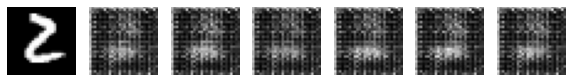

Epoch 4211 g_loss= 0.7761394 d_loss= 0.6170944 real_acc= 1.0 fake_acc= 1.0
Epoch 4212 g_loss= 0.781157 d_loss= 0.6127575 real_acc= 1.0 fake_acc= 1.0
Epoch 4213 g_loss= 0.7831671 d_loss= 0.64186525 real_acc= 0.98 fake_acc= 1.0
Epoch 4214 g_loss= 0.7845228 d_loss= 0.6113336 real_acc= 1.0 fake_acc= 1.0
Epoch 4215 g_loss= 0.7775552 d_loss= 0.6160284 real_acc= 1.0 fake_acc= 1.0
Epoch 4216 g_loss= 0.78343445 d_loss= 0.6766302 real_acc= 0.98 fake_acc= 1.0
Epoch 4217 g_loss= 0.79266024 d_loss= 0.60311425 real_acc= 1.0 fake_acc= 1.0
Epoch 4218 g_loss= 0.7913846 d_loss= 0.6041678 real_acc= 1.0 fake_acc= 1.0
Epoch 4219 g_loss= 0.79170644 d_loss= 0.6071564 real_acc= 1.0 fake_acc= 1.0
Epoch 4220 g_loss= 0.7949848 d_loss= 0.6011883 real_acc= 1.0 fake_acc= 1.0


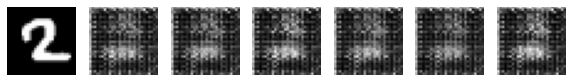

Epoch 4221 g_loss= 0.8034584 d_loss= 0.60545075 real_acc= 1.0 fake_acc= 1.0
Epoch 4222 g_loss= 0.8020682 d_loss= 0.595802 real_acc= 1.0 fake_acc= 1.0
Epoch 4223 g_loss= 0.8028276 d_loss= 0.59479064 real_acc= 1.0 fake_acc= 1.0
Epoch 4224 g_loss= 0.81071997 d_loss= 0.5884662 real_acc= 1.0 fake_acc= 1.0
Epoch 4225 g_loss= 0.8016918 d_loss= 0.5959053 real_acc= 1.0 fake_acc= 1.0
Epoch 4226 g_loss= 0.810493 d_loss= 0.60253847 real_acc= 1.0 fake_acc= 1.0
Epoch 4227 g_loss= 0.8131452 d_loss= 0.58662784 real_acc= 1.0 fake_acc= 1.0
Epoch 4228 g_loss= 0.8155265 d_loss= 0.5846543 real_acc= 1.0 fake_acc= 1.0
Epoch 4229 g_loss= 0.8216312 d_loss= 0.57989216 real_acc= 1.0 fake_acc= 1.0
Epoch 4230 g_loss= 0.82255495 d_loss= 0.5791866 real_acc= 1.0 fake_acc= 1.0


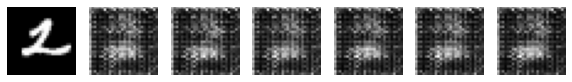

Epoch 4231 g_loss= 0.8270132 d_loss= 0.57549614 real_acc= 1.0 fake_acc= 1.0
Epoch 4232 g_loss= 0.82942337 d_loss= 0.5742719 real_acc= 1.0 fake_acc= 1.0
Epoch 4233 g_loss= 0.8309457 d_loss= 0.5726321 real_acc= 1.0 fake_acc= 1.0
Epoch 4234 g_loss= 0.8386942 d_loss= 0.7216085 real_acc= 0.98 fake_acc= 1.0
Epoch 4235 g_loss= 0.84258986 d_loss= 0.677247 real_acc= 0.96 fake_acc= 1.0
Epoch 4236 g_loss= 0.8355613 d_loss= 0.57730085 real_acc= 1.0 fake_acc= 1.0
Epoch 4237 g_loss= 0.8423718 d_loss= 0.5672089 real_acc= 1.0 fake_acc= 1.0
Epoch 4238 g_loss= 0.8356483 d_loss= 0.5692645 real_acc= 1.0 fake_acc= 1.0
Epoch 4239 g_loss= 0.83768845 d_loss= 0.5671738 real_acc= 1.0 fake_acc= 1.0
Epoch 4240 g_loss= 0.84420043 d_loss= 0.5625478 real_acc= 1.0 fake_acc= 1.0


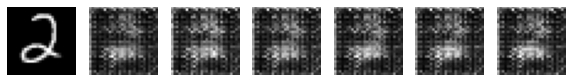

Epoch 4241 g_loss= 0.8420171 d_loss= 0.56426394 real_acc= 1.0 fake_acc= 1.0
Epoch 4242 g_loss= 0.85334235 d_loss= 0.58690643 real_acc= 0.98 fake_acc= 1.0
Epoch 4243 g_loss= 0.8477363 d_loss= 0.82721037 real_acc= 0.98 fake_acc= 1.0
Epoch 4244 g_loss= 0.8451172 d_loss= 0.56176406 real_acc= 1.0 fake_acc= 1.0
Epoch 4245 g_loss= 0.8475489 d_loss= 0.61021566 real_acc= 0.98 fake_acc= 1.0
Epoch 4246 g_loss= 0.8459578 d_loss= 0.56106347 real_acc= 1.0 fake_acc= 1.0
Epoch 4247 g_loss= 0.84203506 d_loss= 0.5643503 real_acc= 1.0 fake_acc= 1.0
Epoch 4248 g_loss= 0.8537023 d_loss= 0.55551326 real_acc= 1.0 fake_acc= 1.0
Epoch 4249 g_loss= 0.85525 d_loss= 0.5542635 real_acc= 1.0 fake_acc= 1.0
Epoch 4250 g_loss= 0.8530238 d_loss= 0.55624545 real_acc= 1.0 fake_acc= 1.0


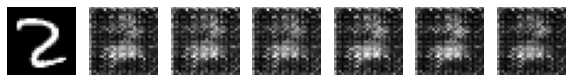

Epoch 4251 g_loss= 0.84405845 d_loss= 0.6713009 real_acc= 0.96 fake_acc= 1.0
Epoch 4252 g_loss= 0.857077 d_loss= 0.5528676 real_acc= 1.0 fake_acc= 1.0
Epoch 4253 g_loss= 0.8591565 d_loss= 0.5521253 real_acc= 1.0 fake_acc= 1.0
Epoch 4254 g_loss= 0.86217654 d_loss= 0.5490518 real_acc= 1.0 fake_acc= 1.0
Epoch 4255 g_loss= 0.85516053 d_loss= 0.55416113 real_acc= 1.0 fake_acc= 1.0
Epoch 4256 g_loss= 0.85425156 d_loss= 0.55485374 real_acc= 1.0 fake_acc= 1.0
Epoch 4257 g_loss= 0.86090547 d_loss= 0.54996204 real_acc= 1.0 fake_acc= 1.0
Epoch 4258 g_loss= 0.859121 d_loss= 0.5512342 real_acc= 1.0 fake_acc= 1.0
Epoch 4259 g_loss= 0.86072 d_loss= 0.55008054 real_acc= 1.0 fake_acc= 1.0
Epoch 4260 g_loss= 0.85272783 d_loss= 0.5560973 real_acc= 1.0 fake_acc= 1.0


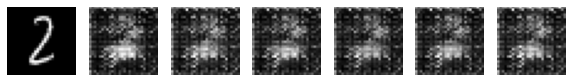

Epoch 4261 g_loss= 0.8654966 d_loss= 0.5465476 real_acc= 1.0 fake_acc= 1.0
Epoch 4262 g_loss= 0.869663 d_loss= 0.5435447 real_acc= 1.0 fake_acc= 1.0
Epoch 4263 g_loss= 0.8709795 d_loss= 0.54274637 real_acc= 1.0 fake_acc= 1.0
Epoch 4264 g_loss= 0.8832954 d_loss= 0.5338957 real_acc= 1.0 fake_acc= 1.0
Epoch 4265 g_loss= 0.87610704 d_loss= 0.53893936 real_acc= 1.0 fake_acc= 1.0
Epoch 4266 g_loss= 0.8692986 d_loss= 0.5437162 real_acc= 1.0 fake_acc= 1.0
Epoch 4267 g_loss= 0.8807473 d_loss= 0.5356709 real_acc= 1.0 fake_acc= 1.0
Epoch 4268 g_loss= 0.8835103 d_loss= 0.5336094 real_acc= 1.0 fake_acc= 1.0
Epoch 4269 g_loss= 0.8903245 d_loss= 0.5289852 real_acc= 1.0 fake_acc= 1.0
Epoch 4270 g_loss= 0.88896155 d_loss= 0.52995557 real_acc= 1.0 fake_acc= 1.0


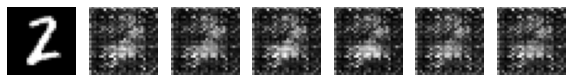

Epoch 4271 g_loss= 0.89583015 d_loss= 0.52513987 real_acc= 1.0 fake_acc= 1.0
Epoch 4272 g_loss= 0.90122026 d_loss= 0.52150494 real_acc= 1.0 fake_acc= 1.0
Epoch 4273 g_loss= 0.9081485 d_loss= 0.5207672 real_acc= 1.0 fake_acc= 1.0
Epoch 4274 g_loss= 0.9173462 d_loss= 0.51070285 real_acc= 1.0 fake_acc= 1.0
Epoch 4275 g_loss= 0.9118669 d_loss= 0.51439744 real_acc= 1.0 fake_acc= 1.0
Epoch 4276 g_loss= 0.9168734 d_loss= 0.5111912 real_acc= 1.0 fake_acc= 1.0
Epoch 4277 g_loss= 0.9254355 d_loss= 0.5053715 real_acc= 1.0 fake_acc= 1.0
Epoch 4278 g_loss= 0.9234967 d_loss= 0.5065268 real_acc= 1.0 fake_acc= 1.0
Epoch 4279 g_loss= 0.9279968 d_loss= 0.50362885 real_acc= 1.0 fake_acc= 1.0
Epoch 4280 g_loss= 0.94440925 d_loss= 0.4930698 real_acc= 1.0 fake_acc= 1.0


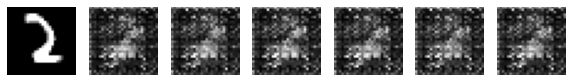

Epoch 4281 g_loss= 0.9421972 d_loss= 0.49434713 real_acc= 1.0 fake_acc= 1.0
Epoch 4282 g_loss= 0.93776315 d_loss= 0.49778175 real_acc= 1.0 fake_acc= 1.0
Epoch 4283 g_loss= 0.9517037 d_loss= 0.48848727 real_acc= 1.0 fake_acc= 1.0
Epoch 4284 g_loss= 0.96327734 d_loss= 0.4835832 real_acc= 1.0 fake_acc= 1.0
Epoch 4285 g_loss= 0.9560968 d_loss= 0.48613274 real_acc= 1.0 fake_acc= 1.0
Epoch 4286 g_loss= 0.9693764 d_loss= 0.4774785 real_acc= 1.0 fake_acc= 1.0
Epoch 4287 g_loss= 0.96719533 d_loss= 0.47935614 real_acc= 1.0 fake_acc= 1.0
Epoch 4288 g_loss= 0.971041 d_loss= 0.47662258 real_acc= 1.0 fake_acc= 1.0
Epoch 4289 g_loss= 0.9784838 d_loss= 0.47312197 real_acc= 1.0 fake_acc= 1.0
Epoch 4290 g_loss= 0.98285395 d_loss= 0.4693674 real_acc= 1.0 fake_acc= 1.0


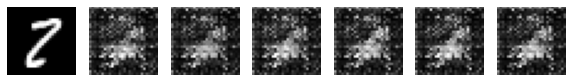

Epoch 4291 g_loss= 0.9944227 d_loss= 0.46474445 real_acc= 1.0 fake_acc= 1.0
Epoch 4292 g_loss= 0.99497724 d_loss= 0.46217784 real_acc= 1.0 fake_acc= 1.0
Epoch 4293 g_loss= 0.9876915 d_loss= 0.46636504 real_acc= 1.0 fake_acc= 1.0
Epoch 4294 g_loss= 0.9955238 d_loss= 0.46676928 real_acc= 1.0 fake_acc= 1.0
Epoch 4295 g_loss= 1.0071443 d_loss= 0.4551769 real_acc= 1.0 fake_acc= 1.0
Epoch 4296 g_loss= 1.0050311 d_loss= 0.45625684 real_acc= 1.0 fake_acc= 1.0
Epoch 4297 g_loss= 1.0219125 d_loss= 0.4470856 real_acc= 1.0 fake_acc= 1.0
Epoch 4298 g_loss= 1.0327014 d_loss= 0.57208896 real_acc= 0.98 fake_acc= 1.0
Epoch 4299 g_loss= 1.0237708 d_loss= 0.44719556 real_acc= 1.0 fake_acc= 1.0
Epoch 4300 g_loss= 1.0408568 d_loss= 0.43612295 real_acc= 1.0 fake_acc= 1.0


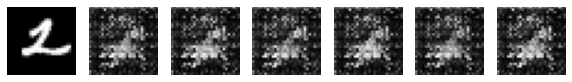

Epoch 4301 g_loss= 1.0353591 d_loss= 0.4444171 real_acc= 1.0 fake_acc= 1.0
Epoch 4302 g_loss= 1.0374409 d_loss= 0.51610285 real_acc= 0.98 fake_acc= 1.0
Epoch 4303 g_loss= 1.0440586 d_loss= 0.43429783 real_acc= 1.0 fake_acc= 1.0
Epoch 4304 g_loss= 1.050341 d_loss= 0.44236487 real_acc= 1.0 fake_acc= 1.0
Epoch 4305 g_loss= 1.0478089 d_loss= 0.43296286 real_acc= 1.0 fake_acc= 1.0
Epoch 4306 g_loss= 1.0569366 d_loss= 0.42747122 real_acc= 1.0 fake_acc= 1.0
Epoch 4307 g_loss= 1.0628206 d_loss= 0.42439693 real_acc= 1.0 fake_acc= 1.0
Epoch 4308 g_loss= 1.0586423 d_loss= 0.43479946 real_acc= 1.0 fake_acc= 1.0
Epoch 4309 g_loss= 1.0650693 d_loss= 0.42314473 real_acc= 1.0 fake_acc= 1.0
Epoch 4310 g_loss= 1.0740752 d_loss= 0.41891095 real_acc= 1.0 fake_acc= 1.0


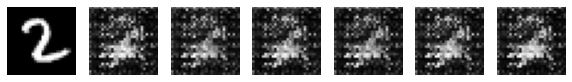

Epoch 4311 g_loss= 1.0733906 d_loss= 0.60362667 real_acc= 0.98 fake_acc= 1.0
Epoch 4312 g_loss= 1.075769 d_loss= 0.42142105 real_acc= 1.0 fake_acc= 1.0
Epoch 4313 g_loss= 1.0848572 d_loss= 0.41297567 real_acc= 1.0 fake_acc= 1.0
Epoch 4314 g_loss= 1.0753573 d_loss= 0.4312387 real_acc= 1.0 fake_acc= 1.0
Epoch 4315 g_loss= 1.0782262 d_loss= 0.41653088 real_acc= 1.0 fake_acc= 1.0
Epoch 4316 g_loss= 1.0942335 d_loss= 0.40832683 real_acc= 1.0 fake_acc= 1.0
Epoch 4317 g_loss= 1.0864131 d_loss= 0.4122743 real_acc= 1.0 fake_acc= 1.0
Epoch 4318 g_loss= 1.1034504 d_loss= 0.40361702 real_acc= 1.0 fake_acc= 1.0
Epoch 4319 g_loss= 1.1111015 d_loss= 0.40006256 real_acc= 1.0 fake_acc= 1.0
Epoch 4320 g_loss= 1.1099046 d_loss= 0.40060955 real_acc= 1.0 fake_acc= 1.0


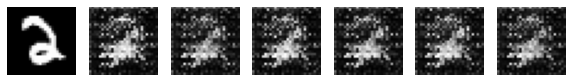

Epoch 4321 g_loss= 1.1146823 d_loss= 0.39930058 real_acc= 1.0 fake_acc= 1.0
Epoch 4322 g_loss= 1.1144247 d_loss= 0.39829144 real_acc= 1.0 fake_acc= 1.0
Epoch 4323 g_loss= 1.134141 d_loss= 0.3886921 real_acc= 1.0 fake_acc= 1.0
Epoch 4324 g_loss= 1.1318239 d_loss= 0.38973892 real_acc= 1.0 fake_acc= 1.0
Epoch 4325 g_loss= 1.1408358 d_loss= 0.38551208 real_acc= 1.0 fake_acc= 1.0
Epoch 4326 g_loss= 1.1443989 d_loss= 0.38392287 real_acc= 1.0 fake_acc= 1.0
Epoch 4327 g_loss= 1.1617796 d_loss= 0.37583098 real_acc= 1.0 fake_acc= 1.0
Epoch 4328 g_loss= 1.1582247 d_loss= 0.37749708 real_acc= 1.0 fake_acc= 1.0
Epoch 4329 g_loss= 1.1653594 d_loss= 0.4071902 real_acc= 0.98 fake_acc= 1.0
Epoch 4330 g_loss= 1.1646656 d_loss= 0.37460157 real_acc= 1.0 fake_acc= 1.0


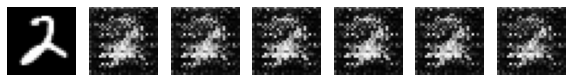

Epoch 4331 g_loss= 1.1675586 d_loss= 0.37337115 real_acc= 1.0 fake_acc= 1.0
Epoch 4332 g_loss= 1.1925067 d_loss= 0.36241043 real_acc= 1.0 fake_acc= 1.0
Epoch 4333 g_loss= 1.1938019 d_loss= 0.36295903 real_acc= 1.0 fake_acc= 1.0
Epoch 4334 g_loss= 1.1932831 d_loss= 0.36206827 real_acc= 1.0 fake_acc= 1.0
Epoch 4335 g_loss= 1.208498 d_loss= 0.3553671 real_acc= 1.0 fake_acc= 1.0
Epoch 4336 g_loss= 1.1996274 d_loss= 0.35900834 real_acc= 1.0 fake_acc= 1.0
Epoch 4337 g_loss= 1.2184356 d_loss= 0.3511648 real_acc= 1.0 fake_acc= 1.0
Epoch 4338 g_loss= 1.2286911 d_loss= 0.34699997 real_acc= 1.0 fake_acc= 1.0
Epoch 4339 g_loss= 1.2356799 d_loss= 0.3473001 real_acc= 1.0 fake_acc= 1.0
Epoch 4340 g_loss= 1.2405617 d_loss= 0.34199664 real_acc= 1.0 fake_acc= 1.0


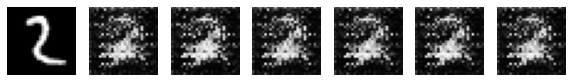

Epoch 4341 g_loss= 1.245765 d_loss= 0.33982164 real_acc= 1.0 fake_acc= 1.0
Epoch 4342 g_loss= 1.2619214 d_loss= 0.33327317 real_acc= 1.0 fake_acc= 1.0
Epoch 4343 g_loss= 1.2722166 d_loss= 0.32940814 real_acc= 1.0 fake_acc= 1.0
Epoch 4344 g_loss= 1.279911 d_loss= 0.3262919 real_acc= 1.0 fake_acc= 1.0
Epoch 4345 g_loss= 1.28325 d_loss= 0.3395505 real_acc= 0.98 fake_acc= 1.0
Epoch 4346 g_loss= 1.2924614 d_loss= 0.32162786 real_acc= 1.0 fake_acc= 1.0
Epoch 4347 g_loss= 1.3097906 d_loss= 0.31519237 real_acc= 1.0 fake_acc= 1.0
Epoch 4348 g_loss= 1.3159467 d_loss= 0.31292254 real_acc= 1.0 fake_acc= 1.0
Epoch 4349 g_loss= 1.3153648 d_loss= 0.31347042 real_acc= 1.0 fake_acc= 1.0
Epoch 4350 g_loss= 1.3253216 d_loss= 0.30954558 real_acc= 1.0 fake_acc= 1.0


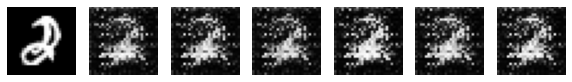

Epoch 4351 g_loss= 1.3369693 d_loss= 0.3053573 real_acc= 1.0 fake_acc= 1.0
Epoch 4352 g_loss= 1.3325015 d_loss= 0.30672786 real_acc= 1.0 fake_acc= 1.0
Epoch 4353 g_loss= 1.3461407 d_loss= 0.3020161 real_acc= 1.0 fake_acc= 1.0
Epoch 4354 g_loss= 1.3502907 d_loss= 0.30098072 real_acc= 1.0 fake_acc= 1.0
Epoch 4355 g_loss= 1.3637978 d_loss= 0.29615745 real_acc= 1.0 fake_acc= 1.0
Epoch 4356 g_loss= 1.3860327 d_loss= 0.28835893 real_acc= 1.0 fake_acc= 1.0
Epoch 4357 g_loss= 1.3827045 d_loss= 0.5682064 real_acc= 0.98 fake_acc= 1.0
Epoch 4358 g_loss= 1.3945076 d_loss= 0.28574327 real_acc= 1.0 fake_acc= 1.0
Epoch 4359 g_loss= 1.3965265 d_loss= 0.28523803 real_acc= 1.0 fake_acc= 1.0
Epoch 4360 g_loss= 1.4099177 d_loss= 0.2803885 real_acc= 1.0 fake_acc= 1.0


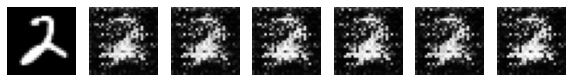

Epoch 4361 g_loss= 1.419746 d_loss= 0.27742365 real_acc= 1.0 fake_acc= 1.0
Epoch 4362 g_loss= 1.4310085 d_loss= 0.27368483 real_acc= 1.0 fake_acc= 1.0
Epoch 4363 g_loss= 1.4246085 d_loss= 0.27590418 real_acc= 1.0 fake_acc= 1.0
Epoch 4364 g_loss= 1.4368521 d_loss= 0.27179685 real_acc= 1.0 fake_acc= 1.0
Epoch 4365 g_loss= 1.4532079 d_loss= 0.2669136 real_acc= 1.0 fake_acc= 1.0
Epoch 4366 g_loss= 1.4377775 d_loss= 0.27156326 real_acc= 1.0 fake_acc= 1.0
Epoch 4367 g_loss= 1.4571855 d_loss= 0.26571238 real_acc= 1.0 fake_acc= 1.0
Epoch 4368 g_loss= 1.4731303 d_loss= 0.26081076 real_acc= 1.0 fake_acc= 1.0
Epoch 4369 g_loss= 1.4765549 d_loss= 0.25997075 real_acc= 1.0 fake_acc= 1.0
Epoch 4370 g_loss= 1.4814043 d_loss= 0.25819987 real_acc= 1.0 fake_acc= 1.0


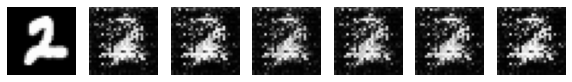

Epoch 4371 g_loss= 1.4975232 d_loss= 0.25375158 real_acc= 1.0 fake_acc= 1.0
Epoch 4372 g_loss= 1.5046136 d_loss= 0.2515522 real_acc= 1.0 fake_acc= 1.0
Epoch 4373 g_loss= 1.5190543 d_loss= 0.25630948 real_acc= 1.0 fake_acc= 1.0
Epoch 4374 g_loss= 1.5338733 d_loss= 0.33769298 real_acc= 0.98 fake_acc= 1.0
Epoch 4375 g_loss= 1.5306586 d_loss= 0.25718725 real_acc= 1.0 fake_acc= 1.0
Epoch 4376 g_loss= 1.520698 d_loss= 0.24705833 real_acc= 1.0 fake_acc= 1.0
Epoch 4377 g_loss= 1.5271356 d_loss= 0.24547334 real_acc= 1.0 fake_acc= 1.0
Epoch 4378 g_loss= 1.5316195 d_loss= 0.24457291 real_acc= 1.0 fake_acc= 1.0
Epoch 4379 g_loss= 1.5280449 d_loss= 0.24495229 real_acc= 1.0 fake_acc= 1.0
Epoch 4380 g_loss= 1.5386478 d_loss= 0.24207315 real_acc= 1.0 fake_acc= 1.0


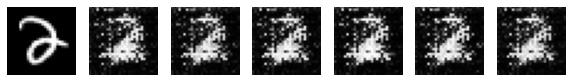

Epoch 4381 g_loss= 1.5573543 d_loss= 0.23721777 real_acc= 1.0 fake_acc= 1.0
Epoch 4382 g_loss= 1.5422182 d_loss= 0.24127644 real_acc= 1.0 fake_acc= 1.0
Epoch 4383 g_loss= 1.5525191 d_loss= 0.238259 real_acc= 1.0 fake_acc= 1.0
Epoch 4384 g_loss= 1.5508189 d_loss= 0.2388926 real_acc= 1.0 fake_acc= 1.0
Epoch 4385 g_loss= 1.5606544 d_loss= 0.23625168 real_acc= 1.0 fake_acc= 1.0
Epoch 4386 g_loss= 1.5869286 d_loss= 0.22927307 real_acc= 1.0 fake_acc= 1.0
Epoch 4387 g_loss= 1.5690914 d_loss= 0.23419267 real_acc= 1.0 fake_acc= 1.0
Epoch 4388 g_loss= 1.5763876 d_loss= 0.23212299 real_acc= 1.0 fake_acc= 1.0
Epoch 4389 g_loss= 1.590934 d_loss= 0.22833464 real_acc= 1.0 fake_acc= 1.0
Epoch 4390 g_loss= 1.6093533 d_loss= 0.22351152 real_acc= 1.0 fake_acc= 1.0


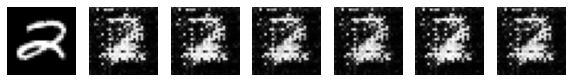

Epoch 4391 g_loss= 1.6130397 d_loss= 0.22285452 real_acc= 1.0 fake_acc= 1.0
Epoch 4392 g_loss= 1.6018219 d_loss= 0.22554906 real_acc= 1.0 fake_acc= 1.0
Epoch 4393 g_loss= 1.6280805 d_loss= 0.21896034 real_acc= 1.0 fake_acc= 1.0
Epoch 4394 g_loss= 1.6369075 d_loss= 0.2169413 real_acc= 1.0 fake_acc= 1.0
Epoch 4395 g_loss= 1.63457 d_loss= 0.21743129 real_acc= 1.0 fake_acc= 1.0
Epoch 4396 g_loss= 1.6600457 d_loss= 0.21154246 real_acc= 1.0 fake_acc= 1.0
Epoch 4397 g_loss= 1.6539711 d_loss= 0.21288331 real_acc= 1.0 fake_acc= 1.0
Epoch 4398 g_loss= 1.6688008 d_loss= 0.20930901 real_acc= 1.0 fake_acc= 1.0
Epoch 4399 g_loss= 1.6766427 d_loss= 0.20773667 real_acc= 1.0 fake_acc= 1.0
Epoch 4400 g_loss= 1.7020007 d_loss= 0.25267008 real_acc= 0.98 fake_acc= 1.0


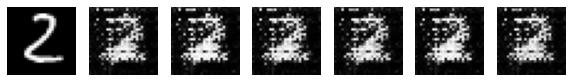

Epoch 4401 g_loss= 1.6868864 d_loss= 0.20536236 real_acc= 1.0 fake_acc= 1.0
Epoch 4402 g_loss= 1.7194927 d_loss= 0.19785339 real_acc= 1.0 fake_acc= 1.0
Epoch 4403 g_loss= 1.6997614 d_loss= 0.2021589 real_acc= 1.0 fake_acc= 1.0
Epoch 4404 g_loss= 1.7216198 d_loss= 0.19747624 real_acc= 1.0 fake_acc= 1.0
Epoch 4405 g_loss= 1.7185713 d_loss= 0.19819155 real_acc= 1.0 fake_acc= 1.0
Epoch 4406 g_loss= 1.7410507 d_loss= 0.19319317 real_acc= 1.0 fake_acc= 1.0
Epoch 4407 g_loss= 1.7549907 d_loss= 0.19039996 real_acc= 1.0 fake_acc= 1.0
Epoch 4408 g_loss= 1.7667279 d_loss= 0.18786183 real_acc= 1.0 fake_acc= 1.0
Epoch 4409 g_loss= 1.754383 d_loss= 0.1904469 real_acc= 1.0 fake_acc= 1.0
Epoch 4410 g_loss= 1.762744 d_loss= 0.18871547 real_acc= 1.0 fake_acc= 1.0


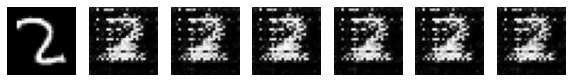

Epoch 4411 g_loss= 1.7545233 d_loss= 0.19031385 real_acc= 1.0 fake_acc= 1.0
Epoch 4412 g_loss= 1.7901831 d_loss= 0.1831712 real_acc= 1.0 fake_acc= 1.0
Epoch 4413 g_loss= 1.8043338 d_loss= 0.18021001 real_acc= 1.0 fake_acc= 1.0
Epoch 4414 g_loss= 1.8142627 d_loss= 0.17905758 real_acc= 1.0 fake_acc= 1.0
Epoch 4415 g_loss= 1.8065032 d_loss= 0.18013805 real_acc= 1.0 fake_acc= 1.0
Epoch 4416 g_loss= 1.8255595 d_loss= 0.1760747 real_acc= 1.0 fake_acc= 1.0
Epoch 4417 g_loss= 1.8338014 d_loss= 0.19707382 real_acc= 0.98 fake_acc= 1.0
Epoch 4418 g_loss= 1.8361325 d_loss= 0.1741212 real_acc= 1.0 fake_acc= 1.0
Epoch 4419 g_loss= 1.8541992 d_loss= 0.17081864 real_acc= 1.0 fake_acc= 1.0
Epoch 4420 g_loss= 1.8557467 d_loss= 0.1757626 real_acc= 1.0 fake_acc= 1.0


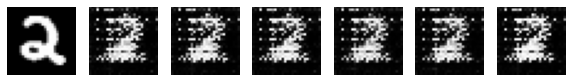

Epoch 4421 g_loss= 1.8690286 d_loss= 0.16799958 real_acc= 1.0 fake_acc= 1.0
Epoch 4422 g_loss= 1.8734058 d_loss= 0.16724616 real_acc= 1.0 fake_acc= 1.0
Epoch 4423 g_loss= 1.8814044 d_loss= 0.16580135 real_acc= 1.0 fake_acc= 1.0
Epoch 4424 g_loss= 1.91363 d_loss= 0.16058132 real_acc= 1.0 fake_acc= 1.0
Epoch 4425 g_loss= 1.8993628 d_loss= 0.16254719 real_acc= 1.0 fake_acc= 1.0
Epoch 4426 g_loss= 1.9087839 d_loss= 0.16094115 real_acc= 1.0 fake_acc= 1.0
Epoch 4427 g_loss= 1.9201417 d_loss= 0.15890071 real_acc= 1.0 fake_acc= 1.0
Epoch 4428 g_loss= 1.9504683 d_loss= 0.15386178 real_acc= 1.0 fake_acc= 1.0
Epoch 4429 g_loss= 1.9367485 d_loss= 0.1560533 real_acc= 1.0 fake_acc= 1.0
Epoch 4430 g_loss= 1.952274 d_loss= 0.15344617 real_acc= 1.0 fake_acc= 1.0


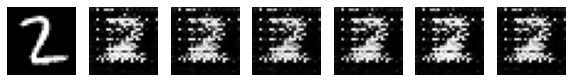

Epoch 4431 g_loss= 1.96486 d_loss= 0.15146005 real_acc= 1.0 fake_acc= 1.0
Epoch 4432 g_loss= 1.9403936 d_loss= 0.15561144 real_acc= 1.0 fake_acc= 1.0
Epoch 4433 g_loss= 1.9862175 d_loss= 0.14804687 real_acc= 1.0 fake_acc= 1.0
Epoch 4434 g_loss= 2.018682 d_loss= 0.14296319 real_acc= 1.0 fake_acc= 1.0
Epoch 4435 g_loss= 2.0326197 d_loss= 0.14641805 real_acc= 1.0 fake_acc= 1.0
Epoch 4436 g_loss= 2.029165 d_loss= 0.14148426 real_acc= 1.0 fake_acc= 1.0
Epoch 4437 g_loss= 2.0378644 d_loss= 0.1400014 real_acc= 1.0 fake_acc= 1.0
Epoch 4438 g_loss= 2.0325515 d_loss= 0.14070624 real_acc= 1.0 fake_acc= 1.0
Epoch 4439 g_loss= 2.0524323 d_loss= 0.13807319 real_acc= 1.0 fake_acc= 1.0
Epoch 4440 g_loss= 2.0837638 d_loss= 0.13341306 real_acc= 1.0 fake_acc= 1.0


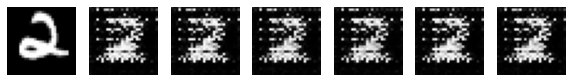

Epoch 4441 g_loss= 2.0704653 d_loss= 0.13522772 real_acc= 1.0 fake_acc= 1.0
Epoch 4442 g_loss= 2.0887 d_loss= 0.13258891 real_acc= 1.0 fake_acc= 1.0
Epoch 4443 g_loss= 2.1158223 d_loss= 0.12883763 real_acc= 1.0 fake_acc= 1.0
Epoch 4444 g_loss= 2.1152887 d_loss= 0.12902246 real_acc= 1.0 fake_acc= 1.0
Epoch 4445 g_loss= 2.1297407 d_loss= 0.12700436 real_acc= 1.0 fake_acc= 1.0
Epoch 4446 g_loss= 2.1486008 d_loss= 0.124426365 real_acc= 1.0 fake_acc= 1.0
Epoch 4447 g_loss= 2.138233 d_loss= 0.12590542 real_acc= 1.0 fake_acc= 1.0
Epoch 4448 g_loss= 2.181932 d_loss= 0.1860796 real_acc= 0.98 fake_acc= 1.0
Epoch 4449 g_loss= 2.184999 d_loss= 0.11960562 real_acc= 1.0 fake_acc= 1.0
Epoch 4450 g_loss= 2.1898234 d_loss= 0.119210474 real_acc= 1.0 fake_acc= 1.0


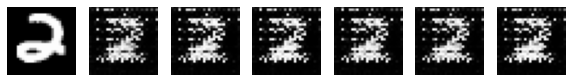

Epoch 4451 g_loss= 2.1874669 d_loss= 0.119736336 real_acc= 1.0 fake_acc= 1.0
Epoch 4452 g_loss= 2.1955225 d_loss= 0.11844782 real_acc= 1.0 fake_acc= 1.0
Epoch 4453 g_loss= 2.2140284 d_loss= 0.11600103 real_acc= 1.0 fake_acc= 1.0
Epoch 4454 g_loss= 2.2155254 d_loss= 0.116031475 real_acc= 1.0 fake_acc= 1.0
Epoch 4455 g_loss= 2.2449088 d_loss= 0.11233302 real_acc= 1.0 fake_acc= 1.0
Epoch 4456 g_loss= 2.257911 d_loss= 0.11091079 real_acc= 1.0 fake_acc= 1.0
Epoch 4457 g_loss= 2.250205 d_loss= 0.112043865 real_acc= 1.0 fake_acc= 1.0
Epoch 4458 g_loss= 2.2456856 d_loss= 0.11255037 real_acc= 1.0 fake_acc= 1.0
Epoch 4459 g_loss= 2.27129 d_loss= 0.10938853 real_acc= 1.0 fake_acc= 1.0
Epoch 4460 g_loss= 2.2892096 d_loss= 0.10735751 real_acc= 1.0 fake_acc= 1.0


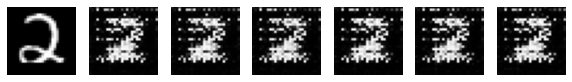

Epoch 4461 g_loss= 2.3070426 d_loss= 0.10543516 real_acc= 1.0 fake_acc= 1.0
Epoch 4462 g_loss= 2.3267004 d_loss= 0.10300971 real_acc= 1.0 fake_acc= 1.0
Epoch 4463 g_loss= 2.3202672 d_loss= 0.10392635 real_acc= 1.0 fake_acc= 1.0
Epoch 4464 g_loss= 2.3325903 d_loss= 0.10240852 real_acc= 1.0 fake_acc= 1.0
Epoch 4465 g_loss= 2.328479 d_loss= 0.10290756 real_acc= 1.0 fake_acc= 1.0
Epoch 4466 g_loss= 2.3754482 d_loss= 0.09784346 real_acc= 1.0 fake_acc= 1.0
Epoch 4467 g_loss= 2.3577628 d_loss= 0.09986052 real_acc= 1.0 fake_acc= 1.0
Epoch 4468 g_loss= 2.3822298 d_loss= 0.09734679 real_acc= 1.0 fake_acc= 1.0
Epoch 4469 g_loss= 2.3705518 d_loss= 0.0984975 real_acc= 1.0 fake_acc= 1.0
Epoch 4470 g_loss= 2.4092414 d_loss= 0.11798062 real_acc= 0.98 fake_acc= 1.0


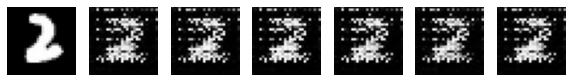

Epoch 4471 g_loss= 2.4281085 d_loss= 0.10539102 real_acc= 1.0 fake_acc= 1.0
Epoch 4472 g_loss= 2.4148765 d_loss= 0.09529727 real_acc= 1.0 fake_acc= 1.0
Epoch 4473 g_loss= 2.420373 d_loss= 0.0935193 real_acc= 1.0 fake_acc= 1.0
Epoch 4474 g_loss= 2.4055152 d_loss= 0.09499492 real_acc= 1.0 fake_acc= 1.0
Epoch 4475 g_loss= 2.4220498 d_loss= 0.09682098 real_acc= 1.0 fake_acc= 1.0
Epoch 4476 g_loss= 2.4375854 d_loss= 0.091815345 real_acc= 1.0 fake_acc= 1.0
Epoch 4477 g_loss= 2.440284 d_loss= 0.091631204 real_acc= 1.0 fake_acc= 1.0
Epoch 4478 g_loss= 2.4262056 d_loss= 0.09289101 real_acc= 1.0 fake_acc= 1.0
Epoch 4479 g_loss= 2.4440284 d_loss= 0.09115884 real_acc= 1.0 fake_acc= 1.0
Epoch 4480 g_loss= 2.430614 d_loss= 0.09244271 real_acc= 1.0 fake_acc= 1.0


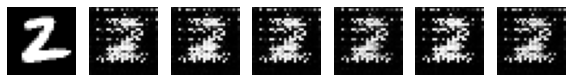

Epoch 4481 g_loss= 2.472471 d_loss= 0.08853928 real_acc= 1.0 fake_acc= 1.0
Epoch 4482 g_loss= 2.4767537 d_loss= 0.0881474 real_acc= 1.0 fake_acc= 1.0
Epoch 4483 g_loss= 2.4649339 d_loss= 0.08917751 real_acc= 1.0 fake_acc= 1.0
Epoch 4484 g_loss= 2.501759 d_loss= 0.08589805 real_acc= 1.0 fake_acc= 1.0
Epoch 4485 g_loss= 2.495791 d_loss= 0.08644238 real_acc= 1.0 fake_acc= 1.0
Epoch 4486 g_loss= 2.4991522 d_loss= 0.0860157 real_acc= 1.0 fake_acc= 1.0
Epoch 4487 g_loss= 2.4908035 d_loss= 0.086945675 real_acc= 1.0 fake_acc= 1.0
Epoch 4488 g_loss= 2.5210505 d_loss= 0.08421942 real_acc= 1.0 fake_acc= 1.0
Epoch 4489 g_loss= 2.5280144 d_loss= 0.083656624 real_acc= 1.0 fake_acc= 1.0
Epoch 4490 g_loss= 2.5264077 d_loss= 0.08369429 real_acc= 1.0 fake_acc= 1.0


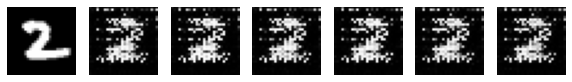

Epoch 4491 g_loss= 2.5233846 d_loss= 0.08399593 real_acc= 1.0 fake_acc= 1.0
Epoch 4492 g_loss= 2.5766647 d_loss= 0.07941705 real_acc= 1.0 fake_acc= 1.0
Epoch 4493 g_loss= 2.552889 d_loss= 0.08142934 real_acc= 1.0 fake_acc= 1.0
Epoch 4494 g_loss= 2.5846393 d_loss= 0.07875733 real_acc= 1.0 fake_acc= 1.0
Epoch 4495 g_loss= 2.6072373 d_loss= 0.07688968 real_acc= 1.0 fake_acc= 1.0
Epoch 4496 g_loss= 2.6087506 d_loss= 0.07680435 real_acc= 1.0 fake_acc= 1.0
Epoch 4497 g_loss= 2.6160169 d_loss= 0.07624292 real_acc= 1.0 fake_acc= 1.0
Epoch 4498 g_loss= 2.6301174 d_loss= 0.07509298 real_acc= 1.0 fake_acc= 1.0
Epoch 4499 g_loss= 2.6710837 d_loss= 0.07194611 real_acc= 1.0 fake_acc= 1.0
Epoch 4500 g_loss= 2.6300757 d_loss= 0.07505041 real_acc= 1.0 fake_acc= 1.0


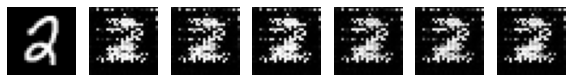

Epoch 4501 g_loss= 2.6350918 d_loss= 0.07460863 real_acc= 1.0 fake_acc= 1.0
Epoch 4502 g_loss= 2.6437998 d_loss= 0.074049525 real_acc= 1.0 fake_acc= 1.0
Epoch 4503 g_loss= 2.6926394 d_loss= 0.07038474 real_acc= 1.0 fake_acc= 1.0
Epoch 4504 g_loss= 2.7028933 d_loss= 0.34299028 real_acc= 0.98 fake_acc= 1.0
Epoch 4505 g_loss= 2.6946986 d_loss= 0.07020391 real_acc= 1.0 fake_acc= 1.0
Epoch 4506 g_loss= 2.6904604 d_loss= 0.07057134 real_acc= 1.0 fake_acc= 1.0
Epoch 4507 g_loss= 2.6764114 d_loss= 0.08546824 real_acc= 0.98 fake_acc= 1.0
Epoch 4508 g_loss= 2.7146268 d_loss= 0.06877522 real_acc= 1.0 fake_acc= 1.0
Epoch 4509 g_loss= 2.6972153 d_loss= 0.070019595 real_acc= 1.0 fake_acc= 1.0
Epoch 4510 g_loss= 2.708829 d_loss= 0.069253586 real_acc= 1.0 fake_acc= 1.0


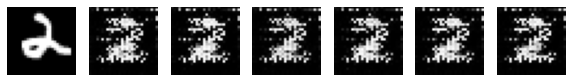

Epoch 4511 g_loss= 2.734133 d_loss= 0.06748345 real_acc= 1.0 fake_acc= 1.0
Epoch 4512 g_loss= 2.7271447 d_loss= 0.06810446 real_acc= 1.0 fake_acc= 1.0
Epoch 4513 g_loss= 2.7224047 d_loss= 0.06842023 real_acc= 1.0 fake_acc= 1.0
Epoch 4514 g_loss= 2.7443023 d_loss= 0.06676399 real_acc= 1.0 fake_acc= 1.0
Epoch 4515 g_loss= 2.7395976 d_loss= 0.06707737 real_acc= 1.0 fake_acc= 1.0
Epoch 4516 g_loss= 2.7798386 d_loss= 0.064323746 real_acc= 1.0 fake_acc= 1.0
Epoch 4517 g_loss= 2.7616012 d_loss= 0.06560624 real_acc= 1.0 fake_acc= 1.0
Epoch 4518 g_loss= 2.786951 d_loss= 0.064038016 real_acc= 1.0 fake_acc= 1.0
Epoch 4519 g_loss= 2.780682 d_loss= 0.0644832 real_acc= 1.0 fake_acc= 1.0
Epoch 4520 g_loss= 2.7828088 d_loss= 0.06420508 real_acc= 1.0 fake_acc= 1.0


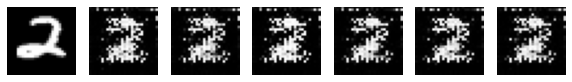

Epoch 4521 g_loss= 2.7908957 d_loss= 0.06370279 real_acc= 1.0 fake_acc= 1.0
Epoch 4522 g_loss= 2.7996452 d_loss= 0.063070044 real_acc= 1.0 fake_acc= 1.0
Epoch 4523 g_loss= 2.8247156 d_loss= 0.061461978 real_acc= 1.0 fake_acc= 1.0
Epoch 4524 g_loss= 2.7952774 d_loss= 0.06354084 real_acc= 1.0 fake_acc= 1.0
Epoch 4525 g_loss= 2.8278685 d_loss= 0.06125938 real_acc= 1.0 fake_acc= 1.0
Epoch 4526 g_loss= 2.8675861 d_loss= 0.058745045 real_acc= 1.0 fake_acc= 1.0
Epoch 4527 g_loss= 2.8429224 d_loss= 0.060830258 real_acc= 1.0 fake_acc= 1.0
Epoch 4528 g_loss= 2.8731396 d_loss= 0.058628283 real_acc= 1.0 fake_acc= 1.0
Epoch 4529 g_loss= 2.8611388 d_loss= 0.059275337 real_acc= 1.0 fake_acc= 1.0
Epoch 4530 g_loss= 2.8703232 d_loss= 0.05870255 real_acc= 1.0 fake_acc= 1.0


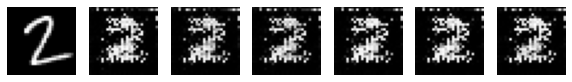

Epoch 4531 g_loss= 2.8805819 d_loss= 0.05807091 real_acc= 1.0 fake_acc= 1.0
Epoch 4532 g_loss= 2.8934557 d_loss= 0.05727913 real_acc= 1.0 fake_acc= 1.0
Epoch 4533 g_loss= 2.9230895 d_loss= 0.05559443 real_acc= 1.0 fake_acc= 1.0
Epoch 4534 g_loss= 2.9107485 d_loss= 0.056255292 real_acc= 1.0 fake_acc= 1.0
Epoch 4535 g_loss= 2.9182692 d_loss= 0.055824924 real_acc= 1.0 fake_acc= 1.0
Epoch 4536 g_loss= 2.933679 d_loss= 0.05496531 real_acc= 1.0 fake_acc= 1.0
Epoch 4537 g_loss= 2.958686 d_loss= 0.053720836 real_acc= 1.0 fake_acc= 1.0
Epoch 4538 g_loss= 2.9614499 d_loss= 0.05356023 real_acc= 1.0 fake_acc= 1.0
Epoch 4539 g_loss= 2.9802792 d_loss= 0.052327275 real_acc= 1.0 fake_acc= 1.0
Epoch 4540 g_loss= 2.9557912 d_loss= 0.053690568 real_acc= 1.0 fake_acc= 1.0


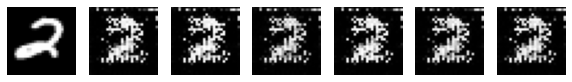

Epoch 4541 g_loss= 2.9859006 d_loss= 0.052071743 real_acc= 1.0 fake_acc= 1.0
Epoch 4542 g_loss= 2.9845788 d_loss= 0.05220085 real_acc= 1.0 fake_acc= 1.0
Epoch 4543 g_loss= 3.0012 d_loss= 0.051331 real_acc= 1.0 fake_acc= 1.0
Epoch 4544 g_loss= 3.0122025 d_loss= 0.050801 real_acc= 1.0 fake_acc= 1.0
Epoch 4545 g_loss= 3.0483396 d_loss= 0.048891425 real_acc= 1.0 fake_acc= 1.0
Epoch 4546 g_loss= 3.0458264 d_loss= 0.04891612 real_acc= 1.0 fake_acc= 1.0
Epoch 4547 g_loss= 3.0403106 d_loss= 0.049104482 real_acc= 1.0 fake_acc= 1.0
Epoch 4548 g_loss= 3.0683134 d_loss= 0.04790595 real_acc= 1.0 fake_acc= 1.0
Epoch 4549 g_loss= 3.0577745 d_loss= 0.04848802 real_acc= 1.0 fake_acc= 1.0
Epoch 4550 g_loss= 3.1343126 d_loss= 0.044761598 real_acc= 1.0 fake_acc= 1.0


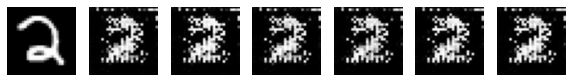

Epoch 4551 g_loss= 3.094889 d_loss= 0.046655428 real_acc= 1.0 fake_acc= 1.0
Epoch 4552 g_loss= 3.09233 d_loss= 0.046701655 real_acc= 1.0 fake_acc= 1.0
Epoch 4553 g_loss= 3.1165586 d_loss= 0.045616332 real_acc= 1.0 fake_acc= 1.0
Epoch 4554 g_loss= 3.127229 d_loss= 0.045061685 real_acc= 1.0 fake_acc= 1.0
Epoch 4555 g_loss= 3.1135557 d_loss= 0.045741603 real_acc= 1.0 fake_acc= 1.0
Epoch 4556 g_loss= 3.1455853 d_loss= 0.044175882 real_acc= 1.0 fake_acc= 1.0
Epoch 4557 g_loss= 3.1780138 d_loss= 0.042804364 real_acc= 1.0 fake_acc= 1.0
Epoch 4558 g_loss= 3.184762 d_loss= 0.042606268 real_acc= 1.0 fake_acc= 1.0
Epoch 4559 g_loss= 3.1980643 d_loss= 0.041851945 real_acc= 1.0 fake_acc= 1.0
Epoch 4560 g_loss= 3.1908114 d_loss= 0.042356778 real_acc= 1.0 fake_acc= 1.0


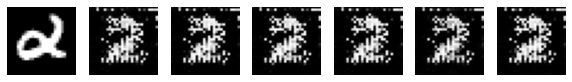

Epoch 4561 g_loss= 3.1887271 d_loss= 0.042375848 real_acc= 1.0 fake_acc= 1.0
Epoch 4562 g_loss= 3.2167263 d_loss= 0.04112017 real_acc= 1.0 fake_acc= 1.0
Epoch 4563 g_loss= 3.1998246 d_loss= 0.041849893 real_acc= 1.0 fake_acc= 1.0
Epoch 4564 g_loss= 3.2137277 d_loss= 0.04125508 real_acc= 1.0 fake_acc= 1.0
Epoch 4565 g_loss= 3.2252707 d_loss= 0.04078489 real_acc= 1.0 fake_acc= 1.0
Epoch 4566 g_loss= 3.2641852 d_loss= 0.039289676 real_acc= 1.0 fake_acc= 1.0
Epoch 4567 g_loss= 3.237633 d_loss= 0.040263977 real_acc= 1.0 fake_acc= 1.0
Epoch 4568 g_loss= 3.2385998 d_loss= 0.040243402 real_acc= 1.0 fake_acc= 1.0
Epoch 4569 g_loss= 3.2810483 d_loss= 0.03854253 real_acc= 1.0 fake_acc= 1.0
Epoch 4570 g_loss= 3.2912567 d_loss= 0.05770473 real_acc= 0.98 fake_acc= 1.0


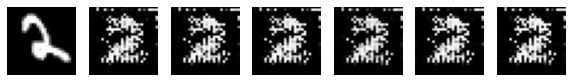

Epoch 4571 g_loss= 3.2697523 d_loss= 0.038978323 real_acc= 1.0 fake_acc= 1.0
Epoch 4572 g_loss= 3.2678123 d_loss= 0.039109137 real_acc= 1.0 fake_acc= 1.0
Epoch 4573 g_loss= 3.2843812 d_loss= 0.03846866 real_acc= 1.0 fake_acc= 1.0
Epoch 4574 g_loss= 3.314344 d_loss= 0.037286565 real_acc= 1.0 fake_acc= 1.0
Epoch 4575 g_loss= 3.2863653 d_loss= 0.03841284 real_acc= 1.0 fake_acc= 1.0
Epoch 4576 g_loss= 3.3084354 d_loss= 0.037536386 real_acc= 1.0 fake_acc= 1.0
Epoch 4577 g_loss= 3.2969248 d_loss= 0.037951667 real_acc= 1.0 fake_acc= 1.0
Epoch 4578 g_loss= 3.2991881 d_loss= 0.037963033 real_acc= 1.0 fake_acc= 1.0
Epoch 4579 g_loss= 3.2845793 d_loss= 0.03840145 real_acc= 1.0 fake_acc= 1.0
Epoch 4580 g_loss= 3.312599 d_loss= 0.03742334 real_acc= 1.0 fake_acc= 1.0


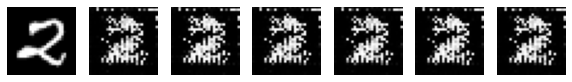

Epoch 4581 g_loss= 3.3571453 d_loss= 0.035651583 real_acc= 1.0 fake_acc= 1.0
Epoch 4582 g_loss= 3.3395298 d_loss= 0.03642569 real_acc= 1.0 fake_acc= 1.0
Epoch 4583 g_loss= 3.3456717 d_loss= 0.036086448 real_acc= 1.0 fake_acc= 1.0
Epoch 4584 g_loss= 3.3464499 d_loss= 0.036090825 real_acc= 1.0 fake_acc= 1.0
Epoch 4585 g_loss= 3.3702285 d_loss= 0.035291266 real_acc= 1.0 fake_acc= 1.0
Epoch 4586 g_loss= 3.352756 d_loss= 0.035834387 real_acc= 1.0 fake_acc= 1.0
Epoch 4587 g_loss= 3.3388944 d_loss= 0.036362488 real_acc= 1.0 fake_acc= 1.0
Epoch 4588 g_loss= 3.3506644 d_loss= 0.035948347 real_acc= 1.0 fake_acc= 1.0
Epoch 4589 g_loss= 3.388057 d_loss= 0.034511518 real_acc= 1.0 fake_acc= 1.0
Epoch 4590 g_loss= 3.4044275 d_loss= 0.034040388 real_acc= 1.0 fake_acc= 1.0


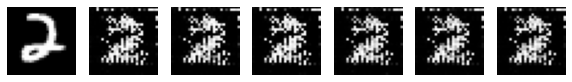

Epoch 4591 g_loss= 3.3731148 d_loss= 0.03523014 real_acc= 1.0 fake_acc= 1.0
Epoch 4592 g_loss= 3.3858144 d_loss= 0.034685537 real_acc= 1.0 fake_acc= 1.0
Epoch 4593 g_loss= 3.4056442 d_loss= 0.03397227 real_acc= 1.0 fake_acc= 1.0
Epoch 4594 g_loss= 3.4192114 d_loss= 0.033535145 real_acc= 1.0 fake_acc= 1.0
Epoch 4595 g_loss= 3.4414055 d_loss= 0.032784585 real_acc= 1.0 fake_acc= 1.0
Epoch 4596 g_loss= 3.4267063 d_loss= 0.033302866 real_acc= 1.0 fake_acc= 1.0
Epoch 4597 g_loss= 3.456339 d_loss= 0.032312136 real_acc= 1.0 fake_acc= 1.0
Epoch 4598 g_loss= 3.4626086 d_loss= 0.032005843 real_acc= 1.0 fake_acc= 1.0
Epoch 4599 g_loss= 3.4588635 d_loss= 0.03218516 real_acc= 1.0 fake_acc= 1.0
Epoch 4600 g_loss= 3.4942756 d_loss= 0.031158684 real_acc= 1.0 fake_acc= 1.0


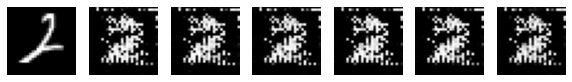

Epoch 4601 g_loss= 3.458994 d_loss= 0.032159645 real_acc= 1.0 fake_acc= 1.0
Epoch 4602 g_loss= 3.5004838 d_loss= 0.030908488 real_acc= 1.0 fake_acc= 1.0
Epoch 4603 g_loss= 3.4807127 d_loss= 0.03143205 real_acc= 1.0 fake_acc= 1.0
Epoch 4604 g_loss= 3.517205 d_loss= 0.030329749 real_acc= 1.0 fake_acc= 1.0
Epoch 4605 g_loss= 3.5082996 d_loss= 0.030611394 real_acc= 1.0 fake_acc= 1.0
Epoch 4606 g_loss= 3.5041993 d_loss= 0.03076002 real_acc= 1.0 fake_acc= 1.0
Epoch 4607 g_loss= 3.518949 d_loss= 0.030222487 real_acc= 1.0 fake_acc= 1.0
Epoch 4608 g_loss= 3.55688 d_loss= 0.029119384 real_acc= 1.0 fake_acc= 1.0
Epoch 4609 g_loss= 3.5249152 d_loss= 0.030129569 real_acc= 1.0 fake_acc= 1.0
Epoch 4610 g_loss= 3.5464847 d_loss= 0.029540844 real_acc= 1.0 fake_acc= 1.0


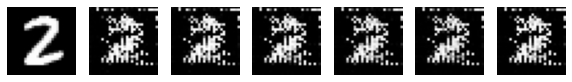

Epoch 4611 g_loss= 3.5664237 d_loss= 0.065595075 real_acc= 0.98 fake_acc= 1.0
Epoch 4612 g_loss= 3.555687 d_loss= 0.02927593 real_acc= 1.0 fake_acc= 1.0
Epoch 4613 g_loss= 3.5705879 d_loss= 0.028768426 real_acc= 1.0 fake_acc= 1.0
Epoch 4614 g_loss= 3.575486 d_loss= 0.028555414 real_acc= 1.0 fake_acc= 1.0
Epoch 4615 g_loss= 3.5308228 d_loss= 0.029991353 real_acc= 1.0 fake_acc= 1.0
Epoch 4616 g_loss= 3.5284927 d_loss= 0.029975276 real_acc= 1.0 fake_acc= 1.0
Epoch 4617 g_loss= 3.5332422 d_loss= 0.029917968 real_acc= 1.0 fake_acc= 1.0
Epoch 4618 g_loss= 3.5331168 d_loss= 0.029947782 real_acc= 1.0 fake_acc= 1.0
Epoch 4619 g_loss= 3.53375 d_loss= 0.029885886 real_acc= 1.0 fake_acc= 1.0
Epoch 4620 g_loss= 3.5291555 d_loss= 0.029948197 real_acc= 1.0 fake_acc= 1.0


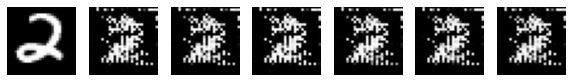

Epoch 4621 g_loss= 3.5475442 d_loss= 0.029448466 real_acc= 1.0 fake_acc= 1.0
Epoch 4622 g_loss= 3.5339038 d_loss= 0.029810857 real_acc= 1.0 fake_acc= 1.0
Epoch 4623 g_loss= 3.5354502 d_loss= 0.029731479 real_acc= 1.0 fake_acc= 1.0
Epoch 4624 g_loss= 3.5511303 d_loss= 0.029360073 real_acc= 1.0 fake_acc= 1.0
Epoch 4625 g_loss= 3.5542376 d_loss= 0.029201584 real_acc= 1.0 fake_acc= 1.0
Epoch 4626 g_loss= 3.5372694 d_loss= 0.02970387 real_acc= 1.0 fake_acc= 1.0
Epoch 4627 g_loss= 3.5590243 d_loss= 0.029102435 real_acc= 1.0 fake_acc= 1.0
Epoch 4628 g_loss= 3.5568943 d_loss= 0.02915727 real_acc= 1.0 fake_acc= 1.0
Epoch 4629 g_loss= 3.5611768 d_loss= 0.028990787 real_acc= 1.0 fake_acc= 1.0
Epoch 4630 g_loss= 3.5676029 d_loss= 0.028830683 real_acc= 1.0 fake_acc= 1.0


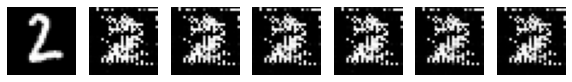

Epoch 4631 g_loss= 3.5777838 d_loss= 0.028592791 real_acc= 1.0 fake_acc= 1.0
Epoch 4632 g_loss= 3.5502348 d_loss= 0.029324967 real_acc= 1.0 fake_acc= 1.0
Epoch 4633 g_loss= 3.61024 d_loss= 0.0275629 real_acc= 1.0 fake_acc= 1.0
Epoch 4634 g_loss= 3.6100626 d_loss= 0.027659213 real_acc= 1.0 fake_acc= 1.0
Epoch 4635 g_loss= 3.5855541 d_loss= 0.02828817 real_acc= 1.0 fake_acc= 1.0
Epoch 4636 g_loss= 3.6150408 d_loss= 0.027496466 real_acc= 1.0 fake_acc= 1.0
Epoch 4637 g_loss= 3.606722 d_loss= 0.027648032 real_acc= 1.0 fake_acc= 1.0
Epoch 4638 g_loss= 3.6445255 d_loss= 0.026612163 real_acc= 1.0 fake_acc= 1.0
Epoch 4639 g_loss= 3.6275709 d_loss= 0.02710465 real_acc= 1.0 fake_acc= 1.0
Epoch 4640 g_loss= 3.642375 d_loss= 0.026692806 real_acc= 1.0 fake_acc= 1.0


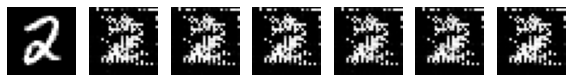

Epoch 4641 g_loss= 3.6994498 d_loss= 0.025277346 real_acc= 1.0 fake_acc= 1.0
Epoch 4642 g_loss= 3.6740868 d_loss= 0.025930589 real_acc= 1.0 fake_acc= 1.0
Epoch 4643 g_loss= 3.6376166 d_loss= 0.026883438 real_acc= 1.0 fake_acc= 1.0
Epoch 4644 g_loss= 3.6841714 d_loss= 0.025594318 real_acc= 1.0 fake_acc= 1.0
Epoch 4645 g_loss= 3.7001343 d_loss= 0.025253199 real_acc= 1.0 fake_acc= 1.0
Epoch 4646 g_loss= 3.6781313 d_loss= 0.025789661 real_acc= 1.0 fake_acc= 1.0
Epoch 4647 g_loss= 3.7269547 d_loss= 0.024526441 real_acc= 1.0 fake_acc= 1.0
Epoch 4648 g_loss= 3.704467 d_loss= 0.025132768 real_acc= 1.0 fake_acc= 1.0
Epoch 4649 g_loss= 3.7298517 d_loss= 0.02444122 real_acc= 1.0 fake_acc= 1.0
Epoch 4650 g_loss= 3.7313657 d_loss= 0.02450516 real_acc= 1.0 fake_acc= 1.0


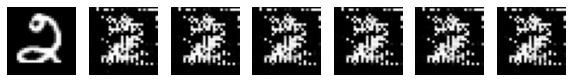

Epoch 4651 g_loss= 3.7417645 d_loss= 0.024181778 real_acc= 1.0 fake_acc= 1.0
Epoch 4652 g_loss= 3.7149084 d_loss= 0.024821522 real_acc= 1.0 fake_acc= 1.0
Epoch 4653 g_loss= 3.7292855 d_loss= 0.024436517 real_acc= 1.0 fake_acc= 1.0
Epoch 4654 g_loss= 3.7420092 d_loss= 0.024157587 real_acc= 1.0 fake_acc= 1.0
Epoch 4655 g_loss= 3.748504 d_loss= 0.023989601 real_acc= 1.0 fake_acc= 1.0
Epoch 4656 g_loss= 3.7811248 d_loss= 0.023236837 real_acc= 1.0 fake_acc= 1.0
Epoch 4657 g_loss= 3.7776368 d_loss= 0.023318794 real_acc= 1.0 fake_acc= 1.0
Epoch 4658 g_loss= 3.7923565 d_loss= 0.023040662 real_acc= 1.0 fake_acc= 1.0
Epoch 4659 g_loss= 3.8210418 d_loss= 0.022344401 real_acc= 1.0 fake_acc= 1.0
Epoch 4660 g_loss= 3.8024213 d_loss= 0.022686403 real_acc= 1.0 fake_acc= 1.0


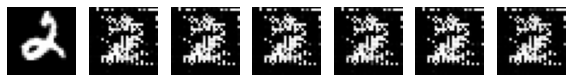

Epoch 4661 g_loss= 3.840146 d_loss= 0.021930607 real_acc= 1.0 fake_acc= 1.0
Epoch 4662 g_loss= 3.8389962 d_loss= 0.021887802 real_acc= 1.0 fake_acc= 1.0
Epoch 4663 g_loss= 3.866358 d_loss= 0.021319352 real_acc= 1.0 fake_acc= 1.0
Epoch 4664 g_loss= 3.839718 d_loss= 0.021885023 real_acc= 1.0 fake_acc= 1.0
Epoch 4665 g_loss= 3.8026962 d_loss= 0.022747407 real_acc= 1.0 fake_acc= 1.0
Epoch 4666 g_loss= 3.8541753 d_loss= 0.021573646 real_acc= 1.0 fake_acc= 1.0
Epoch 4667 g_loss= 3.851583 d_loss= 0.021651464 real_acc= 1.0 fake_acc= 1.0
Epoch 4668 g_loss= 3.8768551 d_loss= 0.021061813 real_acc= 1.0 fake_acc= 1.0
Epoch 4669 g_loss= 3.8474865 d_loss= 0.02175233 real_acc= 1.0 fake_acc= 1.0
Epoch 4670 g_loss= 3.9000368 d_loss= 0.02061488 real_acc= 1.0 fake_acc= 1.0


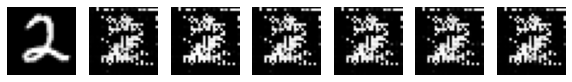

Epoch 4671 g_loss= 3.8848526 d_loss= 0.020974126 real_acc= 1.0 fake_acc= 1.0
Epoch 4672 g_loss= 3.924054 d_loss= 0.020114211 real_acc= 1.0 fake_acc= 1.0
Epoch 4673 g_loss= 3.9141116 d_loss= 0.020365529 real_acc= 1.0 fake_acc= 1.0
Epoch 4674 g_loss= 3.929113 d_loss= 0.020025874 real_acc= 1.0 fake_acc= 1.0
Epoch 4675 g_loss= 3.9490867 d_loss= 0.019703219 real_acc= 1.0 fake_acc= 1.0
Epoch 4676 g_loss= 3.9528565 d_loss= 0.019539006 real_acc= 1.0 fake_acc= 1.0
Epoch 4677 g_loss= 3.9768121 d_loss= 0.019078575 real_acc= 1.0 fake_acc= 1.0
Epoch 4678 g_loss= 3.9426298 d_loss= 0.019689534 real_acc= 1.0 fake_acc= 1.0
Epoch 4679 g_loss= 3.9774203 d_loss= 0.019052181 real_acc= 1.0 fake_acc= 1.0
Epoch 4680 g_loss= 3.9981034 d_loss= 0.018752174 real_acc= 1.0 fake_acc= 1.0


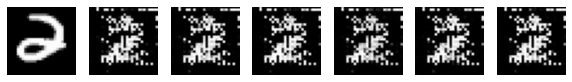

Epoch 4681 g_loss= 3.9607272 d_loss= 0.019405441 real_acc= 1.0 fake_acc= 1.0
Epoch 4682 g_loss= 3.9664416 d_loss= 0.019291125 real_acc= 1.0 fake_acc= 1.0
Epoch 4683 g_loss= 4.0099826 d_loss= 0.018563924 real_acc= 1.0 fake_acc= 1.0
Epoch 4684 g_loss= 3.9978542 d_loss= 0.018694453 real_acc= 1.0 fake_acc= 1.0
Epoch 4685 g_loss= 3.9996302 d_loss= 0.018648487 real_acc= 1.0 fake_acc= 1.0
Epoch 4686 g_loss= 4.0595503 d_loss= 0.017553173 real_acc= 1.0 fake_acc= 1.0
Epoch 4687 g_loss= 4.012633 d_loss= 0.018403571 real_acc= 1.0 fake_acc= 1.0
Epoch 4688 g_loss= 4.041083 d_loss= 0.017872082 real_acc= 1.0 fake_acc= 1.0
Epoch 4689 g_loss= 4.053356 d_loss= 0.01766802 real_acc= 1.0 fake_acc= 1.0
Epoch 4690 g_loss= 4.0621934 d_loss= 0.0175321 real_acc= 1.0 fake_acc= 1.0


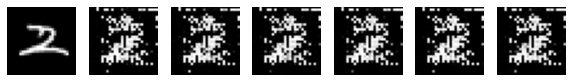

Epoch 4691 g_loss= 4.071851 d_loss= 0.017350206 real_acc= 1.0 fake_acc= 1.0
Epoch 4692 g_loss= 4.0779247 d_loss= 0.017262165 real_acc= 1.0 fake_acc= 1.0
Epoch 4693 g_loss= 4.0807304 d_loss= 0.01716416 real_acc= 1.0 fake_acc= 1.0
Epoch 4694 g_loss= 4.0648727 d_loss= 0.017498612 real_acc= 1.0 fake_acc= 1.0
Epoch 4695 g_loss= 4.085421 d_loss= 0.017156033 real_acc= 1.0 fake_acc= 1.0
Epoch 4696 g_loss= 4.083081 d_loss= 0.017173918 real_acc= 1.0 fake_acc= 1.0
Epoch 4697 g_loss= 4.1182055 d_loss= 0.016524816 real_acc= 1.0 fake_acc= 1.0
Epoch 4698 g_loss= 4.0931516 d_loss= 0.016948845 real_acc= 1.0 fake_acc= 1.0
Epoch 4699 g_loss= 4.125575 d_loss= 0.016443841 real_acc= 1.0 fake_acc= 1.0
Epoch 4700 g_loss= 4.1310735 d_loss= 0.016358174 real_acc= 1.0 fake_acc= 1.0


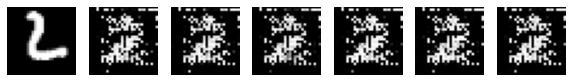

Epoch 4701 g_loss= 4.1051455 d_loss= 0.016773371 real_acc= 1.0 fake_acc= 1.0
Epoch 4702 g_loss= 4.138547 d_loss= 0.016176475 real_acc= 1.0 fake_acc= 1.0
Epoch 4703 g_loss= 4.1460905 d_loss= 0.016068887 real_acc= 1.0 fake_acc= 1.0
Epoch 4704 g_loss= 4.1563973 d_loss= 0.015961342 real_acc= 1.0 fake_acc= 1.0
Epoch 4705 g_loss= 4.149921 d_loss= 0.016117789 real_acc= 1.0 fake_acc= 1.0
Epoch 4706 g_loss= 4.1660466 d_loss= 0.015783671 real_acc= 1.0 fake_acc= 1.0
Epoch 4707 g_loss= 4.1594715 d_loss= 0.015886774 real_acc= 1.0 fake_acc= 1.0
Epoch 4708 g_loss= 4.1496096 d_loss= 0.01607185 real_acc= 1.0 fake_acc= 1.0
Epoch 4709 g_loss= 4.1770215 d_loss= 0.01559876 real_acc= 1.0 fake_acc= 1.0
Epoch 4710 g_loss= 4.179419 d_loss= 0.015539826 real_acc= 1.0 fake_acc= 1.0


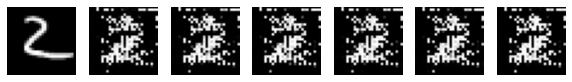

Epoch 4711 g_loss= 4.1738205 d_loss= 0.015639486 real_acc= 1.0 fake_acc= 1.0
Epoch 4712 g_loss= 4.1987767 d_loss= 0.0152488565 real_acc= 1.0 fake_acc= 1.0
Epoch 4713 g_loss= 4.2033935 d_loss= 0.015158621 real_acc= 1.0 fake_acc= 1.0
Epoch 4714 g_loss= 4.214925 d_loss= 0.014999488 real_acc= 1.0 fake_acc= 1.0
Epoch 4715 g_loss= 4.215636 d_loss= 0.015013244 real_acc= 1.0 fake_acc= 1.0
Epoch 4716 g_loss= 4.234137 d_loss= 0.014723599 real_acc= 1.0 fake_acc= 1.0
Epoch 4717 g_loss= 4.2139072 d_loss= 0.015062505 real_acc= 1.0 fake_acc= 1.0
Epoch 4718 g_loss= 4.2584887 d_loss= 0.014402429 real_acc= 1.0 fake_acc= 1.0
Epoch 4719 g_loss= 4.231145 d_loss= 0.014774858 real_acc= 1.0 fake_acc= 1.0
Epoch 4720 g_loss= 4.243791 d_loss= 0.01460637 real_acc= 1.0 fake_acc= 1.0


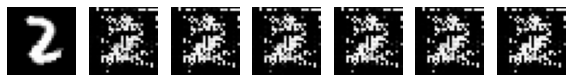

Epoch 4721 g_loss= 4.2487736 d_loss= 0.014547885 real_acc= 1.0 fake_acc= 1.0
Epoch 4722 g_loss= 4.2596464 d_loss= 0.0143324435 real_acc= 1.0 fake_acc= 1.0
Epoch 4723 g_loss= 4.272897 d_loss= 0.0141382795 real_acc= 1.0 fake_acc= 1.0
Epoch 4724 g_loss= 4.291496 d_loss= 0.013896444 real_acc= 1.0 fake_acc= 1.0
Epoch 4725 g_loss= 4.2774653 d_loss= 0.014099055 real_acc= 1.0 fake_acc= 1.0
Epoch 4726 g_loss= 4.3025403 d_loss= 0.0137353875 real_acc= 1.0 fake_acc= 1.0
Epoch 4727 g_loss= 4.2996416 d_loss= 0.013823016 real_acc= 1.0 fake_acc= 1.0
Epoch 4728 g_loss= 4.3052154 d_loss= 0.013763952 real_acc= 1.0 fake_acc= 1.0
Epoch 4729 g_loss= 4.3299847 d_loss= 0.0134066725 real_acc= 1.0 fake_acc= 1.0
Epoch 4730 g_loss= 4.286701 d_loss= 0.013987254 real_acc= 1.0 fake_acc= 1.0


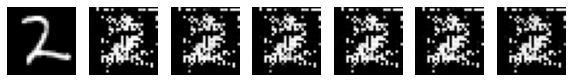

Epoch 4731 g_loss= 4.3210344 d_loss= 0.0147690475 real_acc= 1.0 fake_acc= 1.0
Epoch 4732 g_loss= 4.2636366 d_loss= 0.014295639 real_acc= 1.0 fake_acc= 1.0
Epoch 4733 g_loss= 4.3401365 d_loss= 0.42419037 real_acc= 0.98 fake_acc= 1.0
Epoch 4734 g_loss= 4.2844925 d_loss= 0.014026098 real_acc= 1.0 fake_acc= 1.0
Epoch 4735 g_loss= 4.208916 d_loss= 0.015170472 real_acc= 1.0 fake_acc= 1.0
Epoch 4736 g_loss= 4.2054625 d_loss= 0.015193692 real_acc= 1.0 fake_acc= 1.0
Epoch 4737 g_loss= 4.189563 d_loss= 0.0153697105 real_acc= 1.0 fake_acc= 1.0
Epoch 4738 g_loss= 4.1410584 d_loss= 0.016221741 real_acc= 1.0 fake_acc= 1.0
Epoch 4739 g_loss= 4.151689 d_loss= 0.016034996 real_acc= 1.0 fake_acc= 1.0
Epoch 4740 g_loss= 4.103184 d_loss= 0.016834237 real_acc= 1.0 fake_acc= 1.0


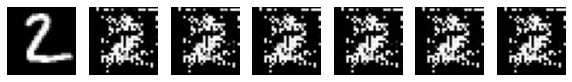

Epoch 4741 g_loss= 4.064407 d_loss= 0.017496347 real_acc= 1.0 fake_acc= 1.0
Epoch 4742 g_loss= 4.104038 d_loss= 0.01679914 real_acc= 1.0 fake_acc= 1.0
Epoch 4743 g_loss= 4.091274 d_loss= 0.01707703 real_acc= 1.0 fake_acc= 1.0
Epoch 4744 g_loss= 4.040347 d_loss= 0.017906073 real_acc= 1.0 fake_acc= 1.0
Epoch 4745 g_loss= 4.041975 d_loss= 0.017834552 real_acc= 1.0 fake_acc= 1.0
Epoch 4746 g_loss= 4.054473 d_loss= 0.017624395 real_acc= 1.0 fake_acc= 1.0
Epoch 4747 g_loss= 4.018175 d_loss= 0.018357495 real_acc= 1.0 fake_acc= 1.0
Epoch 4748 g_loss= 4.0273647 d_loss= 0.018182565 real_acc= 1.0 fake_acc= 1.0
Epoch 4749 g_loss= 4.022152 d_loss= 0.018238345 real_acc= 1.0 fake_acc= 1.0
Epoch 4750 g_loss= 4.0005326 d_loss= 0.018664539 real_acc= 1.0 fake_acc= 1.0


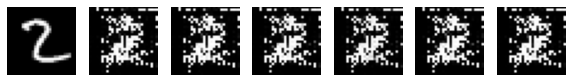

Epoch 4751 g_loss= 4.002192 d_loss= 0.018590473 real_acc= 1.0 fake_acc= 1.0
Epoch 4752 g_loss= 4.0444965 d_loss= 0.017815156 real_acc= 1.0 fake_acc= 1.0
Epoch 4753 g_loss= 4.019173 d_loss= 0.018260686 real_acc= 1.0 fake_acc= 1.0
Epoch 4754 g_loss= 3.9978845 d_loss= 0.01868779 real_acc= 1.0 fake_acc= 1.0
Epoch 4755 g_loss= 4.0223722 d_loss= 0.018246075 real_acc= 1.0 fake_acc= 1.0
Epoch 4756 g_loss= 4.0454087 d_loss= 0.01781031 real_acc= 1.0 fake_acc= 1.0
Epoch 4757 g_loss= 4.0274367 d_loss= 0.018089505 real_acc= 1.0 fake_acc= 1.0
Epoch 4758 g_loss= 4.024462 d_loss= 0.018194355 real_acc= 1.0 fake_acc= 1.0
Epoch 4759 g_loss= 4.057814 d_loss= 0.017580599 real_acc= 1.0 fake_acc= 1.0
Epoch 4760 g_loss= 3.9868498 d_loss= 0.018883351 real_acc= 1.0 fake_acc= 1.0


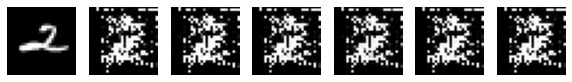

Epoch 4761 g_loss= 4.046303 d_loss= 0.01787357 real_acc= 1.0 fake_acc= 1.0
Epoch 4762 g_loss= 4.029099 d_loss= 0.018070351 real_acc= 1.0 fake_acc= 1.0
Epoch 4763 g_loss= 4.0252905 d_loss= 0.018176971 real_acc= 1.0 fake_acc= 1.0
Epoch 4764 g_loss= 4.0308323 d_loss= 0.018031312 real_acc= 1.0 fake_acc= 1.0
Epoch 4765 g_loss= 4.0102243 d_loss= 0.01848852 real_acc= 1.0 fake_acc= 1.0
Epoch 4766 g_loss= 4.0799017 d_loss= 0.017204396 real_acc= 1.0 fake_acc= 1.0
Epoch 4767 g_loss= 4.066535 d_loss= 0.01742689 real_acc= 1.0 fake_acc= 1.0
Epoch 4768 g_loss= 4.0657854 d_loss= 0.017379763 real_acc= 1.0 fake_acc= 1.0
Epoch 4769 g_loss= 4.0881085 d_loss= 0.017070428 real_acc= 1.0 fake_acc= 1.0
Epoch 4770 g_loss= 4.057365 d_loss= 0.017607741 real_acc= 1.0 fake_acc= 1.0


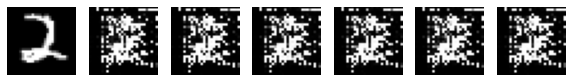

Epoch 4771 g_loss= 4.095974 d_loss= 0.016897708 real_acc= 1.0 fake_acc= 1.0
Epoch 4772 g_loss= 4.0824866 d_loss= 0.017134171 real_acc= 1.0 fake_acc= 1.0
Epoch 4773 g_loss= 4.100665 d_loss= 0.016836949 real_acc= 1.0 fake_acc= 1.0
Epoch 4774 g_loss= 4.1067424 d_loss= 0.016762936 real_acc= 1.0 fake_acc= 1.0
Epoch 4775 g_loss= 4.1037107 d_loss= 0.016805174 real_acc= 1.0 fake_acc= 1.0
Epoch 4776 g_loss= 4.0716405 d_loss= 0.017376805 real_acc= 1.0 fake_acc= 1.0
Epoch 4777 g_loss= 4.115272 d_loss= 0.016620042 real_acc= 1.0 fake_acc= 1.0
Epoch 4778 g_loss= 4.091271 d_loss= 0.017022848 real_acc= 1.0 fake_acc= 1.0
Epoch 4779 g_loss= 4.152472 d_loss= 0.01598801 real_acc= 1.0 fake_acc= 1.0
Epoch 4780 g_loss= 4.1222777 d_loss= 0.016486762 real_acc= 1.0 fake_acc= 1.0


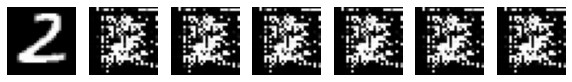

Epoch 4781 g_loss= 4.1331234 d_loss= 0.016348053 real_acc= 1.0 fake_acc= 1.0
Epoch 4782 g_loss= 4.1504607 d_loss= 0.015994115 real_acc= 1.0 fake_acc= 1.0
Epoch 4783 g_loss= 4.122561 d_loss= 0.01648273 real_acc= 1.0 fake_acc= 1.0
Epoch 4784 g_loss= 4.16685 d_loss= 0.015798964 real_acc= 1.0 fake_acc= 1.0
Epoch 4785 g_loss= 4.2013087 d_loss= 0.015204669 real_acc= 1.0 fake_acc= 1.0
Epoch 4786 g_loss= 4.188192 d_loss= 0.015381341 real_acc= 1.0 fake_acc= 1.0
Epoch 4787 g_loss= 4.1657867 d_loss= 0.015789228 real_acc= 1.0 fake_acc= 1.0
Epoch 4788 g_loss= 4.1957035 d_loss= 0.015353029 real_acc= 1.0 fake_acc= 1.0
Epoch 4789 g_loss= 4.1799335 d_loss= 0.015578907 real_acc= 1.0 fake_acc= 1.0
Epoch 4790 g_loss= 4.2001567 d_loss= 0.015204769 real_acc= 1.0 fake_acc= 1.0


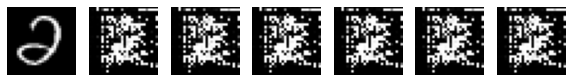

Epoch 4791 g_loss= 4.2198076 d_loss= 0.014990511 real_acc= 1.0 fake_acc= 1.0
Epoch 4792 g_loss= 4.1873236 d_loss= 0.015446715 real_acc= 1.0 fake_acc= 1.0
Epoch 4793 g_loss= 4.2052593 d_loss= 0.015156288 real_acc= 1.0 fake_acc= 1.0
Epoch 4794 g_loss= 4.2095613 d_loss= 0.015125484 real_acc= 1.0 fake_acc= 1.0
Epoch 4795 g_loss= 4.2561555 d_loss= 0.014426567 real_acc= 1.0 fake_acc= 1.0
Epoch 4796 g_loss= 4.254526 d_loss= 0.014397835 real_acc= 1.0 fake_acc= 1.0
Epoch 4797 g_loss= 4.267821 d_loss= 0.014321518 real_acc= 1.0 fake_acc= 1.0
Epoch 4798 g_loss= 4.2635207 d_loss= 0.014343389 real_acc= 1.0 fake_acc= 1.0
Epoch 4799 g_loss= 4.2950654 d_loss= 0.013899759 real_acc= 1.0 fake_acc= 1.0
Epoch 4800 g_loss= 4.257628 d_loss= 0.014389242 real_acc= 1.0 fake_acc= 1.0


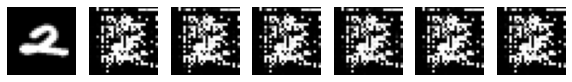

Epoch 4801 g_loss= 4.301832 d_loss= 0.013763611 real_acc= 1.0 fake_acc= 1.0
Epoch 4802 g_loss= 4.272062 d_loss= 0.014201461 real_acc= 1.0 fake_acc= 1.0
Epoch 4803 g_loss= 4.291566 d_loss= 0.013898567 real_acc= 1.0 fake_acc= 1.0
Epoch 4804 g_loss= 4.3303847 d_loss= 0.013351265 real_acc= 1.0 fake_acc= 1.0
Epoch 4805 g_loss= 4.313954 d_loss= 0.013657399 real_acc= 1.0 fake_acc= 1.0
Epoch 4806 g_loss= 4.319405 d_loss= 0.013514613 real_acc= 1.0 fake_acc= 1.0
Epoch 4807 g_loss= 4.2975855 d_loss= 0.013839888 real_acc= 1.0 fake_acc= 1.0
Epoch 4808 g_loss= 4.313496 d_loss= 0.01362544 real_acc= 1.0 fake_acc= 1.0
Epoch 4809 g_loss= 4.3547487 d_loss= 0.013136705 real_acc= 1.0 fake_acc= 1.0
Epoch 4810 g_loss= 4.3769073 d_loss= 0.012850655 real_acc= 1.0 fake_acc= 1.0


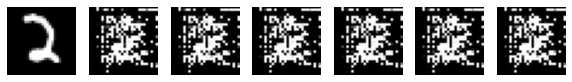

Epoch 4811 g_loss= 4.38106 d_loss= 0.012709499 real_acc= 1.0 fake_acc= 1.0
Epoch 4812 g_loss= 4.3817964 d_loss= 0.012720597 real_acc= 1.0 fake_acc= 1.0
Epoch 4813 g_loss= 4.3879623 d_loss= 0.012609244 real_acc= 1.0 fake_acc= 1.0
Epoch 4814 g_loss= 4.3696837 d_loss= 0.012854786 real_acc= 1.0 fake_acc= 1.0
Epoch 4815 g_loss= 4.3599977 d_loss= 0.012989751 real_acc= 1.0 fake_acc= 1.0
Epoch 4816 g_loss= 4.3469954 d_loss= 0.013173021 real_acc= 1.0 fake_acc= 1.0
Epoch 4817 g_loss= 4.4337826 d_loss= 0.012092051 real_acc= 1.0 fake_acc= 1.0
Epoch 4818 g_loss= 4.4130416 d_loss= 0.012292346 real_acc= 1.0 fake_acc= 1.0
Epoch 4819 g_loss= 4.427173 d_loss= 0.0121426275 real_acc= 1.0 fake_acc= 1.0
Epoch 4820 g_loss= 4.4182944 d_loss= 0.012217878 real_acc= 1.0 fake_acc= 1.0


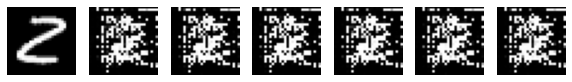

Epoch 4821 g_loss= 4.4572954 d_loss= 0.011811543 real_acc= 1.0 fake_acc= 1.0
Epoch 4822 g_loss= 4.4472237 d_loss= 0.011909008 real_acc= 1.0 fake_acc= 1.0
Epoch 4823 g_loss= 4.422775 d_loss= 0.012182156 real_acc= 1.0 fake_acc= 1.0
Epoch 4824 g_loss= 4.4704604 d_loss= 0.011607201 real_acc= 1.0 fake_acc= 1.0
Epoch 4825 g_loss= 4.4607115 d_loss= 0.0117169395 real_acc= 1.0 fake_acc= 1.0
Epoch 4826 g_loss= 4.4802895 d_loss= 0.01152715 real_acc= 1.0 fake_acc= 1.0
Epoch 4827 g_loss= 4.4887733 d_loss= 0.011426467 real_acc= 1.0 fake_acc= 1.0
Epoch 4828 g_loss= 4.4882936 d_loss= 0.01145582 real_acc= 1.0 fake_acc= 1.0
Epoch 4829 g_loss= 4.4893055 d_loss= 0.011397961 real_acc= 1.0 fake_acc= 1.0
Epoch 4830 g_loss= 4.5234904 d_loss= 0.011000889 real_acc= 1.0 fake_acc= 1.0


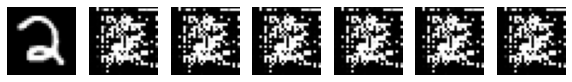

Epoch 4831 g_loss= 4.4641223 d_loss= 0.011670197 real_acc= 1.0 fake_acc= 1.0
Epoch 4832 g_loss= 4.5113316 d_loss= 0.011149722 real_acc= 1.0 fake_acc= 1.0
Epoch 4833 g_loss= 4.5555134 d_loss= 0.010674357 real_acc= 1.0 fake_acc= 1.0
Epoch 4834 g_loss= 4.526485 d_loss= 0.010999855 real_acc= 1.0 fake_acc= 1.0
Epoch 4835 g_loss= 4.5394664 d_loss= 0.0108552715 real_acc= 1.0 fake_acc= 1.0
Epoch 4836 g_loss= 4.5699034 d_loss= 0.010525215 real_acc= 1.0 fake_acc= 1.0
Epoch 4837 g_loss= 4.575749 d_loss= 0.010493274 real_acc= 1.0 fake_acc= 1.0
Epoch 4838 g_loss= 4.5970592 d_loss= 0.010257312 real_acc= 1.0 fake_acc= 1.0
Epoch 4839 g_loss= 4.557646 d_loss= 0.010655875 real_acc= 1.0 fake_acc= 1.0
Epoch 4840 g_loss= 4.5610595 d_loss= 0.01059662 real_acc= 1.0 fake_acc= 1.0


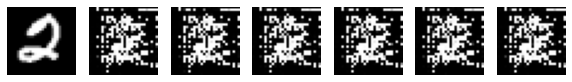

Epoch 4841 g_loss= 4.583963 d_loss= 0.010381762 real_acc= 1.0 fake_acc= 1.0
Epoch 4842 g_loss= 4.560823 d_loss= 0.01067002 real_acc= 1.0 fake_acc= 1.0
Epoch 4843 g_loss= 4.5884686 d_loss= 0.010326906 real_acc= 1.0 fake_acc= 1.0
Epoch 4844 g_loss= 4.5832696 d_loss= 0.01041149 real_acc= 1.0 fake_acc= 1.0
Epoch 4845 g_loss= 4.619069 d_loss= 0.0100000445 real_acc= 1.0 fake_acc= 1.0
Epoch 4846 g_loss= 4.592561 d_loss= 0.0103164045 real_acc= 1.0 fake_acc= 1.0
Epoch 4847 g_loss= 4.619127 d_loss= 0.010011477 real_acc= 1.0 fake_acc= 1.0
Epoch 4848 g_loss= 4.595464 d_loss= 0.01025571 real_acc= 1.0 fake_acc= 1.0
Epoch 4849 g_loss= 4.6456385 d_loss= 0.0097864065 real_acc= 1.0 fake_acc= 1.0
Epoch 4850 g_loss= 4.5898204 d_loss= 0.010299905 real_acc= 1.0 fake_acc= 1.0


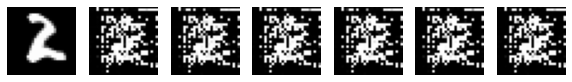

Epoch 4851 g_loss= 4.659958 d_loss= 0.009638403 real_acc= 1.0 fake_acc= 1.0
Epoch 4852 g_loss= 4.625336 d_loss= 0.00995513 real_acc= 1.0 fake_acc= 1.0
Epoch 4853 g_loss= 4.6583486 d_loss= 0.009669464 real_acc= 1.0 fake_acc= 1.0
Epoch 4854 g_loss= 4.7138653 d_loss= 0.009069703 real_acc= 1.0 fake_acc= 1.0
Epoch 4855 g_loss= 4.652894 d_loss= 0.009655 real_acc= 1.0 fake_acc= 1.0
Epoch 4856 g_loss= 4.666495 d_loss= 0.009540227 real_acc= 1.0 fake_acc= 1.0
Epoch 4857 g_loss= 4.634753 d_loss= 0.00990644 real_acc= 1.0 fake_acc= 1.0
Epoch 4858 g_loss= 4.678376 d_loss= 0.009443449 real_acc= 1.0 fake_acc= 1.0
Epoch 4859 g_loss= 4.7147593 d_loss= 0.009096855 real_acc= 1.0 fake_acc= 1.0
Epoch 4860 g_loss= 4.6827836 d_loss= 0.009390613 real_acc= 1.0 fake_acc= 1.0


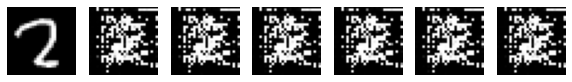

Epoch 4861 g_loss= 4.6634426 d_loss= 0.009566686 real_acc= 1.0 fake_acc= 1.0
Epoch 4862 g_loss= 4.745137 d_loss= 0.00881545 real_acc= 1.0 fake_acc= 1.0
Epoch 4863 g_loss= 4.693592 d_loss= 0.009285478 real_acc= 1.0 fake_acc= 1.0
Epoch 4864 g_loss= 4.682065 d_loss= 0.009406553 real_acc= 1.0 fake_acc= 1.0
Epoch 4865 g_loss= 4.7093263 d_loss= 0.009149223 real_acc= 1.0 fake_acc= 1.0
Epoch 4866 g_loss= 4.730979 d_loss= 0.008994103 real_acc= 1.0 fake_acc= 1.0
Epoch 4867 g_loss= 4.72545 d_loss= 0.009019903 real_acc= 1.0 fake_acc= 1.0
Epoch 4868 g_loss= 4.746763 d_loss= 0.008820731 real_acc= 1.0 fake_acc= 1.0
Epoch 4869 g_loss= 4.7563057 d_loss= 0.008731597 real_acc= 1.0 fake_acc= 1.0
Epoch 4870 g_loss= 4.757765 d_loss= 0.008728566 real_acc= 1.0 fake_acc= 1.0


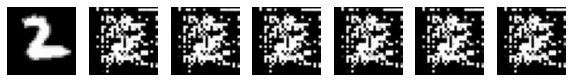

Epoch 4871 g_loss= 4.7612677 d_loss= 0.008660797 real_acc= 1.0 fake_acc= 1.0
Epoch 4872 g_loss= 4.7588067 d_loss= 0.008728884 real_acc= 1.0 fake_acc= 1.0
Epoch 4873 g_loss= 4.7632136 d_loss= 0.00867898 real_acc= 1.0 fake_acc= 1.0
Epoch 4874 g_loss= 4.79498 d_loss= 0.008434661 real_acc= 1.0 fake_acc= 1.0
Epoch 4875 g_loss= 4.7983656 d_loss= 0.00837654 real_acc= 1.0 fake_acc= 1.0
Epoch 4876 g_loss= 4.788174 d_loss= 0.008464678 real_acc= 1.0 fake_acc= 1.0
Epoch 4877 g_loss= 4.796522 d_loss= 0.0084054675 real_acc= 1.0 fake_acc= 1.0
Epoch 4878 g_loss= 4.8111973 d_loss= 0.008257089 real_acc= 1.0 fake_acc= 1.0
Epoch 4879 g_loss= 4.821125 d_loss= 0.008156164 real_acc= 1.0 fake_acc= 1.0
Epoch 4880 g_loss= 4.8459864 d_loss= 0.007956832 real_acc= 1.0 fake_acc= 1.0


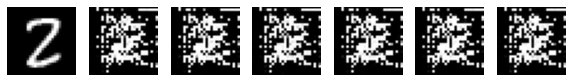

Epoch 4881 g_loss= 4.787432 d_loss= 0.0084486995 real_acc= 1.0 fake_acc= 1.0
Epoch 4882 g_loss= 4.83135 d_loss= 0.008079709 real_acc= 1.0 fake_acc= 1.0
Epoch 4883 g_loss= 4.830447 d_loss= 0.008082587 real_acc= 1.0 fake_acc= 1.0
Epoch 4884 g_loss= 4.8980503 d_loss= 0.0075380765 real_acc= 1.0 fake_acc= 1.0
Epoch 4885 g_loss= 4.856938 d_loss= 0.007897196 real_acc= 1.0 fake_acc= 1.0
Epoch 4886 g_loss= 4.8904667 d_loss= 0.0076094256 real_acc= 1.0 fake_acc= 1.0
Epoch 4887 g_loss= 4.870908 d_loss= 0.0077706366 real_acc= 1.0 fake_acc= 1.0
Epoch 4888 g_loss= 4.8309755 d_loss= 0.008105921 real_acc= 1.0 fake_acc= 1.0
Epoch 4889 g_loss= 4.882334 d_loss= 0.0076664593 real_acc= 1.0 fake_acc= 1.0
Epoch 4890 g_loss= 4.8932 d_loss= 0.0076176934 real_acc= 1.0 fake_acc= 1.0


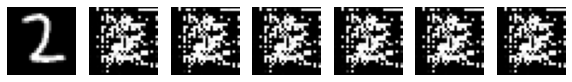

Epoch 4891 g_loss= 4.883076 d_loss= 0.0076936744 real_acc= 1.0 fake_acc= 1.0
Epoch 4892 g_loss= 4.883126 d_loss= 0.007678788 real_acc= 1.0 fake_acc= 1.0
Epoch 4893 g_loss= 4.901733 d_loss= 0.007549118 real_acc= 1.0 fake_acc= 1.0
Epoch 4894 g_loss= 4.9212465 d_loss= 0.0074014235 real_acc= 1.0 fake_acc= 1.0
Epoch 4895 g_loss= 4.884623 d_loss= 0.007690118 real_acc= 1.0 fake_acc= 1.0
Epoch 4896 g_loss= 4.9103847 d_loss= 0.007479936 real_acc= 1.0 fake_acc= 1.0
Epoch 4897 g_loss= 4.920975 d_loss= 0.007404448 real_acc= 1.0 fake_acc= 1.0
Epoch 4898 g_loss= 4.9182563 d_loss= 0.0074439035 real_acc= 1.0 fake_acc= 1.0
Epoch 4899 g_loss= 4.943343 d_loss= 0.0072352947 real_acc= 1.0 fake_acc= 1.0
Epoch 4900 g_loss= 4.938467 d_loss= 0.007278571 real_acc= 1.0 fake_acc= 1.0


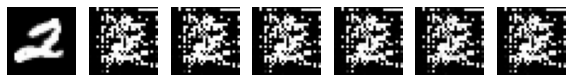

Epoch 4901 g_loss= 4.9598885 d_loss= 0.0071106316 real_acc= 1.0 fake_acc= 1.0
Epoch 4902 g_loss= 4.9661627 d_loss= 0.00711365 real_acc= 1.0 fake_acc= 1.0
Epoch 4903 g_loss= 4.9840717 d_loss= 0.0069293533 real_acc= 1.0 fake_acc= 1.0
Epoch 4904 g_loss= 4.966655 d_loss= 0.0070501124 real_acc= 1.0 fake_acc= 1.0
Epoch 4905 g_loss= 4.9544826 d_loss= 0.00714746 real_acc= 1.0 fake_acc= 1.0
Epoch 4906 g_loss= 4.9954405 d_loss= 0.006886344 real_acc= 1.0 fake_acc= 1.0
Epoch 4907 g_loss= 4.9902263 d_loss= 0.0069003887 real_acc= 1.0 fake_acc= 1.0
Epoch 4908 g_loss= 5.002226 d_loss= 0.0068144524 real_acc= 1.0 fake_acc= 1.0
Epoch 4909 g_loss= 4.964845 d_loss= 0.0070953523 real_acc= 1.0 fake_acc= 1.0
Epoch 4910 g_loss= 4.9900355 d_loss= 0.006925059 real_acc= 1.0 fake_acc= 1.0


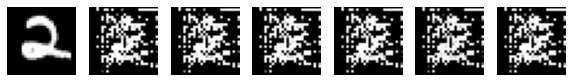

Epoch 4911 g_loss= 4.9961457 d_loss= 0.006881999 real_acc= 1.0 fake_acc= 1.0
Epoch 4912 g_loss= 5.0210752 d_loss= 0.0067309733 real_acc= 1.0 fake_acc= 1.0
Epoch 4913 g_loss= 4.973059 d_loss= 0.007057279 real_acc= 1.0 fake_acc= 1.0
Epoch 4914 g_loss= 5.01452 d_loss= 0.006737937 real_acc= 1.0 fake_acc= 1.0
Epoch 4915 g_loss= 5.008968 d_loss= 0.006783051 real_acc= 1.0 fake_acc= 1.0
Epoch 4916 g_loss= 5.00738 d_loss= 0.0067923297 real_acc= 1.0 fake_acc= 1.0
Epoch 4917 g_loss= 5.0601254 d_loss= 0.006440501 real_acc= 1.0 fake_acc= 1.0
Epoch 4918 g_loss= 5.0485206 d_loss= 0.006542435 real_acc= 1.0 fake_acc= 1.0
Epoch 4919 g_loss= 5.02233 d_loss= 0.0067379153 real_acc= 1.0 fake_acc= 1.0
Epoch 4920 g_loss= 5.0542874 d_loss= 0.0064612073 real_acc= 1.0 fake_acc= 1.0


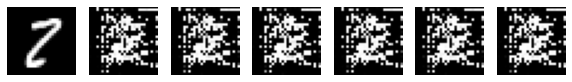

Epoch 4921 g_loss= 5.0485673 d_loss= 0.0065029077 real_acc= 1.0 fake_acc= 1.0
Epoch 4922 g_loss= 5.063184 d_loss= 0.006451225 real_acc= 1.0 fake_acc= 1.0
Epoch 4923 g_loss= 5.062659 d_loss= 0.00642654 real_acc= 1.0 fake_acc= 1.0
Epoch 4924 g_loss= 5.0472274 d_loss= 0.006540752 real_acc= 1.0 fake_acc= 1.0
Epoch 4925 g_loss= 5.0861397 d_loss= 0.006293009 real_acc= 1.0 fake_acc= 1.0
Epoch 4926 g_loss= 5.090748 d_loss= 0.0062259156 real_acc= 1.0 fake_acc= 1.0
Epoch 4927 g_loss= 5.0520635 d_loss= 0.006491491 real_acc= 1.0 fake_acc= 1.0
Epoch 4928 g_loss= 5.081391 d_loss= 0.0063188793 real_acc= 1.0 fake_acc= 1.0
Epoch 4929 g_loss= 5.1080194 d_loss= 0.006144219 real_acc= 1.0 fake_acc= 1.0
Epoch 4930 g_loss= 5.1150303 d_loss= 0.006093365 real_acc= 1.0 fake_acc= 1.0


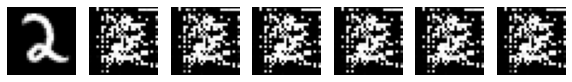

Epoch 4931 g_loss= 5.0967345 d_loss= 0.006210273 real_acc= 1.0 fake_acc= 1.0
Epoch 4932 g_loss= 5.133269 d_loss= 0.0059757405 real_acc= 1.0 fake_acc= 1.0
Epoch 4933 g_loss= 5.118479 d_loss= 0.0060664634 real_acc= 1.0 fake_acc= 1.0
Epoch 4934 g_loss= 5.143493 d_loss= 0.005921322 real_acc= 1.0 fake_acc= 1.0
Epoch 4935 g_loss= 5.115913 d_loss= 0.0061054584 real_acc= 1.0 fake_acc= 1.0
Epoch 4936 g_loss= 5.102111 d_loss= 0.0061785937 real_acc= 1.0 fake_acc= 1.0
Epoch 4937 g_loss= 5.091121 d_loss= 0.006275533 real_acc= 1.0 fake_acc= 1.0
Epoch 4938 g_loss= 5.1177397 d_loss= 0.0061250273 real_acc= 1.0 fake_acc= 1.0
Epoch 4939 g_loss= 5.114741 d_loss= 0.006078256 real_acc= 1.0 fake_acc= 1.0
Epoch 4940 g_loss= 5.1635494 d_loss= 0.0058219302 real_acc= 1.0 fake_acc= 1.0


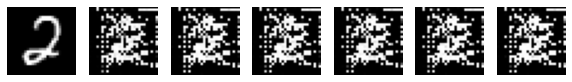

Epoch 4941 g_loss= 5.12604 d_loss= 0.006055693 real_acc= 1.0 fake_acc= 1.0
Epoch 4942 g_loss= 5.1686463 d_loss= 0.005757696 real_acc= 1.0 fake_acc= 1.0
Epoch 4943 g_loss= 5.1748223 d_loss= 0.0057374956 real_acc= 1.0 fake_acc= 1.0
Epoch 4944 g_loss= 5.1593947 d_loss= 0.0058214758 real_acc= 1.0 fake_acc= 1.0
Epoch 4945 g_loss= 5.135609 d_loss= 0.0059831496 real_acc= 1.0 fake_acc= 1.0
Epoch 4946 g_loss= 5.1719337 d_loss= 0.0057620048 real_acc= 1.0 fake_acc= 1.0
Epoch 4947 g_loss= 5.20025 d_loss= 0.005604299 real_acc= 1.0 fake_acc= 1.0
Epoch 4948 g_loss= 5.1819854 d_loss= 0.005669838 real_acc= 1.0 fake_acc= 1.0
Epoch 4949 g_loss= 5.201608 d_loss= 0.005598949 real_acc= 1.0 fake_acc= 1.0
Epoch 4950 g_loss= 5.2077856 d_loss= 0.005558378 real_acc= 1.0 fake_acc= 1.0


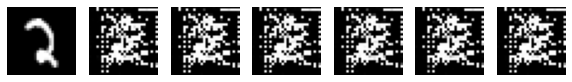

Epoch 4951 g_loss= 5.213438 d_loss= 0.005526732 real_acc= 1.0 fake_acc= 1.0
Epoch 4952 g_loss= 5.1886516 d_loss= 0.0056686485 real_acc= 1.0 fake_acc= 1.0
Epoch 4953 g_loss= 5.202203 d_loss= 0.005595416 real_acc= 1.0 fake_acc= 1.0
Epoch 4954 g_loss= 5.1819015 d_loss= 0.005689146 real_acc= 1.0 fake_acc= 1.0
Epoch 4955 g_loss= 5.20961 d_loss= 0.0055658896 real_acc= 1.0 fake_acc= 1.0
Epoch 4956 g_loss= 5.2110915 d_loss= 0.005547161 real_acc= 1.0 fake_acc= 1.0
Epoch 4957 g_loss= 5.1967564 d_loss= 0.005643163 real_acc= 1.0 fake_acc= 1.0
Epoch 4958 g_loss= 5.260913 d_loss= 0.0052903374 real_acc= 1.0 fake_acc= 1.0
Epoch 4959 g_loss= 5.228104 d_loss= 0.0054801996 real_acc= 1.0 fake_acc= 1.0
Epoch 4960 g_loss= 5.289501 d_loss= 0.0051261843 real_acc= 1.0 fake_acc= 1.0


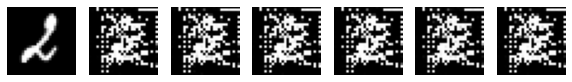

Epoch 4961 g_loss= 5.239887 d_loss= 0.0053700036 real_acc= 1.0 fake_acc= 1.0
Epoch 4962 g_loss= 5.2058434 d_loss= 0.0055727605 real_acc= 1.0 fake_acc= 1.0
Epoch 4963 g_loss= 5.2504444 d_loss= 0.0053261435 real_acc= 1.0 fake_acc= 1.0
Epoch 4964 g_loss= 5.2398815 d_loss= 0.0054093977 real_acc= 1.0 fake_acc= 1.0
Epoch 4965 g_loss= 5.2505383 d_loss= 0.0053240824 real_acc= 1.0 fake_acc= 1.0
Epoch 4966 g_loss= 5.308784 d_loss= 0.0050288616 real_acc= 1.0 fake_acc= 1.0
Epoch 4967 g_loss= 5.2493596 d_loss= 0.0053373505 real_acc= 1.0 fake_acc= 1.0
Epoch 4968 g_loss= 5.2789702 d_loss= 0.005170958 real_acc= 1.0 fake_acc= 1.0
Epoch 4969 g_loss= 5.24804 d_loss= 0.0053287805 real_acc= 1.0 fake_acc= 1.0
Epoch 4970 g_loss= 5.316031 d_loss= 0.004983847 real_acc= 1.0 fake_acc= 1.0


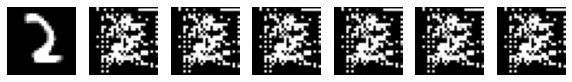

Epoch 4971 g_loss= 5.299007 d_loss= 0.0050712116 real_acc= 1.0 fake_acc= 1.0
Epoch 4972 g_loss= 5.28726 d_loss= 0.0051191193 real_acc= 1.0 fake_acc= 1.0
Epoch 4973 g_loss= 5.2935014 d_loss= 0.0051177703 real_acc= 1.0 fake_acc= 1.0
Epoch 4974 g_loss= 5.331227 d_loss= 0.004909831 real_acc= 1.0 fake_acc= 1.0
Epoch 4975 g_loss= 5.3076515 d_loss= 0.005018758 real_acc= 1.0 fake_acc= 1.0
Epoch 4976 g_loss= 5.325256 d_loss= 0.0049489792 real_acc= 1.0 fake_acc= 1.0
Epoch 4977 g_loss= 5.3055286 d_loss= 0.005037275 real_acc= 1.0 fake_acc= 1.0
Epoch 4978 g_loss= 5.329448 d_loss= 0.0049238815 real_acc= 1.0 fake_acc= 1.0
Epoch 4979 g_loss= 5.3231215 d_loss= 0.0049379813 real_acc= 1.0 fake_acc= 1.0
Epoch 4980 g_loss= 5.3130937 d_loss= 0.00501204 real_acc= 1.0 fake_acc= 1.0


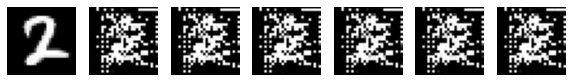

Epoch 4981 g_loss= 5.3236346 d_loss= 0.004946704 real_acc= 1.0 fake_acc= 1.0
Epoch 4982 g_loss= 5.336428 d_loss= 0.0048834966 real_acc= 1.0 fake_acc= 1.0
Epoch 4983 g_loss= 5.3256555 d_loss= 0.004950463 real_acc= 1.0 fake_acc= 1.0
Epoch 4984 g_loss= 5.3538027 d_loss= 0.0048049986 real_acc= 1.0 fake_acc= 1.0
Epoch 4985 g_loss= 5.372053 d_loss= 0.0047331755 real_acc= 1.0 fake_acc= 1.0
Epoch 4986 g_loss= 5.4267864 d_loss= 0.004462649 real_acc= 1.0 fake_acc= 1.0
Epoch 4987 g_loss= 5.3734202 d_loss= 0.0047127367 real_acc= 1.0 fake_acc= 1.0
Epoch 4988 g_loss= 5.3364534 d_loss= 0.0048785745 real_acc= 1.0 fake_acc= 1.0
Epoch 4989 g_loss= 5.37025 d_loss= 0.0047219023 real_acc= 1.0 fake_acc= 1.0
Epoch 4990 g_loss= 5.38328 d_loss= 0.0046269186 real_acc= 1.0 fake_acc= 1.0


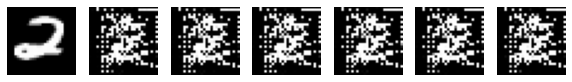

Epoch 4991 g_loss= 5.392621 d_loss= 0.0046168403 real_acc= 1.0 fake_acc= 1.0
Epoch 4992 g_loss= 5.3787746 d_loss= 0.00470847 real_acc= 1.0 fake_acc= 1.0
Epoch 4993 g_loss= 5.3716154 d_loss= 0.0047148303 real_acc= 1.0 fake_acc= 1.0
Epoch 4994 g_loss= 5.3860817 d_loss= 0.004656534 real_acc= 1.0 fake_acc= 1.0
Epoch 4995 g_loss= 5.3856378 d_loss= 0.0046743723 real_acc= 1.0 fake_acc= 1.0
Epoch 4996 g_loss= 5.394412 d_loss= 0.0046443786 real_acc= 1.0 fake_acc= 1.0
Epoch 4997 g_loss= 5.3607445 d_loss= 0.0047922544 real_acc= 1.0 fake_acc= 1.0
Epoch 4998 g_loss= 5.419063 d_loss= 0.0045041125 real_acc= 1.0 fake_acc= 1.0
Epoch 4999 g_loss= 5.408862 d_loss= 0.0045462535 real_acc= 1.0 fake_acc= 1.0
Epoch 5000 g_loss= 5.3764634 d_loss= 0.0047003347 real_acc= 1.0 fake_acc= 1.0


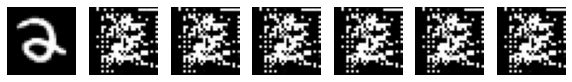

Epoch 5001 g_loss= 5.4194074 d_loss= 0.0045274664 real_acc= 1.0 fake_acc= 1.0
Epoch 5002 g_loss= 5.412755 d_loss= 0.004525058 real_acc= 1.0 fake_acc= 1.0
Epoch 5003 g_loss= 5.416465 d_loss= 0.0044992487 real_acc= 1.0 fake_acc= 1.0
Epoch 5004 g_loss= 5.425712 d_loss= 0.004471026 real_acc= 1.0 fake_acc= 1.0
Epoch 5005 g_loss= 5.4469 d_loss= 0.004375814 real_acc= 1.0 fake_acc= 1.0
Epoch 5006 g_loss= 5.4101453 d_loss= 0.0045417976 real_acc= 1.0 fake_acc= 1.0
Epoch 5007 g_loss= 5.414756 d_loss= 0.0045432784 real_acc= 1.0 fake_acc= 1.0
Epoch 5008 g_loss= 5.439542 d_loss= 0.0043940353 real_acc= 1.0 fake_acc= 1.0
Epoch 5009 g_loss= 5.4928527 d_loss= 0.0041828663 real_acc= 1.0 fake_acc= 1.0
Epoch 5010 g_loss= 5.402751 d_loss= 0.004582863 real_acc= 1.0 fake_acc= 1.0


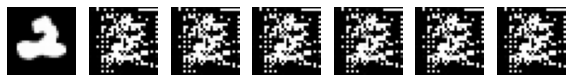

Epoch 5011 g_loss= 5.4220653 d_loss= 0.0045104455 real_acc= 1.0 fake_acc= 1.0
Epoch 5012 g_loss= 5.4496593 d_loss= 0.0043806504 real_acc= 1.0 fake_acc= 1.0
Epoch 5013 g_loss= 5.4480724 d_loss= 0.0043719276 real_acc= 1.0 fake_acc= 1.0
Epoch 5014 g_loss= 5.523656 d_loss= 0.0040795393 real_acc= 1.0 fake_acc= 1.0
Epoch 5015 g_loss= 5.507261 d_loss= 0.004133277 real_acc= 1.0 fake_acc= 1.0
Epoch 5016 g_loss= 5.4764276 d_loss= 0.004251449 real_acc= 1.0 fake_acc= 1.0
Epoch 5017 g_loss= 5.5033064 d_loss= 0.004145856 real_acc= 1.0 fake_acc= 1.0
Epoch 5018 g_loss= 5.4876866 d_loss= 0.00418937 real_acc= 1.0 fake_acc= 1.0
Epoch 5019 g_loss= 5.4914765 d_loss= 0.004197603 real_acc= 1.0 fake_acc= 1.0
Epoch 5020 g_loss= 5.463266 d_loss= 0.004306378 real_acc= 1.0 fake_acc= 1.0


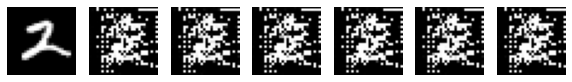

Epoch 5021 g_loss= 5.4491296 d_loss= 0.0043655727 real_acc= 1.0 fake_acc= 1.0
Epoch 5022 g_loss= 5.506343 d_loss= 0.0041094273 real_acc= 1.0 fake_acc= 1.0
Epoch 5023 g_loss= 5.463296 d_loss= 0.0043076905 real_acc= 1.0 fake_acc= 1.0
Epoch 5024 g_loss= 5.4800982 d_loss= 0.004244419 real_acc= 1.0 fake_acc= 1.0
Epoch 5025 g_loss= 5.5410686 d_loss= 0.003986652 real_acc= 1.0 fake_acc= 1.0
Epoch 5026 g_loss= 5.503716 d_loss= 0.004125579 real_acc= 1.0 fake_acc= 1.0
Epoch 5027 g_loss= 5.5466638 d_loss= 0.0039511295 real_acc= 1.0 fake_acc= 1.0
Epoch 5028 g_loss= 5.48392 d_loss= 0.0042379554 real_acc= 1.0 fake_acc= 1.0
Epoch 5029 g_loss= 5.534456 d_loss= 0.0040010004 real_acc= 1.0 fake_acc= 1.0
Epoch 5030 g_loss= 5.52412 d_loss= 0.0040389393 real_acc= 1.0 fake_acc= 1.0


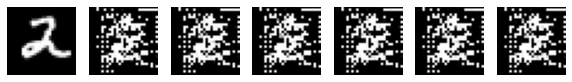

Epoch 5031 g_loss= 5.507846 d_loss= 0.004129878 real_acc= 1.0 fake_acc= 1.0
Epoch 5032 g_loss= 5.5666175 d_loss= 0.003885281 real_acc= 1.0 fake_acc= 1.0
Epoch 5033 g_loss= 5.534951 d_loss= 0.0040106867 real_acc= 1.0 fake_acc= 1.0
Epoch 5034 g_loss= 5.5516424 d_loss= 0.00394283 real_acc= 1.0 fake_acc= 1.0
Epoch 5035 g_loss= 5.5548053 d_loss= 0.003931355 real_acc= 1.0 fake_acc= 1.0
Epoch 5036 g_loss= 5.519038 d_loss= 0.0040603196 real_acc= 1.0 fake_acc= 1.0
Epoch 5037 g_loss= 5.5799828 d_loss= 0.0038380248 real_acc= 1.0 fake_acc= 1.0
Epoch 5038 g_loss= 5.6062245 d_loss= 0.0037183636 real_acc= 1.0 fake_acc= 1.0
Epoch 5039 g_loss= 5.521912 d_loss= 0.0040874854 real_acc= 1.0 fake_acc= 1.0
Epoch 5040 g_loss= 5.5441365 d_loss= 0.00397592 real_acc= 1.0 fake_acc= 1.0


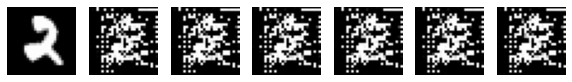

Epoch 5041 g_loss= 5.5599513 d_loss= 0.0038996178 real_acc= 1.0 fake_acc= 1.0
Epoch 5042 g_loss= 5.532015 d_loss= 0.0040451405 real_acc= 1.0 fake_acc= 1.0
Epoch 5043 g_loss= 5.585042 d_loss= 0.0038162088 real_acc= 1.0 fake_acc= 1.0
Epoch 5044 g_loss= 5.576047 d_loss= 0.0038425366 real_acc= 1.0 fake_acc= 1.0
Epoch 5045 g_loss= 5.6002307 d_loss= 0.003765854 real_acc= 1.0 fake_acc= 1.0
Epoch 5046 g_loss= 5.5815 d_loss= 0.003838709 real_acc= 1.0 fake_acc= 1.0
Epoch 5047 g_loss= 5.5884614 d_loss= 0.0038255749 real_acc= 1.0 fake_acc= 1.0
Epoch 5048 g_loss= 5.632228 d_loss= 0.0036521817 real_acc= 1.0 fake_acc= 1.0
Epoch 5049 g_loss= 5.630247 d_loss= 0.0036283862 real_acc= 1.0 fake_acc= 1.0
Epoch 5050 g_loss= 5.611186 d_loss= 0.0037270663 real_acc= 1.0 fake_acc= 1.0


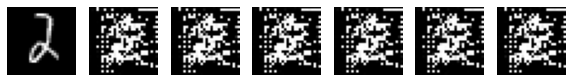

Epoch 5051 g_loss= 5.635069 d_loss= 0.0036210038 real_acc= 1.0 fake_acc= 1.0
Epoch 5052 g_loss= 5.645441 d_loss= 0.0035916409 real_acc= 1.0 fake_acc= 1.0
Epoch 5053 g_loss= 5.6049995 d_loss= 0.0037434762 real_acc= 1.0 fake_acc= 1.0
Epoch 5054 g_loss= 5.6097045 d_loss= 0.0037245473 real_acc= 1.0 fake_acc= 1.0
Epoch 5055 g_loss= 5.6224513 d_loss= 0.0036965227 real_acc= 1.0 fake_acc= 1.0
Epoch 5056 g_loss= 5.6247516 d_loss= 0.0036810955 real_acc= 1.0 fake_acc= 1.0
Epoch 5057 g_loss= 5.5973997 d_loss= 0.003765124 real_acc= 1.0 fake_acc= 1.0
Epoch 5058 g_loss= 5.6347957 d_loss= 0.003609169 real_acc= 1.0 fake_acc= 1.0
Epoch 5059 g_loss= 5.607845 d_loss= 0.0037463678 real_acc= 1.0 fake_acc= 1.0
Epoch 5060 g_loss= 5.6186714 d_loss= 0.0036945185 real_acc= 1.0 fake_acc= 1.0


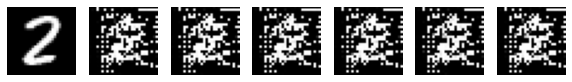

Epoch 5061 g_loss= 5.6560807 d_loss= 0.0035600173 real_acc= 1.0 fake_acc= 1.0
Epoch 5062 g_loss= 5.6668825 d_loss= 0.0035239905 real_acc= 1.0 fake_acc= 1.0
Epoch 5063 g_loss= 5.6851387 d_loss= 0.003458267 real_acc= 1.0 fake_acc= 1.0
Epoch 5064 g_loss= 5.682545 d_loss= 0.0034699207 real_acc= 1.0 fake_acc= 1.0
Epoch 5065 g_loss= 5.6741743 d_loss= 0.0034828498 real_acc= 1.0 fake_acc= 1.0
Epoch 5066 g_loss= 5.6246614 d_loss= 0.0036637022 real_acc= 1.0 fake_acc= 1.0
Epoch 5067 g_loss= 5.641157 d_loss= 0.0036130631 real_acc= 1.0 fake_acc= 1.0
Epoch 5068 g_loss= 5.686722 d_loss= 0.0034627188 real_acc= 1.0 fake_acc= 1.0
Epoch 5069 g_loss= 5.705037 d_loss= 0.0033859909 real_acc= 1.0 fake_acc= 1.0
Epoch 5070 g_loss= 5.6589437 d_loss= 0.0035570255 real_acc= 1.0 fake_acc= 1.0


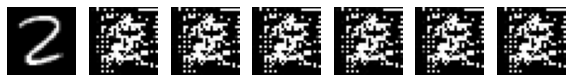

Epoch 5071 g_loss= 5.681 d_loss= 0.0034585446 real_acc= 1.0 fake_acc= 1.0
Epoch 5072 g_loss= 5.6510987 d_loss= 0.0035745664 real_acc= 1.0 fake_acc= 1.0
Epoch 5073 g_loss= 5.676386 d_loss= 0.0034859958 real_acc= 1.0 fake_acc= 1.0
Epoch 5074 g_loss= 5.699916 d_loss= 0.0034145014 real_acc= 1.0 fake_acc= 1.0
Epoch 5075 g_loss= 5.6978245 d_loss= 0.0034029197 real_acc= 1.0 fake_acc= 1.0
Epoch 5076 g_loss= 5.64776 d_loss= 0.0035880785 real_acc= 1.0 fake_acc= 1.0
Epoch 5077 g_loss= 5.693408 d_loss= 0.003421643 real_acc= 1.0 fake_acc= 1.0
Epoch 5078 g_loss= 5.7209477 d_loss= 0.00333492 real_acc= 1.0 fake_acc= 1.0
Epoch 5079 g_loss= 5.651252 d_loss= 0.0035528587 real_acc= 1.0 fake_acc= 1.0
Epoch 5080 g_loss= 5.712745 d_loss= 0.0033827233 real_acc= 1.0 fake_acc= 1.0


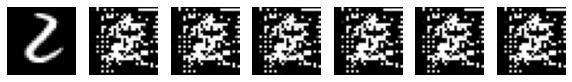

Epoch 5081 g_loss= 5.7474284 d_loss= 0.0032465775 real_acc= 1.0 fake_acc= 1.0
Epoch 5082 g_loss= 5.7430897 d_loss= 0.0032798266 real_acc= 1.0 fake_acc= 1.0
Epoch 5083 g_loss= 5.710826 d_loss= 0.0033745347 real_acc= 1.0 fake_acc= 1.0
Epoch 5084 g_loss= 5.675481 d_loss= 0.0034951419 real_acc= 1.0 fake_acc= 1.0
Epoch 5085 g_loss= 5.728238 d_loss= 0.003311395 real_acc= 1.0 fake_acc= 1.0
Epoch 5086 g_loss= 5.732319 d_loss= 0.0032896567 real_acc= 1.0 fake_acc= 1.0
Epoch 5087 g_loss= 5.6961575 d_loss= 0.0034043372 real_acc= 1.0 fake_acc= 1.0
Epoch 5088 g_loss= 5.71664 d_loss= 0.003335695 real_acc= 1.0 fake_acc= 1.0
Epoch 5089 g_loss= 5.7569566 d_loss= 0.0032140482 real_acc= 1.0 fake_acc= 1.0
Epoch 5090 g_loss= 5.7302547 d_loss= 0.003311119 real_acc= 1.0 fake_acc= 1.0


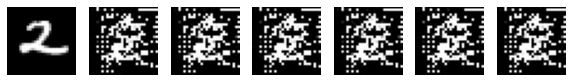

Epoch 5091 g_loss= 5.73472 d_loss= 0.0032744633 real_acc= 1.0 fake_acc= 1.0
Epoch 5092 g_loss= 5.7445683 d_loss= 0.003242884 real_acc= 1.0 fake_acc= 1.0
Epoch 5093 g_loss= 5.731753 d_loss= 0.003299326 real_acc= 1.0 fake_acc= 1.0
Epoch 5094 g_loss= 5.760333 d_loss= 0.0032113213 real_acc= 1.0 fake_acc= 1.0
Epoch 5095 g_loss= 5.801065 d_loss= 0.00306006 real_acc= 1.0 fake_acc= 1.0
Epoch 5096 g_loss= 5.7425203 d_loss= 0.0032539547 real_acc= 1.0 fake_acc= 1.0
Epoch 5097 g_loss= 5.7456584 d_loss= 0.0032390358 real_acc= 1.0 fake_acc= 1.0
Epoch 5098 g_loss= 5.7579675 d_loss= 0.0032134354 real_acc= 1.0 fake_acc= 1.0
Epoch 5099 g_loss= 5.8023443 d_loss= 0.0030689565 real_acc= 1.0 fake_acc= 1.0
Epoch 5100 g_loss= 5.760323 d_loss= 0.0032038016 real_acc= 1.0 fake_acc= 1.0


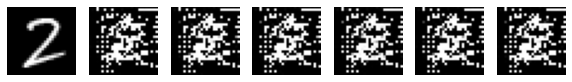

Epoch 5101 g_loss= 5.7434983 d_loss= 0.0032643657 real_acc= 1.0 fake_acc= 1.0
Epoch 5102 g_loss= 5.765538 d_loss= 0.0031742642 real_acc= 1.0 fake_acc= 1.0
Epoch 5103 g_loss= 5.809891 d_loss= 0.0030699086 real_acc= 1.0 fake_acc= 1.0
Epoch 5104 g_loss= 5.742464 d_loss= 0.0032689285 real_acc= 1.0 fake_acc= 1.0
Epoch 5105 g_loss= 5.721656 d_loss= 0.003327577 real_acc= 1.0 fake_acc= 1.0
Epoch 5106 g_loss= 5.8060393 d_loss= 0.0030487748 real_acc= 1.0 fake_acc= 1.0
Epoch 5107 g_loss= 5.790645 d_loss= 0.0031196882 real_acc= 1.0 fake_acc= 1.0
Epoch 5108 g_loss= 5.812177 d_loss= 0.0030505124 real_acc= 1.0 fake_acc= 1.0
Epoch 5109 g_loss= 5.7910576 d_loss= 0.0031098342 real_acc= 1.0 fake_acc= 1.0
Epoch 5110 g_loss= 5.821115 d_loss= 0.003014236 real_acc= 1.0 fake_acc= 1.0


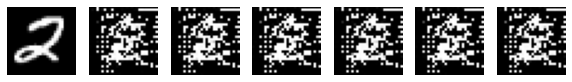

Epoch 5111 g_loss= 5.8019195 d_loss= 0.0030720392 real_acc= 1.0 fake_acc= 1.0
Epoch 5112 g_loss= 5.8020306 d_loss= 0.0030729857 real_acc= 1.0 fake_acc= 1.0
Epoch 5113 g_loss= 5.798325 d_loss= 0.0030742118 real_acc= 1.0 fake_acc= 1.0
Epoch 5114 g_loss= 5.8308997 d_loss= 0.0029760003 real_acc= 1.0 fake_acc= 1.0
Epoch 5115 g_loss= 5.8373027 d_loss= 0.0029617113 real_acc= 1.0 fake_acc= 1.0
Epoch 5116 g_loss= 5.8097205 d_loss= 0.0030432139 real_acc= 1.0 fake_acc= 1.0
Epoch 5117 g_loss= 5.835943 d_loss= 0.0029673246 real_acc= 1.0 fake_acc= 1.0
Epoch 5118 g_loss= 5.8566213 d_loss= 0.002899406 real_acc= 1.0 fake_acc= 1.0
Epoch 5119 g_loss= 5.8827667 d_loss= 0.0028555482 real_acc= 1.0 fake_acc= 1.0
Epoch 5120 g_loss= 5.807092 d_loss= 0.0030669095 real_acc= 1.0 fake_acc= 1.0


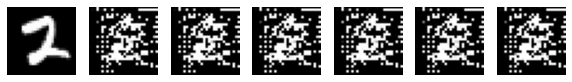

Epoch 5121 g_loss= 5.836226 d_loss= 0.0029664796 real_acc= 1.0 fake_acc= 1.0
Epoch 5122 g_loss= 5.8396206 d_loss= 0.0029562449 real_acc= 1.0 fake_acc= 1.0
Epoch 5123 g_loss= 5.7984834 d_loss= 0.0030881772 real_acc= 1.0 fake_acc= 1.0
Epoch 5124 g_loss= 5.8122478 d_loss= 0.0030476486 real_acc= 1.0 fake_acc= 1.0
Epoch 5125 g_loss= 5.8897038 d_loss= 0.0028153395 real_acc= 1.0 fake_acc= 1.0
Epoch 5126 g_loss= 5.84709 d_loss= 0.0029447132 real_acc= 1.0 fake_acc= 1.0
Epoch 5127 g_loss= 5.8653035 d_loss= 0.002878766 real_acc= 1.0 fake_acc= 1.0
Epoch 5128 g_loss= 5.876177 d_loss= 0.0028607023 real_acc= 1.0 fake_acc= 1.0
Epoch 5129 g_loss= 5.873775 d_loss= 0.0028655021 real_acc= 1.0 fake_acc= 1.0
Epoch 5130 g_loss= 5.856933 d_loss= 0.0029237745 real_acc= 1.0 fake_acc= 1.0


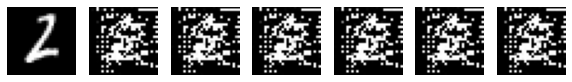

Epoch 5131 g_loss= 5.919231 d_loss= 0.0027273882 real_acc= 1.0 fake_acc= 1.0
Epoch 5132 g_loss= 5.8415217 d_loss= 0.0029429463 real_acc= 1.0 fake_acc= 1.0
Epoch 5133 g_loss= 5.8761487 d_loss= 0.0028411886 real_acc= 1.0 fake_acc= 1.0
Epoch 5134 g_loss= 5.9182878 d_loss= 0.0027493632 real_acc= 1.0 fake_acc= 1.0
Epoch 5135 g_loss= 5.843305 d_loss= 0.0029509834 real_acc= 1.0 fake_acc= 1.0
Epoch 5136 g_loss= 5.8439436 d_loss= 0.0029448504 real_acc= 1.0 fake_acc= 1.0
Epoch 5137 g_loss= 5.8714223 d_loss= 0.0028811244 real_acc= 1.0 fake_acc= 1.0
Epoch 5138 g_loss= 5.8844 d_loss= 0.0028261151 real_acc= 1.0 fake_acc= 1.0
Epoch 5139 g_loss= 5.89237 d_loss= 0.002799198 real_acc= 1.0 fake_acc= 1.0
Epoch 5140 g_loss= 5.858932 d_loss= 0.0029104748 real_acc= 1.0 fake_acc= 1.0


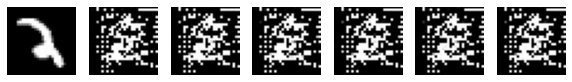

Epoch 5141 g_loss= 5.8892837 d_loss= 0.0028263668 real_acc= 1.0 fake_acc= 1.0
Epoch 5142 g_loss= 5.914671 d_loss= 0.0027436158 real_acc= 1.0 fake_acc= 1.0
Epoch 5143 g_loss= 5.892938 d_loss= 0.0028063091 real_acc= 1.0 fake_acc= 1.0
Epoch 5144 g_loss= 5.8818374 d_loss= 0.0028365022 real_acc= 1.0 fake_acc= 1.0
Epoch 5145 g_loss= 5.8690686 d_loss= 0.0028690768 real_acc= 1.0 fake_acc= 1.0
Epoch 5146 g_loss= 5.9600463 d_loss= 0.0026435067 real_acc= 1.0 fake_acc= 1.0
Epoch 5147 g_loss= 5.8836884 d_loss= 0.0028420135 real_acc= 1.0 fake_acc= 1.0
Epoch 5148 g_loss= 5.8889246 d_loss= 0.0028242653 real_acc= 1.0 fake_acc= 1.0
Epoch 5149 g_loss= 5.911116 d_loss= 0.0027459664 real_acc= 1.0 fake_acc= 1.0
Epoch 5150 g_loss= 5.908074 d_loss= 0.0027787897 real_acc= 1.0 fake_acc= 1.0


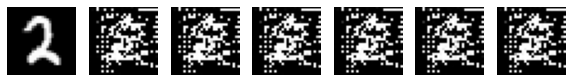

Epoch 5151 g_loss= 5.9019527 d_loss= 0.002804685 real_acc= 1.0 fake_acc= 1.0
Epoch 5152 g_loss= 5.9124255 d_loss= 0.0027570128 real_acc= 1.0 fake_acc= 1.0
Epoch 5153 g_loss= 5.9735346 d_loss= 0.002596722 real_acc= 1.0 fake_acc= 1.0
Epoch 5154 g_loss= 5.9762144 d_loss= 0.0025844192 real_acc= 1.0 fake_acc= 1.0
Epoch 5155 g_loss= 5.927916 d_loss= 0.0027072662 real_acc= 1.0 fake_acc= 1.0
Epoch 5156 g_loss= 5.8815722 d_loss= 0.0028543365 real_acc= 1.0 fake_acc= 1.0
Epoch 5157 g_loss= 5.947047 d_loss= 0.0026736192 real_acc= 1.0 fake_acc= 1.0
Epoch 5158 g_loss= 5.97908 d_loss= 0.0025723088 real_acc= 1.0 fake_acc= 1.0
Epoch 5159 g_loss= 5.9639573 d_loss= 0.002624728 real_acc= 1.0 fake_acc= 1.0
Epoch 5160 g_loss= 5.9649906 d_loss= 0.0026162646 real_acc= 1.0 fake_acc= 1.0


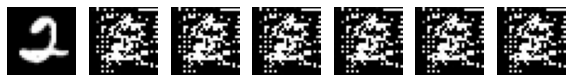

Epoch 5161 g_loss= 6.011572 d_loss= 0.002509047 real_acc= 1.0 fake_acc= 1.0
Epoch 5162 g_loss= 5.9739466 d_loss= 0.002576477 real_acc= 1.0 fake_acc= 1.0
Epoch 5163 g_loss= 5.938906 d_loss= 0.0026766048 real_acc= 1.0 fake_acc= 1.0
Epoch 5164 g_loss= 5.9970155 d_loss= 0.00252916 real_acc= 1.0 fake_acc= 1.0
Epoch 5165 g_loss= 5.957063 d_loss= 0.0026340997 real_acc= 1.0 fake_acc= 1.0
Epoch 5166 g_loss= 5.9848866 d_loss= 0.0025543952 real_acc= 1.0 fake_acc= 1.0
Epoch 5167 g_loss= 5.966223 d_loss= 0.0026070958 real_acc= 1.0 fake_acc= 1.0
Epoch 5168 g_loss= 5.9617357 d_loss= 0.0026326044 real_acc= 1.0 fake_acc= 1.0
Epoch 5169 g_loss= 5.985016 d_loss= 0.0025580171 real_acc= 1.0 fake_acc= 1.0
Epoch 5170 g_loss= 5.9432945 d_loss= 0.0026662499 real_acc= 1.0 fake_acc= 1.0


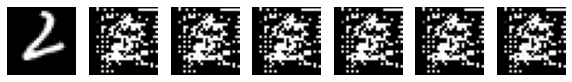

Epoch 5171 g_loss= 5.9492173 d_loss= 0.0026727382 real_acc= 1.0 fake_acc= 1.0
Epoch 5172 g_loss= 5.9694023 d_loss= 0.0026040361 real_acc= 1.0 fake_acc= 1.0
Epoch 5173 g_loss= 5.9808793 d_loss= 0.0025832618 real_acc= 1.0 fake_acc= 1.0
Epoch 5174 g_loss= 5.9762993 d_loss= 0.0025831515 real_acc= 1.0 fake_acc= 1.0
Epoch 5175 g_loss= 5.999728 d_loss= 0.002525009 real_acc= 1.0 fake_acc= 1.0
Epoch 5176 g_loss= 5.989911 d_loss= 0.0025552716 real_acc= 1.0 fake_acc= 1.0
Epoch 5177 g_loss= 6.0090184 d_loss= 0.0025120643 real_acc= 1.0 fake_acc= 1.0
Epoch 5178 g_loss= 6.016734 d_loss= 0.0024888928 real_acc= 1.0 fake_acc= 1.0
Epoch 5179 g_loss= 6.0142865 d_loss= 0.0024777048 real_acc= 1.0 fake_acc= 1.0
Epoch 5180 g_loss= 5.9667583 d_loss= 0.0026011518 real_acc= 1.0 fake_acc= 1.0


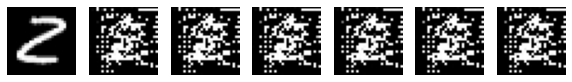

Epoch 5181 g_loss= 5.97544 d_loss= 0.0025985178 real_acc= 1.0 fake_acc= 1.0
Epoch 5182 g_loss= 6.059213 d_loss= 0.0023765494 real_acc= 1.0 fake_acc= 1.0
Epoch 5183 g_loss= 6.03581 d_loss= 0.0024331426 real_acc= 1.0 fake_acc= 1.0
Epoch 5184 g_loss= 6.022452 d_loss= 0.00245575 real_acc= 1.0 fake_acc= 1.0
Epoch 5185 g_loss= 6.0386186 d_loss= 0.0024185367 real_acc= 1.0 fake_acc= 1.0
Epoch 5186 g_loss= 5.976601 d_loss= 0.002600091 real_acc= 1.0 fake_acc= 1.0
Epoch 5187 g_loss= 6.0721326 d_loss= 0.0023409366 real_acc= 1.0 fake_acc= 1.0
Epoch 5188 g_loss= 6.095187 d_loss= 0.0022976252 real_acc= 1.0 fake_acc= 1.0
Epoch 5189 g_loss= 6.006803 d_loss= 0.0025064654 real_acc= 1.0 fake_acc= 1.0
Epoch 5190 g_loss= 6.076882 d_loss= 0.002339138 real_acc= 1.0 fake_acc= 1.0


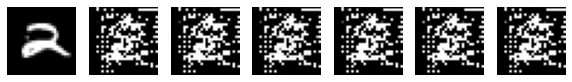

Epoch 5191 g_loss= 6.040959 d_loss= 0.0024171053 real_acc= 1.0 fake_acc= 1.0
Epoch 5192 g_loss= 6.0064354 d_loss= 0.0024966176 real_acc= 1.0 fake_acc= 1.0
Epoch 5193 g_loss= 6.05906 d_loss= 0.0023863409 real_acc= 1.0 fake_acc= 1.0
Epoch 5194 g_loss= 6.056377 d_loss= 0.002380324 real_acc= 1.0 fake_acc= 1.0
Epoch 5195 g_loss= 5.9960146 d_loss= 0.0025338056 real_acc= 1.0 fake_acc= 1.0
Epoch 5196 g_loss= 6.0468054 d_loss= 0.0024106798 real_acc= 1.0 fake_acc= 1.0
Epoch 5197 g_loss= 6.054803 d_loss= 0.0023839104 real_acc= 1.0 fake_acc= 1.0
Epoch 5198 g_loss= 6.053879 d_loss= 0.00239558 real_acc= 1.0 fake_acc= 1.0
Epoch 5199 g_loss= 6.0799217 d_loss= 0.0023320394 real_acc= 1.0 fake_acc= 1.0
Epoch 5200 g_loss= 6.0665545 d_loss= 0.0023625216 real_acc= 1.0 fake_acc= 1.0


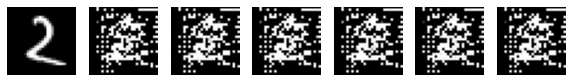

Epoch 5201 g_loss= 5.9726405 d_loss= 0.0025974389 real_acc= 1.0 fake_acc= 1.0
Epoch 5202 g_loss= 6.073767 d_loss= 0.002346294 real_acc= 1.0 fake_acc= 1.0
Epoch 5203 g_loss= 6.074572 d_loss= 0.0023617793 real_acc= 1.0 fake_acc= 1.0
Epoch 5204 g_loss= 6.0481963 d_loss= 0.002405353 real_acc= 1.0 fake_acc= 1.0
Epoch 5205 g_loss= 6.083175 d_loss= 0.002328361 real_acc= 1.0 fake_acc= 1.0
Epoch 5206 g_loss= 6.0884156 d_loss= 0.0023096409 real_acc= 1.0 fake_acc= 1.0
Epoch 5207 g_loss= 6.096409 d_loss= 0.0023001162 real_acc= 1.0 fake_acc= 1.0
Epoch 5208 g_loss= 6.076763 d_loss= 0.0023292599 real_acc= 1.0 fake_acc= 1.0
Epoch 5209 g_loss= 6.0844946 d_loss= 0.0023207932 real_acc= 1.0 fake_acc= 1.0
Epoch 5210 g_loss= 6.099203 d_loss= 0.0023057237 real_acc= 1.0 fake_acc= 1.0


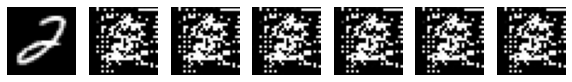

Epoch 5211 g_loss= 6.123009 d_loss= 0.0022252763 real_acc= 1.0 fake_acc= 1.0
Epoch 5212 g_loss= 6.123637 d_loss= 0.002220303 real_acc= 1.0 fake_acc= 1.0
Epoch 5213 g_loss= 6.103248 d_loss= 0.00226775 real_acc= 1.0 fake_acc= 1.0
Epoch 5214 g_loss= 6.1335726 d_loss= 0.0022176441 real_acc= 1.0 fake_acc= 1.0
Epoch 5215 g_loss= 6.1461897 d_loss= 0.0021845386 real_acc= 1.0 fake_acc= 1.0
Epoch 5216 g_loss= 6.0346656 d_loss= 0.002454033 real_acc= 1.0 fake_acc= 1.0
Epoch 5217 g_loss= 6.088704 d_loss= 0.0023094858 real_acc= 1.0 fake_acc= 1.0
Epoch 5218 g_loss= 6.0902586 d_loss= 0.002310421 real_acc= 1.0 fake_acc= 1.0
Epoch 5219 g_loss= 6.097562 d_loss= 0.0022844607 real_acc= 1.0 fake_acc= 1.0
Epoch 5220 g_loss= 6.1095905 d_loss= 0.0022645132 real_acc= 1.0 fake_acc= 1.0


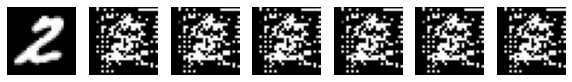

Epoch 5221 g_loss= 6.13232 d_loss= 0.0022195913 real_acc= 1.0 fake_acc= 1.0
Epoch 5222 g_loss= 6.157602 d_loss= 0.0021602015 real_acc= 1.0 fake_acc= 1.0
Epoch 5223 g_loss= 6.0946627 d_loss= 0.0022959178 real_acc= 1.0 fake_acc= 1.0
Epoch 5224 g_loss= 6.117244 d_loss= 0.002247972 real_acc= 1.0 fake_acc= 1.0
Epoch 5225 g_loss= 6.111642 d_loss= 0.0022662722 real_acc= 1.0 fake_acc= 1.0
Epoch 5226 g_loss= 6.1177883 d_loss= 0.0022355693 real_acc= 1.0 fake_acc= 1.0
Epoch 5227 g_loss= 6.125879 d_loss= 0.002219372 real_acc= 1.0 fake_acc= 1.0
Epoch 5228 g_loss= 6.1191845 d_loss= 0.0022333607 real_acc= 1.0 fake_acc= 1.0
Epoch 5229 g_loss= 6.108455 d_loss= 0.002262643 real_acc= 1.0 fake_acc= 1.0
Epoch 5230 g_loss= 6.12694 d_loss= 0.002232647 real_acc= 1.0 fake_acc= 1.0


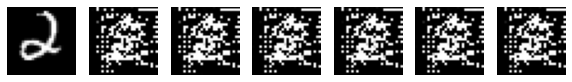

Epoch 5231 g_loss= 6.1807446 d_loss= 0.002108599 real_acc= 1.0 fake_acc= 1.0
Epoch 5232 g_loss= 6.182192 d_loss= 0.002091215 real_acc= 1.0 fake_acc= 1.0
Epoch 5233 g_loss= 6.179696 d_loss= 0.002118111 real_acc= 1.0 fake_acc= 1.0
Epoch 5234 g_loss= 6.202236 d_loss= 0.0020661098 real_acc= 1.0 fake_acc= 1.0
Epoch 5235 g_loss= 6.1990294 d_loss= 0.0020694367 real_acc= 1.0 fake_acc= 1.0
Epoch 5236 g_loss= 6.184852 d_loss= 0.0020992716 real_acc= 1.0 fake_acc= 1.0
Epoch 5237 g_loss= 6.1407747 d_loss= 0.002187081 real_acc= 1.0 fake_acc= 1.0
Epoch 5238 g_loss= 6.2349005 d_loss= 0.001993341 real_acc= 1.0 fake_acc= 1.0
Epoch 5239 g_loss= 6.178526 d_loss= 0.0021093434 real_acc= 1.0 fake_acc= 1.0
Epoch 5240 g_loss= 6.1909356 d_loss= 0.0020754137 real_acc= 1.0 fake_acc= 1.0


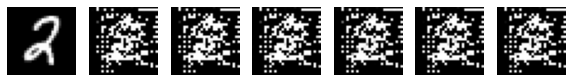

Epoch 5241 g_loss= 6.143347 d_loss= 0.002189644 real_acc= 1.0 fake_acc= 1.0
Epoch 5242 g_loss= 6.200795 d_loss= 0.0021006956 real_acc= 1.0 fake_acc= 1.0
Epoch 5243 g_loss= 6.195907 d_loss= 0.0020755103 real_acc= 1.0 fake_acc= 1.0
Epoch 5244 g_loss= 6.1815705 d_loss= 0.002126948 real_acc= 1.0 fake_acc= 1.0
Epoch 5245 g_loss= 6.213376 d_loss= 0.0020362812 real_acc= 1.0 fake_acc= 1.0
Epoch 5246 g_loss= 6.197411 d_loss= 0.002078455 real_acc= 1.0 fake_acc= 1.0
Epoch 5247 g_loss= 6.2150073 d_loss= 0.0020295237 real_acc= 1.0 fake_acc= 1.0
Epoch 5248 g_loss= 6.166702 d_loss= 0.0021367092 real_acc= 1.0 fake_acc= 1.0
Epoch 5249 g_loss= 6.189905 d_loss= 0.002080149 real_acc= 1.0 fake_acc= 1.0
Epoch 5250 g_loss= 6.194818 d_loss= 0.0020763136 real_acc= 1.0 fake_acc= 1.0


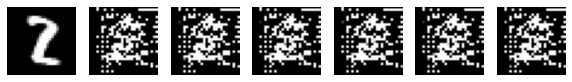

Epoch 5251 g_loss= 6.214243 d_loss= 0.0020460554 real_acc= 1.0 fake_acc= 1.0
Epoch 5252 g_loss= 6.246144 d_loss= 0.0019809455 real_acc= 1.0 fake_acc= 1.0
Epoch 5253 g_loss= 6.2544026 d_loss= 0.0019725596 real_acc= 1.0 fake_acc= 1.0
Epoch 5254 g_loss= 6.2057805 d_loss= 0.0020507332 real_acc= 1.0 fake_acc= 1.0
Epoch 5255 g_loss= 6.236694 d_loss= 0.0019960303 real_acc= 1.0 fake_acc= 1.0
Epoch 5256 g_loss= 6.225287 d_loss= 0.0020117848 real_acc= 1.0 fake_acc= 1.0
Epoch 5257 g_loss= 6.2178326 d_loss= 0.002034474 real_acc= 1.0 fake_acc= 1.0
Epoch 5258 g_loss= 6.207897 d_loss= 0.0020627212 real_acc= 1.0 fake_acc= 1.0
Epoch 5259 g_loss= 6.232215 d_loss= 0.0020053103 real_acc= 1.0 fake_acc= 1.0
Epoch 5260 g_loss= 6.200327 d_loss= 0.0020745583 real_acc= 1.0 fake_acc= 1.0


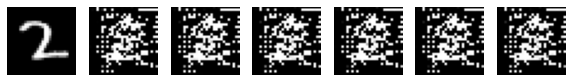

Epoch 5261 g_loss= 6.247367 d_loss= 0.0019648152 real_acc= 1.0 fake_acc= 1.0
Epoch 5262 g_loss= 6.2236495 d_loss= 0.0020145967 real_acc= 1.0 fake_acc= 1.0
Epoch 5263 g_loss= 6.18258 d_loss= 0.0020983107 real_acc= 1.0 fake_acc= 1.0
Epoch 5264 g_loss= 6.2230797 d_loss= 0.0020159758 real_acc= 1.0 fake_acc= 1.0
Epoch 5265 g_loss= 6.2896576 d_loss= 0.0018912186 real_acc= 1.0 fake_acc= 1.0
Epoch 5266 g_loss= 6.26935 d_loss= 0.0019327643 real_acc= 1.0 fake_acc= 1.0
Epoch 5267 g_loss= 6.2635646 d_loss= 0.0019500208 real_acc= 1.0 fake_acc= 1.0
Epoch 5268 g_loss= 6.293856 d_loss= 0.001885209 real_acc= 1.0 fake_acc= 1.0
Epoch 5269 g_loss= 6.2237678 d_loss= 0.0020170354 real_acc= 1.0 fake_acc= 1.0
Epoch 5270 g_loss= 6.226755 d_loss= 0.002003575 real_acc= 1.0 fake_acc= 1.0


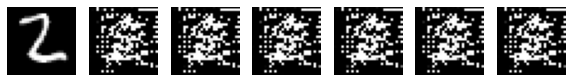

Epoch 5271 g_loss= 6.269065 d_loss= 0.0019338771 real_acc= 1.0 fake_acc= 1.0
Epoch 5272 g_loss= 6.2823787 d_loss= 0.001898436 real_acc= 1.0 fake_acc= 1.0
Epoch 5273 g_loss= 6.2115636 d_loss= 0.002050659 real_acc= 1.0 fake_acc= 1.0
Epoch 5274 g_loss= 6.247064 d_loss= 0.0019681947 real_acc= 1.0 fake_acc= 1.0
Epoch 5275 g_loss= 6.2906036 d_loss= 0.0018948767 real_acc= 1.0 fake_acc= 1.0
Epoch 5276 g_loss= 6.292299 d_loss= 0.0018735996 real_acc= 1.0 fake_acc= 1.0
Epoch 5277 g_loss= 6.246196 d_loss= 0.0019820696 real_acc= 1.0 fake_acc= 1.0
Epoch 5278 g_loss= 6.257221 d_loss= 0.0019441019 real_acc= 1.0 fake_acc= 1.0
Epoch 5279 g_loss= 6.282848 d_loss= 0.0018955569 real_acc= 1.0 fake_acc= 1.0
Epoch 5280 g_loss= 6.3122234 d_loss= 0.0018494234 real_acc= 1.0 fake_acc= 1.0


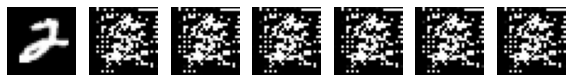

Epoch 5281 g_loss= 6.227005 d_loss= 0.002007705 real_acc= 1.0 fake_acc= 1.0
Epoch 5282 g_loss= 6.3014793 d_loss= 0.0018698536 real_acc= 1.0 fake_acc= 1.0
Epoch 5283 g_loss= 6.245971 d_loss= 0.0019700774 real_acc= 1.0 fake_acc= 1.0
Epoch 5284 g_loss= 6.3072505 d_loss= 0.0018655492 real_acc= 1.0 fake_acc= 1.0
Epoch 5285 g_loss= 6.246826 d_loss= 0.001964638 real_acc= 1.0 fake_acc= 1.0
Epoch 5286 g_loss= 6.2605987 d_loss= 0.0019446817 real_acc= 1.0 fake_acc= 1.0
Epoch 5287 g_loss= 6.3370495 d_loss= 0.0017990727 real_acc= 1.0 fake_acc= 1.0
Epoch 5288 g_loss= 6.2721615 d_loss= 0.0019303617 real_acc= 1.0 fake_acc= 1.0
Epoch 5289 g_loss= 6.2691994 d_loss= 0.0019262009 real_acc= 1.0 fake_acc= 1.0
Epoch 5290 g_loss= 6.294447 d_loss= 0.0018844177 real_acc= 1.0 fake_acc= 1.0


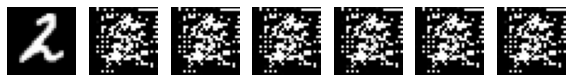

Epoch 5291 g_loss= 6.2923217 d_loss= 0.0018843533 real_acc= 1.0 fake_acc= 1.0
Epoch 5292 g_loss= 6.303612 d_loss= 0.0018672638 real_acc= 1.0 fake_acc= 1.0
Epoch 5293 g_loss= 6.284153 d_loss= 0.001903772 real_acc= 1.0 fake_acc= 1.0
Epoch 5294 g_loss= 6.266596 d_loss= 0.0019292888 real_acc= 1.0 fake_acc= 1.0
Epoch 5295 g_loss= 6.3665285 d_loss= 0.0017466829 real_acc= 1.0 fake_acc= 1.0
Epoch 5296 g_loss= 6.3460255 d_loss= 0.0017890452 real_acc= 1.0 fake_acc= 1.0
Epoch 5297 g_loss= 6.280323 d_loss= 0.0019061492 real_acc= 1.0 fake_acc= 1.0
Epoch 5298 g_loss= 6.3005896 d_loss= 0.0018651427 real_acc= 1.0 fake_acc= 1.0
Epoch 5299 g_loss= 6.2663655 d_loss= 0.0019264952 real_acc= 1.0 fake_acc= 1.0
Epoch 5300 g_loss= 6.329143 d_loss= 0.0018190574 real_acc= 1.0 fake_acc= 1.0


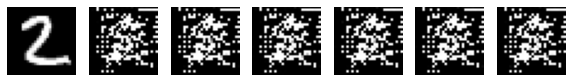

Epoch 5301 g_loss= 6.344614 d_loss= 0.0017812934 real_acc= 1.0 fake_acc= 1.0
Epoch 5302 g_loss= 6.355735 d_loss= 0.0017655222 real_acc= 1.0 fake_acc= 1.0
Epoch 5303 g_loss= 6.3152146 d_loss= 0.0018391903 real_acc= 1.0 fake_acc= 1.0
Epoch 5304 g_loss= 6.3393235 d_loss= 0.0018059312 real_acc= 1.0 fake_acc= 1.0
Epoch 5305 g_loss= 6.340929 d_loss= 0.0017978628 real_acc= 1.0 fake_acc= 1.0
Epoch 5306 g_loss= 6.3359337 d_loss= 0.0018073383 real_acc= 1.0 fake_acc= 1.0
Epoch 5307 g_loss= 6.3280888 d_loss= 0.0018263138 real_acc= 1.0 fake_acc= 1.0
Epoch 5308 g_loss= 6.3004875 d_loss= 0.0018799338 real_acc= 1.0 fake_acc= 1.0
Epoch 5309 g_loss= 6.323421 d_loss= 0.0018206161 real_acc= 1.0 fake_acc= 1.0
Epoch 5310 g_loss= 6.3870106 d_loss= 0.0017131014 real_acc= 1.0 fake_acc= 1.0


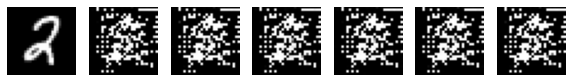

Epoch 5311 g_loss= 6.412124 d_loss= 0.0016698373 real_acc= 1.0 fake_acc= 1.0
Epoch 5312 g_loss= 6.347593 d_loss= 0.0017880361 real_acc= 1.0 fake_acc= 1.0
Epoch 5313 g_loss= 6.323023 d_loss= 0.0018317607 real_acc= 1.0 fake_acc= 1.0
Epoch 5314 g_loss= 6.306907 d_loss= 0.001851426 real_acc= 1.0 fake_acc= 1.0
Epoch 5315 g_loss= 6.3811326 d_loss= 0.0017193283 real_acc= 1.0 fake_acc= 1.0
Epoch 5316 g_loss= 6.3656526 d_loss= 0.0017443036 real_acc= 1.0 fake_acc= 1.0
Epoch 5317 g_loss= 6.3346314 d_loss= 0.0018133024 real_acc= 1.0 fake_acc= 1.0
Epoch 5318 g_loss= 6.3524337 d_loss= 0.0017790827 real_acc= 1.0 fake_acc= 1.0
Epoch 5319 g_loss= 6.3846455 d_loss= 0.0017202911 real_acc= 1.0 fake_acc= 1.0
Epoch 5320 g_loss= 6.3194566 d_loss= 0.0018405434 real_acc= 1.0 fake_acc= 1.0


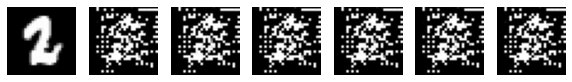

Epoch 5321 g_loss= 6.376025 d_loss= 0.0017280605 real_acc= 1.0 fake_acc= 1.0
Epoch 5322 g_loss= 6.3634453 d_loss= 0.0017538195 real_acc= 1.0 fake_acc= 1.0
Epoch 5323 g_loss= 6.3798122 d_loss= 0.001731156 real_acc= 1.0 fake_acc= 1.0
Epoch 5324 g_loss= 6.422826 d_loss= 0.0016582467 real_acc= 1.0 fake_acc= 1.0
Epoch 5325 g_loss= 6.3793206 d_loss= 0.001730878 real_acc= 1.0 fake_acc= 1.0
Epoch 5326 g_loss= 6.377496 d_loss= 0.0017269808 real_acc= 1.0 fake_acc= 1.0
Epoch 5327 g_loss= 6.374798 d_loss= 0.0017304325 real_acc= 1.0 fake_acc= 1.0
Epoch 5328 g_loss= 6.408844 d_loss= 0.0016767808 real_acc= 1.0 fake_acc= 1.0
Epoch 5329 g_loss= 6.3507495 d_loss= 0.0017720935 real_acc= 1.0 fake_acc= 1.0
Epoch 5330 g_loss= 6.4202986 d_loss= 0.0016607215 real_acc= 1.0 fake_acc= 1.0


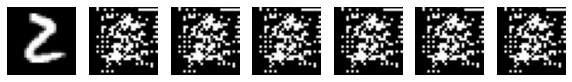

Epoch 5331 g_loss= 6.378303 d_loss= 0.0017521014 real_acc= 1.0 fake_acc= 1.0
Epoch 5332 g_loss= 6.3473744 d_loss= 0.001786396 real_acc= 1.0 fake_acc= 1.0
Epoch 5333 g_loss= 6.3718734 d_loss= 0.0017446629 real_acc= 1.0 fake_acc= 1.0
Epoch 5334 g_loss= 6.3785686 d_loss= 0.0017381873 real_acc= 1.0 fake_acc= 1.0
Epoch 5335 g_loss= 6.342711 d_loss= 0.0017981678 real_acc= 1.0 fake_acc= 1.0
Epoch 5336 g_loss= 6.392031 d_loss= 0.0017013183 real_acc= 1.0 fake_acc= 1.0
Epoch 5337 g_loss= 6.3595815 d_loss= 0.0017643981 real_acc= 1.0 fake_acc= 1.0
Epoch 5338 g_loss= 6.391436 d_loss= 0.0017219881 real_acc= 1.0 fake_acc= 1.0
Epoch 5339 g_loss= 6.414182 d_loss= 0.0016608478 real_acc= 1.0 fake_acc= 1.0
Epoch 5340 g_loss= 6.406671 d_loss= 0.0016829736 real_acc= 1.0 fake_acc= 1.0


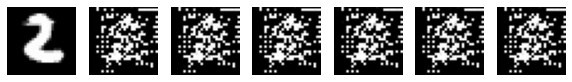

Epoch 5341 g_loss= 6.3926487 d_loss= 0.0017043385 real_acc= 1.0 fake_acc= 1.0
Epoch 5342 g_loss= 6.440355 d_loss= 0.0016381246 real_acc= 1.0 fake_acc= 1.0
Epoch 5343 g_loss= 6.4373765 d_loss= 0.0016319596 real_acc= 1.0 fake_acc= 1.0
Epoch 5344 g_loss= 6.440636 d_loss= 0.0016375842 real_acc= 1.0 fake_acc= 1.0
Epoch 5345 g_loss= 6.4897313 d_loss= 0.0015411399 real_acc= 1.0 fake_acc= 1.0
Epoch 5346 g_loss= 6.421572 d_loss= 0.0016541785 real_acc= 1.0 fake_acc= 1.0
Epoch 5347 g_loss= 6.4290385 d_loss= 0.0019081121 real_acc= 1.0 fake_acc= 1.0
Epoch 5348 g_loss= 6.453131 d_loss= 0.0016007108 real_acc= 1.0 fake_acc= 1.0
Epoch 5349 g_loss= 6.4189034 d_loss= 0.0016497076 real_acc= 1.0 fake_acc= 1.0
Epoch 5350 g_loss= 6.4763994 d_loss= 0.0015806599 real_acc= 1.0 fake_acc= 1.0


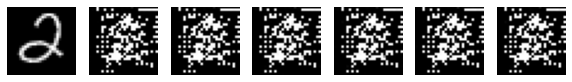

Epoch 5351 g_loss= 6.433443 d_loss= 0.0016290153 real_acc= 1.0 fake_acc= 1.0
Epoch 5352 g_loss= 6.4676337 d_loss= 0.0015796013 real_acc= 1.0 fake_acc= 1.0
Epoch 5353 g_loss= 6.4121633 d_loss= 0.001679912 real_acc= 1.0 fake_acc= 1.0
Epoch 5354 g_loss= 6.4280148 d_loss= 0.0052173473 real_acc= 1.0 fake_acc= 1.0
Epoch 5355 g_loss= 6.4355707 d_loss= 0.0016388166 real_acc= 1.0 fake_acc= 1.0
Epoch 5356 g_loss= 6.4341187 d_loss= 0.0016322578 real_acc= 1.0 fake_acc= 1.0
Epoch 5357 g_loss= 6.4075594 d_loss= 0.0016816357 real_acc= 1.0 fake_acc= 1.0
Epoch 5358 g_loss= 6.429982 d_loss= 0.0016402146 real_acc= 1.0 fake_acc= 1.0
Epoch 5359 g_loss= 6.4158134 d_loss= 0.0016700249 real_acc= 1.0 fake_acc= 1.0
Epoch 5360 g_loss= 6.4161787 d_loss= 0.0016787676 real_acc= 1.0 fake_acc= 1.0


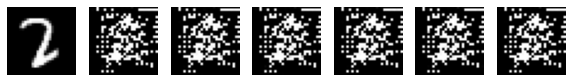

Epoch 5361 g_loss= 6.427994 d_loss= 0.0016421364 real_acc= 1.0 fake_acc= 1.0
Epoch 5362 g_loss= 6.390184 d_loss= 0.001713252 real_acc= 1.0 fake_acc= 1.0
Epoch 5363 g_loss= 6.391696 d_loss= 0.0016975472 real_acc= 1.0 fake_acc= 1.0
Epoch 5364 g_loss= 6.4074445 d_loss= 0.00168237 real_acc= 1.0 fake_acc= 1.0
Epoch 5365 g_loss= 6.4295835 d_loss= 0.001648032 real_acc= 1.0 fake_acc= 1.0
Epoch 5366 g_loss= 6.366503 d_loss= 0.0017481704 real_acc= 1.0 fake_acc= 1.0
Epoch 5367 g_loss= 6.4021 d_loss= 0.0016918674 real_acc= 1.0 fake_acc= 1.0
Epoch 5368 g_loss= 6.4061084 d_loss= 0.0016708168 real_acc= 1.0 fake_acc= 1.0
Epoch 5369 g_loss= 6.392149 d_loss= 0.0017003935 real_acc= 1.0 fake_acc= 1.0
Epoch 5370 g_loss= 6.353383 d_loss= 0.0017808364 real_acc= 1.0 fake_acc= 1.0


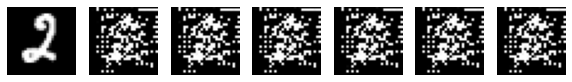

Epoch 5371 g_loss= 6.4135303 d_loss= 0.0016809889 real_acc= 1.0 fake_acc= 1.0
Epoch 5372 g_loss= 6.417748 d_loss= 0.0016672808 real_acc= 1.0 fake_acc= 1.0
Epoch 5373 g_loss= 6.3910217 d_loss= 0.0017059855 real_acc= 1.0 fake_acc= 1.0
Epoch 5374 g_loss= 6.4022956 d_loss= 0.0016905012 real_acc= 1.0 fake_acc= 1.0
Epoch 5375 g_loss= 6.3812656 d_loss= 0.001726989 real_acc= 1.0 fake_acc= 1.0
Epoch 5376 g_loss= 6.4256396 d_loss= 0.0016524184 real_acc= 1.0 fake_acc= 1.0
Epoch 5377 g_loss= 6.3963804 d_loss= 0.0016883551 real_acc= 1.0 fake_acc= 1.0
Epoch 5378 g_loss= 6.394663 d_loss= 0.0016923022 real_acc= 1.0 fake_acc= 1.0
Epoch 5379 g_loss= 6.386309 d_loss= 0.0017156482 real_acc= 1.0 fake_acc= 1.0
Epoch 5380 g_loss= 6.4281244 d_loss= 0.0016449124 real_acc= 1.0 fake_acc= 1.0


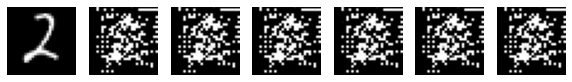

Epoch 5381 g_loss= 6.417936 d_loss= 0.0016583628 real_acc= 1.0 fake_acc= 1.0
Epoch 5382 g_loss= 6.4367313 d_loss= 0.0016420555 real_acc= 1.0 fake_acc= 1.0
Epoch 5383 g_loss= 6.415472 d_loss= 0.0016682536 real_acc= 1.0 fake_acc= 1.0
Epoch 5384 g_loss= 6.420574 d_loss= 0.0016712849 real_acc= 1.0 fake_acc= 1.0
Epoch 5385 g_loss= 6.405703 d_loss= 0.0016872804 real_acc= 1.0 fake_acc= 1.0
Epoch 5386 g_loss= 6.4357533 d_loss= 0.0016338204 real_acc= 1.0 fake_acc= 1.0
Epoch 5387 g_loss= 6.4053054 d_loss= 0.0016839592 real_acc= 1.0 fake_acc= 1.0
Epoch 5388 g_loss= 6.3873806 d_loss= 0.0017120711 real_acc= 1.0 fake_acc= 1.0
Epoch 5389 g_loss= 6.3721743 d_loss= 0.0017475669 real_acc= 1.0 fake_acc= 1.0
Epoch 5390 g_loss= 6.407271 d_loss= 0.0016801613 real_acc= 1.0 fake_acc= 1.0


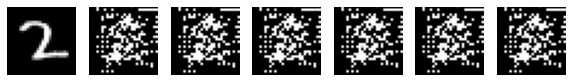

Epoch 5391 g_loss= 6.410777 d_loss= 0.0016763752 real_acc= 1.0 fake_acc= 1.0
Epoch 5392 g_loss= 6.4121885 d_loss= 0.0016719343 real_acc= 1.0 fake_acc= 1.0
Epoch 5393 g_loss= 6.507873 d_loss= 0.001533608 real_acc= 1.0 fake_acc= 1.0
Epoch 5394 g_loss= 6.447727 d_loss= 0.0016134335 real_acc= 1.0 fake_acc= 1.0
Epoch 5395 g_loss= 6.459067 d_loss= 0.0015918409 real_acc= 1.0 fake_acc= 1.0
Epoch 5396 g_loss= 6.475597 d_loss= 0.0015657843 real_acc= 1.0 fake_acc= 1.0
Epoch 5397 g_loss= 6.472162 d_loss= 0.0015763609 real_acc= 1.0 fake_acc= 1.0
Epoch 5398 g_loss= 6.471096 d_loss= 0.0015759331 real_acc= 1.0 fake_acc= 1.0
Epoch 5399 g_loss= 6.434709 d_loss= 0.0016295735 real_acc= 1.0 fake_acc= 1.0
Epoch 5400 g_loss= 6.4867444 d_loss= 0.0015517735 real_acc= 1.0 fake_acc= 1.0


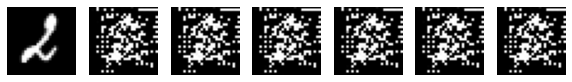

Epoch 5401 g_loss= 6.4892287 d_loss= 0.0015390185 real_acc= 1.0 fake_acc= 1.0
Epoch 5402 g_loss= 6.4982777 d_loss= 0.0015249092 real_acc= 1.0 fake_acc= 1.0
Epoch 5403 g_loss= 6.4166822 d_loss= 0.0016602051 real_acc= 1.0 fake_acc= 1.0
Epoch 5404 g_loss= 6.439039 d_loss= 0.0016475712 real_acc= 1.0 fake_acc= 1.0
Epoch 5405 g_loss= 6.4243135 d_loss= 0.0016489044 real_acc= 1.0 fake_acc= 1.0
Epoch 5406 g_loss= 6.49409 d_loss= 0.0015393452 real_acc= 1.0 fake_acc= 1.0
Epoch 5407 g_loss= 6.45323 d_loss= 0.0015996747 real_acc= 1.0 fake_acc= 1.0
Epoch 5408 g_loss= 6.4674864 d_loss= 0.0015887659 real_acc= 1.0 fake_acc= 1.0
Epoch 5409 g_loss= 6.4685707 d_loss= 0.0015886545 real_acc= 1.0 fake_acc= 1.0
Epoch 5410 g_loss= 6.483218 d_loss= 0.0015488124 real_acc= 1.0 fake_acc= 1.0


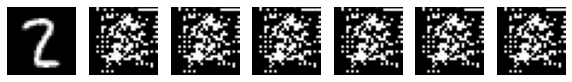

Epoch 5411 g_loss= 6.426202 d_loss= 0.001651537 real_acc= 1.0 fake_acc= 1.0
Epoch 5412 g_loss= 6.4404387 d_loss= 0.0016210726 real_acc= 1.0 fake_acc= 1.0
Epoch 5413 g_loss= 6.4963655 d_loss= 0.0015436122 real_acc= 1.0 fake_acc= 1.0
Epoch 5414 g_loss= 6.5065413 d_loss= 0.0015232047 real_acc= 1.0 fake_acc= 1.0
Epoch 5415 g_loss= 6.438593 d_loss= 0.0016189698 real_acc= 1.0 fake_acc= 1.0
Epoch 5416 g_loss= 6.508909 d_loss= 0.0015147158 real_acc= 1.0 fake_acc= 1.0
Epoch 5417 g_loss= 6.5054426 d_loss= 0.0015296754 real_acc= 1.0 fake_acc= 1.0
Epoch 5418 g_loss= 6.52814 d_loss= 0.0014936555 real_acc= 1.0 fake_acc= 1.0
Epoch 5419 g_loss= 6.5206623 d_loss= 0.0015009674 real_acc= 1.0 fake_acc= 1.0
Epoch 5420 g_loss= 6.534871 d_loss= 0.0014851929 real_acc= 1.0 fake_acc= 1.0


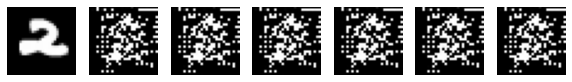

Epoch 5421 g_loss= 6.504478 d_loss= 0.0015215758 real_acc= 1.0 fake_acc= 1.0
Epoch 5422 g_loss= 6.56886 d_loss= 0.0014408072 real_acc= 1.0 fake_acc= 1.0
Epoch 5423 g_loss= 6.498082 d_loss= 0.0015404343 real_acc= 1.0 fake_acc= 1.0
Epoch 5424 g_loss= 6.500719 d_loss= 0.001531492 real_acc= 1.0 fake_acc= 1.0
Epoch 5425 g_loss= 6.572285 d_loss= 0.0014280461 real_acc= 1.0 fake_acc= 1.0
Epoch 5426 g_loss= 6.5227833 d_loss= 0.0015015741 real_acc= 1.0 fake_acc= 1.0
Epoch 5427 g_loss= 6.49319 d_loss= 0.0015420648 real_acc= 1.0 fake_acc= 1.0
Epoch 5428 g_loss= 6.547126 d_loss= 0.0014653066 real_acc= 1.0 fake_acc= 1.0
Epoch 5429 g_loss= 6.4731016 d_loss= 0.0015822069 real_acc= 1.0 fake_acc= 1.0
Epoch 5430 g_loss= 6.5215592 d_loss= 0.0015169394 real_acc= 1.0 fake_acc= 1.0


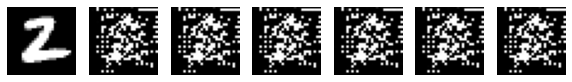

Epoch 5431 g_loss= 6.497717 d_loss= 0.0015386444 real_acc= 1.0 fake_acc= 1.0
Epoch 5432 g_loss= 6.5220428 d_loss= 0.0015022524 real_acc= 1.0 fake_acc= 1.0
Epoch 5433 g_loss= 6.501983 d_loss= 0.0015306203 real_acc= 1.0 fake_acc= 1.0
Epoch 5434 g_loss= 6.5563283 d_loss= 0.0014450672 real_acc= 1.0 fake_acc= 1.0
Epoch 5435 g_loss= 6.510843 d_loss= 0.0015308076 real_acc= 1.0 fake_acc= 1.0
Epoch 5436 g_loss= 6.483259 d_loss= 0.0015614172 real_acc= 1.0 fake_acc= 1.0
Epoch 5437 g_loss= 6.5569515 d_loss= 0.0014475681 real_acc= 1.0 fake_acc= 1.0
Epoch 5438 g_loss= 6.5368724 d_loss= 0.001473304 real_acc= 1.0 fake_acc= 1.0
Epoch 5439 g_loss= 6.558979 d_loss= 0.0014319452 real_acc= 1.0 fake_acc= 1.0
Epoch 5440 g_loss= 6.4633694 d_loss= 0.0015826393 real_acc= 1.0 fake_acc= 1.0


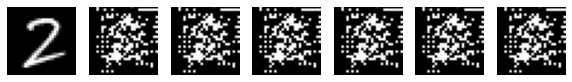

Epoch 5441 g_loss= 6.5550203 d_loss= 0.0014456734 real_acc= 1.0 fake_acc= 1.0
Epoch 5442 g_loss= 6.5297656 d_loss= 0.0014830306 real_acc= 1.0 fake_acc= 1.0
Epoch 5443 g_loss= 6.5652995 d_loss= 0.001428743 real_acc= 1.0 fake_acc= 1.0
Epoch 5444 g_loss= 6.5070796 d_loss= 0.0015262133 real_acc= 1.0 fake_acc= 1.0
Epoch 5445 g_loss= 6.5698442 d_loss= 0.0014304954 real_acc= 1.0 fake_acc= 1.0
Epoch 5446 g_loss= 6.500628 d_loss= 0.0015312546 real_acc= 1.0 fake_acc= 1.0
Epoch 5447 g_loss= 6.551681 d_loss= 0.0014557939 real_acc= 1.0 fake_acc= 1.0
Epoch 5448 g_loss= 6.5533156 d_loss= 0.0014577843 real_acc= 1.0 fake_acc= 1.0
Epoch 5449 g_loss= 6.5909266 d_loss= 0.001394747 real_acc= 1.0 fake_acc= 1.0
Epoch 5450 g_loss= 6.6060095 d_loss= 0.0013918366 real_acc= 1.0 fake_acc= 1.0


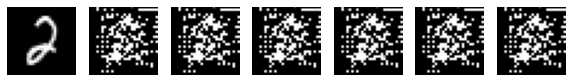

Epoch 5451 g_loss= 6.638319 d_loss= 0.0013359739 real_acc= 1.0 fake_acc= 1.0
Epoch 5452 g_loss= 6.578977 d_loss= 0.0014200194 real_acc= 1.0 fake_acc= 1.0
Epoch 5453 g_loss= 6.603884 d_loss= 0.0013958516 real_acc= 1.0 fake_acc= 1.0
Epoch 5454 g_loss= 6.5483418 d_loss= 0.001457839 real_acc= 1.0 fake_acc= 1.0
Epoch 5455 g_loss= 6.582642 d_loss= 0.0014119311 real_acc= 1.0 fake_acc= 1.0
Epoch 5456 g_loss= 6.588503 d_loss= 0.0014061803 real_acc= 1.0 fake_acc= 1.0
Epoch 5457 g_loss= 6.5979705 d_loss= 0.0013890252 real_acc= 1.0 fake_acc= 1.0
Epoch 5458 g_loss= 6.6131806 d_loss= 0.0013696589 real_acc= 1.0 fake_acc= 1.0
Epoch 5459 g_loss= 6.5871606 d_loss= 0.0013952502 real_acc= 1.0 fake_acc= 1.0
Epoch 5460 g_loss= 6.6188507 d_loss= 0.0013598646 real_acc= 1.0 fake_acc= 1.0


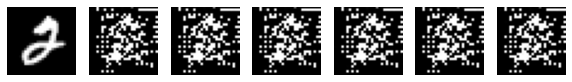

Epoch 5461 g_loss= 6.578142 d_loss= 0.0014189251 real_acc= 1.0 fake_acc= 1.0
Epoch 5462 g_loss= 6.5682483 d_loss= 0.0014297069 real_acc= 1.0 fake_acc= 1.0
Epoch 5463 g_loss= 6.5918016 d_loss= 0.0014069717 real_acc= 1.0 fake_acc= 1.0
Epoch 5464 g_loss= 6.6378613 d_loss= 0.0013274658 real_acc= 1.0 fake_acc= 1.0
Epoch 5465 g_loss= 6.6207194 d_loss= 0.0013636898 real_acc= 1.0 fake_acc= 1.0
Epoch 5466 g_loss= 6.5639133 d_loss= 0.0024900783 real_acc= 1.0 fake_acc= 1.0
Epoch 5467 g_loss= 6.625211 d_loss= 0.0013593598 real_acc= 1.0 fake_acc= 1.0
Epoch 5468 g_loss= 6.6323357 d_loss= 0.0013428925 real_acc= 1.0 fake_acc= 1.0
Epoch 5469 g_loss= 6.5859785 d_loss= 0.0014157126 real_acc= 1.0 fake_acc= 1.0
Epoch 5470 g_loss= 6.569479 d_loss= 0.0014410573 real_acc= 1.0 fake_acc= 1.0


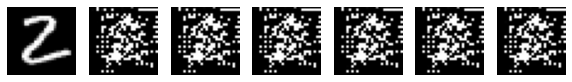

Epoch 5471 g_loss= 6.633309 d_loss= 0.0013396334 real_acc= 1.0 fake_acc= 1.0
Epoch 5472 g_loss= 6.616275 d_loss= 0.0013638907 real_acc= 1.0 fake_acc= 1.0
Epoch 5473 g_loss= 6.6060243 d_loss= 0.0013783218 real_acc= 1.0 fake_acc= 1.0
Epoch 5474 g_loss= 6.550282 d_loss= 0.0014550516 real_acc= 1.0 fake_acc= 1.0
Epoch 5475 g_loss= 6.635574 d_loss= 0.0013297971 real_acc= 1.0 fake_acc= 1.0
Epoch 5476 g_loss= 6.6123867 d_loss= 0.001369685 real_acc= 1.0 fake_acc= 1.0
Epoch 5477 g_loss= 6.609332 d_loss= 0.0013715375 real_acc= 1.0 fake_acc= 1.0
Epoch 5478 g_loss= 6.578988 d_loss= 0.001415294 real_acc= 1.0 fake_acc= 1.0
Epoch 5479 g_loss= 6.628606 d_loss= 0.001343091 real_acc= 1.0 fake_acc= 1.0
Epoch 5480 g_loss= 6.5820704 d_loss= 0.0014158376 real_acc= 1.0 fake_acc= 1.0


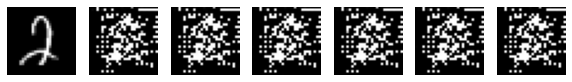

Epoch 5481 g_loss= 6.5836186 d_loss= 0.0014139343 real_acc= 1.0 fake_acc= 1.0
Epoch 5482 g_loss= 6.5995073 d_loss= 0.0013878304 real_acc= 1.0 fake_acc= 1.0
Epoch 5483 g_loss= 6.549676 d_loss= 0.0014604032 real_acc= 1.0 fake_acc= 1.0
Epoch 5484 g_loss= 6.6270933 d_loss= 0.0013529296 real_acc= 1.0 fake_acc= 1.0
Epoch 5485 g_loss= 6.587429 d_loss= 0.001402295 real_acc= 1.0 fake_acc= 1.0
Epoch 5486 g_loss= 6.614036 d_loss= 0.0013692516 real_acc= 1.0 fake_acc= 1.0
Epoch 5487 g_loss= 6.603618 d_loss= 0.00138107 real_acc= 1.0 fake_acc= 1.0
Epoch 5488 g_loss= 6.5818353 d_loss= 0.0014143835 real_acc= 1.0 fake_acc= 1.0
Epoch 5489 g_loss= 6.62862 d_loss= 0.0013489429 real_acc= 1.0 fake_acc= 1.0
Epoch 5490 g_loss= 6.5601487 d_loss= 0.0014465475 real_acc= 1.0 fake_acc= 1.0


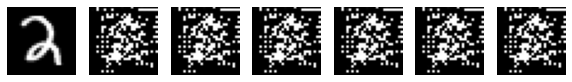

Epoch 5491 g_loss= 6.665469 d_loss= 0.0012957088 real_acc= 1.0 fake_acc= 1.0
Epoch 5492 g_loss= 6.564948 d_loss= 0.001432015 real_acc= 1.0 fake_acc= 1.0
Epoch 5493 g_loss= 6.5616593 d_loss= 0.0014316938 real_acc= 1.0 fake_acc= 1.0
Epoch 5494 g_loss= 6.604272 d_loss= 0.001374706 real_acc= 1.0 fake_acc= 1.0
Epoch 5495 g_loss= 6.6096478 d_loss= 0.0013664778 real_acc= 1.0 fake_acc= 1.0
Epoch 5496 g_loss= 6.6337557 d_loss= 0.0013407755 real_acc= 1.0 fake_acc= 1.0
Epoch 5497 g_loss= 6.6560183 d_loss= 0.0013011829 real_acc= 1.0 fake_acc= 1.0
Epoch 5498 g_loss= 6.643736 d_loss= 0.0013291601 real_acc= 1.0 fake_acc= 1.0
Epoch 5499 g_loss= 6.6050115 d_loss= 0.0013792391 real_acc= 1.0 fake_acc= 1.0
Epoch 5500 g_loss= 6.6428943 d_loss= 0.0013252093 real_acc= 1.0 fake_acc= 1.0


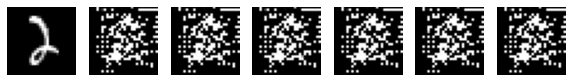

Epoch 5501 g_loss= 6.616521 d_loss= 0.0013603884 real_acc= 1.0 fake_acc= 1.0
Epoch 5502 g_loss= 6.574861 d_loss= 0.0014172993 real_acc= 1.0 fake_acc= 1.0
Epoch 5503 g_loss= 6.6096544 d_loss= 0.0013806798 real_acc= 1.0 fake_acc= 1.0
Epoch 5504 g_loss= 6.6674695 d_loss= 0.0012936165 real_acc= 1.0 fake_acc= 1.0
Epoch 5505 g_loss= 6.6485167 d_loss= 0.0013127715 real_acc= 1.0 fake_acc= 1.0
Epoch 5506 g_loss= 6.6531463 d_loss= 0.0013208662 real_acc= 1.0 fake_acc= 1.0
Epoch 5507 g_loss= 6.635476 d_loss= 0.0013312133 real_acc= 1.0 fake_acc= 1.0
Epoch 5508 g_loss= 6.678147 d_loss= 0.001275803 real_acc= 1.0 fake_acc= 1.0
Epoch 5509 g_loss= 6.6461773 d_loss= 0.001335597 real_acc= 1.0 fake_acc= 1.0
Epoch 5510 g_loss= 6.6691875 d_loss= 0.0012973931 real_acc= 1.0 fake_acc= 1.0


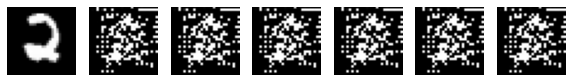

Epoch 5511 g_loss= 6.605119 d_loss= 0.0013783743 real_acc= 1.0 fake_acc= 1.0
Epoch 5512 g_loss= 6.625226 d_loss= 0.0013484386 real_acc= 1.0 fake_acc= 1.0
Epoch 5513 g_loss= 6.676043 d_loss= 0.0012854913 real_acc= 1.0 fake_acc= 1.0
Epoch 5514 g_loss= 6.650076 d_loss= 0.0013190107 real_acc= 1.0 fake_acc= 1.0
Epoch 5515 g_loss= 6.6851864 d_loss= 0.0012773398 real_acc= 1.0 fake_acc= 1.0
Epoch 5516 g_loss= 6.640769 d_loss= 0.0013411588 real_acc= 1.0 fake_acc= 1.0
Epoch 5517 g_loss= 6.6330853 d_loss= 0.0013394305 real_acc= 1.0 fake_acc= 1.0
Epoch 5518 g_loss= 6.669087 d_loss= 0.0012969974 real_acc= 1.0 fake_acc= 1.0
Epoch 5519 g_loss= 6.6912036 d_loss= 0.0012615247 real_acc= 1.0 fake_acc= 1.0
Epoch 5520 g_loss= 6.666183 d_loss= 0.0013180886 real_acc= 1.0 fake_acc= 1.0


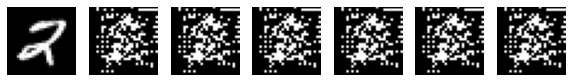

Epoch 5521 g_loss= 6.7105336 d_loss= 0.0012423414 real_acc= 1.0 fake_acc= 1.0
Epoch 5522 g_loss= 6.7246914 d_loss= 0.0012247923 real_acc= 1.0 fake_acc= 1.0
Epoch 5523 g_loss= 6.6933203 d_loss= 0.0012636273 real_acc= 1.0 fake_acc= 1.0
Epoch 5524 g_loss= 6.742551 d_loss= 0.0012037114 real_acc= 1.0 fake_acc= 1.0
Epoch 5525 g_loss= 6.6759963 d_loss= 0.001280474 real_acc= 1.0 fake_acc= 1.0
Epoch 5526 g_loss= 6.6947 d_loss= 0.0012610134 real_acc= 1.0 fake_acc= 1.0
Epoch 5527 g_loss= 6.706017 d_loss= 0.0012490881 real_acc= 1.0 fake_acc= 1.0
Epoch 5528 g_loss= 6.7217627 d_loss= 0.0012291343 real_acc= 1.0 fake_acc= 1.0
Epoch 5529 g_loss= 6.7002916 d_loss= 0.0012587245 real_acc= 1.0 fake_acc= 1.0
Epoch 5530 g_loss= 6.695904 d_loss= 0.0012601772 real_acc= 1.0 fake_acc= 1.0


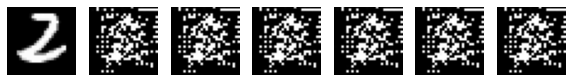

Epoch 5531 g_loss= 6.7180824 d_loss= 0.0012442771 real_acc= 1.0 fake_acc= 1.0
Epoch 5532 g_loss= 6.686883 d_loss= 0.0012671187 real_acc= 1.0 fake_acc= 1.0
Epoch 5533 g_loss= 6.7035093 d_loss= 0.0012636461 real_acc= 1.0 fake_acc= 1.0
Epoch 5534 g_loss= 6.7170043 d_loss= 0.0012409943 real_acc= 1.0 fake_acc= 1.0
Epoch 5535 g_loss= 6.747469 d_loss= 0.0043444596 real_acc= 1.0 fake_acc= 1.0
Epoch 5536 g_loss= 6.716605 d_loss= 0.0012314608 real_acc= 1.0 fake_acc= 1.0
Epoch 5537 g_loss= 6.7169924 d_loss= 0.0012367028 real_acc= 1.0 fake_acc= 1.0
Epoch 5538 g_loss= 6.692685 d_loss= 0.0012579224 real_acc= 1.0 fake_acc= 1.0
Epoch 5539 g_loss= 6.6794834 d_loss= 0.0012856218 real_acc= 1.0 fake_acc= 1.0
Epoch 5540 g_loss= 6.682623 d_loss= 0.0012765329 real_acc= 1.0 fake_acc= 1.0


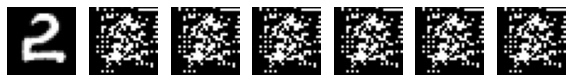

Epoch 5541 g_loss= 6.6959248 d_loss= 0.0012605633 real_acc= 1.0 fake_acc= 1.0
Epoch 5542 g_loss= 6.683846 d_loss= 0.0012729652 real_acc= 1.0 fake_acc= 1.0
Epoch 5543 g_loss= 6.6363964 d_loss= 0.0013390625 real_acc= 1.0 fake_acc= 1.0
Epoch 5544 g_loss= 6.6646514 d_loss= 0.0012954281 real_acc= 1.0 fake_acc= 1.0
Epoch 5545 g_loss= 6.62372 d_loss= 0.001354144 real_acc= 1.0 fake_acc= 1.0
Epoch 5546 g_loss= 6.6812286 d_loss= 0.0012721292 real_acc= 1.0 fake_acc= 1.0
Epoch 5547 g_loss= 6.632828 d_loss= 0.0013473396 real_acc= 1.0 fake_acc= 1.0
Epoch 5548 g_loss= 6.6297755 d_loss= 0.0013404194 real_acc= 1.0 fake_acc= 1.0
Epoch 5549 g_loss= 6.6775804 d_loss= 0.0012846894 real_acc= 1.0 fake_acc= 1.0
Epoch 5550 g_loss= 6.655931 d_loss= 0.0013044928 real_acc= 1.0 fake_acc= 1.0


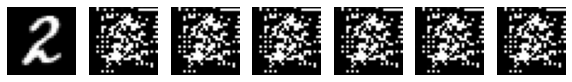

Epoch 5551 g_loss= 6.6680036 d_loss= 0.0013134026 real_acc= 1.0 fake_acc= 1.0
Epoch 5552 g_loss= 6.6676006 d_loss= 0.0013056839 real_acc= 1.0 fake_acc= 1.0
Epoch 5553 g_loss= 6.6253133 d_loss= 0.0013528564 real_acc= 1.0 fake_acc= 1.0
Epoch 5554 g_loss= 6.676415 d_loss= 0.00128101 real_acc= 1.0 fake_acc= 1.0
Epoch 5555 g_loss= 6.689276 d_loss= 0.0012736128 real_acc= 1.0 fake_acc= 1.0
Epoch 5556 g_loss= 6.614743 d_loss= 0.0013669898 real_acc= 1.0 fake_acc= 1.0
Epoch 5557 g_loss= 6.6338496 d_loss= 0.001339789 real_acc= 1.0 fake_acc= 1.0
Epoch 5558 g_loss= 6.6602917 d_loss= 0.0013024178 real_acc= 1.0 fake_acc= 1.0
Epoch 5559 g_loss= 6.6983705 d_loss= 0.0012669289 real_acc= 1.0 fake_acc= 1.0
Epoch 5560 g_loss= 6.708921 d_loss= 0.0012460887 real_acc= 1.0 fake_acc= 1.0


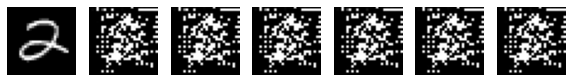

Epoch 5561 g_loss= 6.673748 d_loss= 0.0012891096 real_acc= 1.0 fake_acc= 1.0
Epoch 5562 g_loss= 6.676551 d_loss= 0.0012830306 real_acc= 1.0 fake_acc= 1.0
Epoch 5563 g_loss= 6.7045617 d_loss= 0.001250167 real_acc= 1.0 fake_acc= 1.0
Epoch 5564 g_loss= 6.7009144 d_loss= 0.001259718 real_acc= 1.0 fake_acc= 1.0
Epoch 5565 g_loss= 6.68294 d_loss= 0.0012756347 real_acc= 1.0 fake_acc= 1.0
Epoch 5566 g_loss= 6.7209992 d_loss= 0.0012251618 real_acc= 1.0 fake_acc= 1.0
Epoch 5567 g_loss= 6.6956487 d_loss= 0.0012620037 real_acc= 1.0 fake_acc= 1.0
Epoch 5568 g_loss= 6.6967883 d_loss= 0.0012645903 real_acc= 1.0 fake_acc= 1.0
Epoch 5569 g_loss= 6.679819 d_loss= 0.0012816485 real_acc= 1.0 fake_acc= 1.0
Epoch 5570 g_loss= 6.6823444 d_loss= 0.0012773913 real_acc= 1.0 fake_acc= 1.0


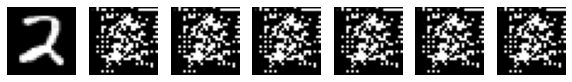

Epoch 5571 g_loss= 6.6516085 d_loss= 0.0013101862 real_acc= 1.0 fake_acc= 1.0
Epoch 5572 g_loss= 6.726816 d_loss= 0.0012290025 real_acc= 1.0 fake_acc= 1.0
Epoch 5573 g_loss= 6.7067223 d_loss= 0.0012652301 real_acc= 1.0 fake_acc= 1.0
Epoch 5574 g_loss= 6.676792 d_loss= 0.0012878572 real_acc= 1.0 fake_acc= 1.0
Epoch 5575 g_loss= 6.682159 d_loss= 0.0012780501 real_acc= 1.0 fake_acc= 1.0
Epoch 5576 g_loss= 6.674151 d_loss= 0.0012889664 real_acc= 1.0 fake_acc= 1.0
Epoch 5577 g_loss= 6.6748204 d_loss= 0.0012899053 real_acc= 1.0 fake_acc= 1.0
Epoch 5578 g_loss= 6.6975145 d_loss= 0.0012504688 real_acc= 1.0 fake_acc= 1.0
Epoch 5579 g_loss= 6.684217 d_loss= 0.001281019 real_acc= 1.0 fake_acc= 1.0
Epoch 5580 g_loss= 6.672045 d_loss= 0.0012908902 real_acc= 1.0 fake_acc= 1.0


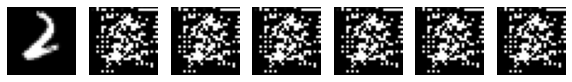

Epoch 5581 g_loss= 6.7044525 d_loss= 0.001245327 real_acc= 1.0 fake_acc= 1.0
Epoch 5582 g_loss= 6.675246 d_loss= 0.0012892995 real_acc= 1.0 fake_acc= 1.0
Epoch 5583 g_loss= 6.7398047 d_loss= 0.0012049028 real_acc= 1.0 fake_acc= 1.0
Epoch 5584 g_loss= 6.639831 d_loss= 0.0013320534 real_acc= 1.0 fake_acc= 1.0
Epoch 5585 g_loss= 6.6958094 d_loss= 0.001256919 real_acc= 1.0 fake_acc= 1.0
Epoch 5586 g_loss= 6.7332015 d_loss= 0.0012093018 real_acc= 1.0 fake_acc= 1.0
Epoch 5587 g_loss= 6.7070613 d_loss= 0.001244091 real_acc= 1.0 fake_acc= 1.0
Epoch 5588 g_loss= 6.701676 d_loss= 0.0012592967 real_acc= 1.0 fake_acc= 1.0
Epoch 5589 g_loss= 6.688646 d_loss= 0.0012683218 real_acc= 1.0 fake_acc= 1.0
Epoch 5590 g_loss= 6.7196608 d_loss= 0.0012323692 real_acc= 1.0 fake_acc= 1.0


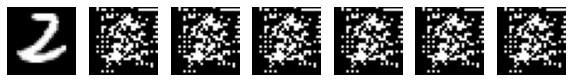

Epoch 5591 g_loss= 6.7135363 d_loss= 0.0012446854 real_acc= 1.0 fake_acc= 1.0
Epoch 5592 g_loss= 6.743953 d_loss= 0.001202936 real_acc= 1.0 fake_acc= 1.0
Epoch 5593 g_loss= 6.7420635 d_loss= 0.0012002309 real_acc= 1.0 fake_acc= 1.0
Epoch 5594 g_loss= 6.6999474 d_loss= 0.0012525255 real_acc= 1.0 fake_acc= 1.0
Epoch 5595 g_loss= 6.753619 d_loss= 0.0011906653 real_acc= 1.0 fake_acc= 1.0
Epoch 5596 g_loss= 6.734996 d_loss= 0.0012134488 real_acc= 1.0 fake_acc= 1.0
Epoch 5597 g_loss= 6.739538 d_loss= 0.0012138988 real_acc= 1.0 fake_acc= 1.0
Epoch 5598 g_loss= 6.7772346 d_loss= 0.0011668014 real_acc= 1.0 fake_acc= 1.0
Epoch 5599 g_loss= 6.752539 d_loss= 0.0011897171 real_acc= 1.0 fake_acc= 1.0
Epoch 5600 g_loss= 6.7232513 d_loss= 0.0012316705 real_acc= 1.0 fake_acc= 1.0


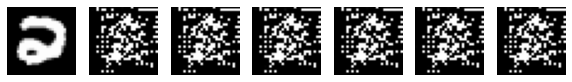

Epoch 5601 g_loss= 6.7291284 d_loss= 0.0012201632 real_acc= 1.0 fake_acc= 1.0
Epoch 5602 g_loss= 6.8146305 d_loss= 0.0011241419 real_acc= 1.0 fake_acc= 1.0
Epoch 5603 g_loss= 6.818974 d_loss= 0.0011128536 real_acc= 1.0 fake_acc= 1.0
Epoch 5604 g_loss= 6.773511 d_loss= 0.0011728905 real_acc= 1.0 fake_acc= 1.0
Epoch 5605 g_loss= 6.7420526 d_loss= 0.0012105936 real_acc= 1.0 fake_acc= 1.0
Epoch 5606 g_loss= 6.7560377 d_loss= 0.0011820899 real_acc= 1.0 fake_acc= 1.0
Epoch 5607 g_loss= 6.7693157 d_loss= 0.001171033 real_acc= 1.0 fake_acc= 1.0
Epoch 5608 g_loss= 6.794665 d_loss= 0.0011404025 real_acc= 1.0 fake_acc= 1.0
Epoch 5609 g_loss= 6.7157273 d_loss= 0.0012282603 real_acc= 1.0 fake_acc= 1.0
Epoch 5610 g_loss= 6.699725 d_loss= 0.0012536122 real_acc= 1.0 fake_acc= 1.0


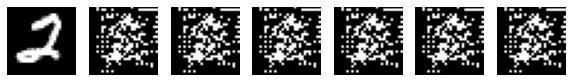

Epoch 5611 g_loss= 6.773424 d_loss= 0.0011795657 real_acc= 1.0 fake_acc= 1.0
Epoch 5612 g_loss= 6.7094917 d_loss= 0.0012447392 real_acc= 1.0 fake_acc= 1.0
Epoch 5613 g_loss= 6.835918 d_loss= 0.0010899628 real_acc= 1.0 fake_acc= 1.0
Epoch 5614 g_loss= 6.7997704 d_loss= 0.0011302282 real_acc= 1.0 fake_acc= 1.0
Epoch 5615 g_loss= 6.7793136 d_loss= 0.0011543677 real_acc= 1.0 fake_acc= 1.0
Epoch 5616 g_loss= 6.733615 d_loss= 0.0012206115 real_acc= 1.0 fake_acc= 1.0
Epoch 5617 g_loss= 6.7821083 d_loss= 0.001159623 real_acc= 1.0 fake_acc= 1.0
Epoch 5618 g_loss= 6.786312 d_loss= 0.0011580009 real_acc= 1.0 fake_acc= 1.0
Epoch 5619 g_loss= 6.792479 d_loss= 0.0011431783 real_acc= 1.0 fake_acc= 1.0
Epoch 5620 g_loss= 6.846021 d_loss= 0.0010864559 real_acc= 1.0 fake_acc= 1.0


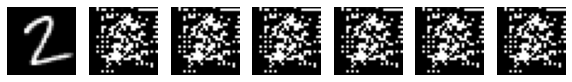

Epoch 5621 g_loss= 6.8211083 d_loss= 0.0011124263 real_acc= 1.0 fake_acc= 1.0
Epoch 5622 g_loss= 6.7234125 d_loss= 0.0012235191 real_acc= 1.0 fake_acc= 1.0
Epoch 5623 g_loss= 6.796198 d_loss= 0.0011524905 real_acc= 1.0 fake_acc= 1.0
Epoch 5624 g_loss= 6.789886 d_loss= 0.00115256 real_acc= 1.0 fake_acc= 1.0
Epoch 5625 g_loss= 6.797621 d_loss= 0.0011374931 real_acc= 1.0 fake_acc= 1.0
Epoch 5626 g_loss= 6.8203754 d_loss= 0.0011134754 real_acc= 1.0 fake_acc= 1.0
Epoch 5627 g_loss= 6.838942 d_loss= 0.0010920702 real_acc= 1.0 fake_acc= 1.0
Epoch 5628 g_loss= 6.7811694 d_loss= 0.001155558 real_acc= 1.0 fake_acc= 1.0
Epoch 5629 g_loss= 6.7741284 d_loss= 0.0011641092 real_acc= 1.0 fake_acc= 1.0
Epoch 5630 g_loss= 6.85264 d_loss= 0.0010838928 real_acc= 1.0 fake_acc= 1.0


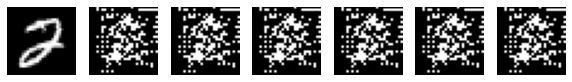

Epoch 5631 g_loss= 6.8017025 d_loss= 0.0011378643 real_acc= 1.0 fake_acc= 1.0
Epoch 5632 g_loss= 6.803554 d_loss= 0.001130946 real_acc= 1.0 fake_acc= 1.0
Epoch 5633 g_loss= 6.796637 d_loss= 0.0011410869 real_acc= 1.0 fake_acc= 1.0
Epoch 5634 g_loss= 6.831925 d_loss= 0.0010938267 real_acc= 1.0 fake_acc= 1.0
Epoch 5635 g_loss= 6.819667 d_loss= 0.0011149172 real_acc= 1.0 fake_acc= 1.0
Epoch 5636 g_loss= 6.807087 d_loss= 0.0011275801 real_acc= 1.0 fake_acc= 1.0
Epoch 5637 g_loss= 6.8466277 d_loss= 0.0010871317 real_acc= 1.0 fake_acc= 1.0
Epoch 5638 g_loss= 6.805871 d_loss= 0.0011288084 real_acc= 1.0 fake_acc= 1.0
Epoch 5639 g_loss= 6.861049 d_loss= 0.0010731132 real_acc= 1.0 fake_acc= 1.0
Epoch 5640 g_loss= 6.7882695 d_loss= 0.0011476548 real_acc= 1.0 fake_acc= 1.0


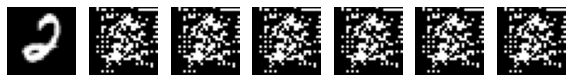

Epoch 5641 g_loss= 6.871524 d_loss= 0.001055422 real_acc= 1.0 fake_acc= 1.0
Epoch 5642 g_loss= 6.837871 d_loss= 0.0010993666 real_acc= 1.0 fake_acc= 1.0
Epoch 5643 g_loss= 6.851808 d_loss= 0.0010829328 real_acc= 1.0 fake_acc= 1.0
Epoch 5644 g_loss= 6.8284936 d_loss= 0.0011024952 real_acc= 1.0 fake_acc= 1.0
Epoch 5645 g_loss= 6.8554564 d_loss= 0.0010820419 real_acc= 1.0 fake_acc= 1.0
Epoch 5646 g_loss= 6.8470025 d_loss= 0.0010819744 real_acc= 1.0 fake_acc= 1.0
Epoch 5647 g_loss= 6.8436756 d_loss= 0.0010878687 real_acc= 1.0 fake_acc= 1.0
Epoch 5648 g_loss= 6.85488 d_loss= 0.001075146 real_acc= 1.0 fake_acc= 1.0
Epoch 5649 g_loss= 6.8997374 d_loss= 0.0010242763 real_acc= 1.0 fake_acc= 1.0
Epoch 5650 g_loss= 6.844467 d_loss= 0.0010905202 real_acc= 1.0 fake_acc= 1.0


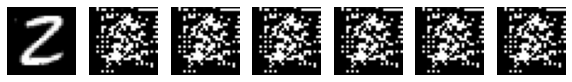

Epoch 5651 g_loss= 6.8365064 d_loss= 0.0010977939 real_acc= 1.0 fake_acc= 1.0
Epoch 5652 g_loss= 6.854885 d_loss= 0.0010710355 real_acc= 1.0 fake_acc= 1.0
Epoch 5653 g_loss= 6.896909 d_loss= 0.0010361009 real_acc= 1.0 fake_acc= 1.0
Epoch 5654 g_loss= 6.895943 d_loss= 0.0010344443 real_acc= 1.0 fake_acc= 1.0
Epoch 5655 g_loss= 6.8721604 d_loss= 0.0010640511 real_acc= 1.0 fake_acc= 1.0
Epoch 5656 g_loss= 6.8637896 d_loss= 0.0010657463 real_acc= 1.0 fake_acc= 1.0
Epoch 5657 g_loss= 6.8616805 d_loss= 0.0010643677 real_acc= 1.0 fake_acc= 1.0
Epoch 5658 g_loss= 6.916075 d_loss= 0.001012323 real_acc= 1.0 fake_acc= 1.0
Epoch 5659 g_loss= 6.8232894 d_loss= 0.0011098785 real_acc= 1.0 fake_acc= 1.0
Epoch 5660 g_loss= 6.887848 d_loss= 0.0010390033 real_acc= 1.0 fake_acc= 1.0


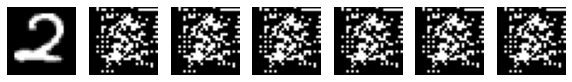

Epoch 5661 g_loss= 6.8777714 d_loss= 0.0010589592 real_acc= 1.0 fake_acc= 1.0
Epoch 5662 g_loss= 6.884245 d_loss= 0.001037813 real_acc= 1.0 fake_acc= 1.0
Epoch 5663 g_loss= 6.8737755 d_loss= 0.0010604966 real_acc= 1.0 fake_acc= 1.0
Epoch 5664 g_loss= 6.8751736 d_loss= 0.0010581875 real_acc= 1.0 fake_acc= 1.0
Epoch 5665 g_loss= 6.851924 d_loss= 0.0010794863 real_acc= 1.0 fake_acc= 1.0
Epoch 5666 g_loss= 6.8587894 d_loss= 0.001067804 real_acc= 1.0 fake_acc= 1.0
Epoch 5667 g_loss= 6.8831873 d_loss= 0.0010493144 real_acc= 1.0 fake_acc= 1.0
Epoch 5668 g_loss= 6.8880634 d_loss= 0.0010439297 real_acc= 1.0 fake_acc= 1.0
Epoch 5669 g_loss= 6.8611035 d_loss= 0.001074815 real_acc= 1.0 fake_acc= 1.0
Epoch 5670 g_loss= 6.8872895 d_loss= 0.0010434822 real_acc= 1.0 fake_acc= 1.0


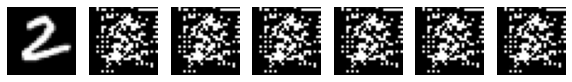

Epoch 5671 g_loss= 6.9337053 d_loss= 0.0009997296 real_acc= 1.0 fake_acc= 1.0
Epoch 5672 g_loss= 6.81474 d_loss= 0.0011297298 real_acc= 1.0 fake_acc= 1.0
Epoch 5673 g_loss= 6.8531284 d_loss= 0.0010815472 real_acc= 1.0 fake_acc= 1.0
Epoch 5674 g_loss= 6.9030156 d_loss= 0.0010239632 real_acc= 1.0 fake_acc= 1.0
Epoch 5675 g_loss= 6.8894134 d_loss= 0.0010471544 real_acc= 1.0 fake_acc= 1.0
Epoch 5676 g_loss= 6.894956 d_loss= 0.0010375652 real_acc= 1.0 fake_acc= 1.0
Epoch 5677 g_loss= 6.8961916 d_loss= 0.0010373881 real_acc= 1.0 fake_acc= 1.0
Epoch 5678 g_loss= 6.906186 d_loss= 0.0010257501 real_acc= 1.0 fake_acc= 1.0
Epoch 5679 g_loss= 6.885958 d_loss= 0.0010564269 real_acc= 1.0 fake_acc= 1.0
Epoch 5680 g_loss= 6.918219 d_loss= 0.0010084567 real_acc= 1.0 fake_acc= 1.0


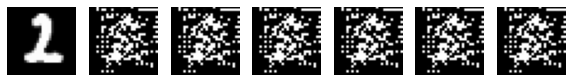

Epoch 5681 g_loss= 6.945027 d_loss= 0.0009813694 real_acc= 1.0 fake_acc= 1.0
Epoch 5682 g_loss= 6.972735 d_loss= 0.0009553238 real_acc= 1.0 fake_acc= 1.0
Epoch 5683 g_loss= 6.9109826 d_loss= 0.0010121361 real_acc= 1.0 fake_acc= 1.0
Epoch 5684 g_loss= 6.8913317 d_loss= 0.0010416745 real_acc= 1.0 fake_acc= 1.0
Epoch 5685 g_loss= 6.9499187 d_loss= 0.000986006 real_acc= 1.0 fake_acc= 1.0
Epoch 5686 g_loss= 6.934202 d_loss= 0.0009957573 real_acc= 1.0 fake_acc= 1.0
Epoch 5687 g_loss= 6.927673 d_loss= 0.0010030444 real_acc= 1.0 fake_acc= 1.0
Epoch 5688 g_loss= 6.9306602 d_loss= 0.0009939433 real_acc= 1.0 fake_acc= 1.0
Epoch 5689 g_loss= 6.9388933 d_loss= 0.0009914311 real_acc= 1.0 fake_acc= 1.0
Epoch 5690 g_loss= 6.9334593 d_loss= 0.0009999075 real_acc= 1.0 fake_acc= 1.0


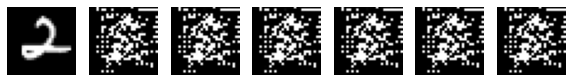

Epoch 5691 g_loss= 6.899779 d_loss= 0.0010345721 real_acc= 1.0 fake_acc= 1.0
Epoch 5692 g_loss= 6.96214 d_loss= 0.00096092024 real_acc= 1.0 fake_acc= 1.0
Epoch 5693 g_loss= 6.8783402 d_loss= 0.0010471385 real_acc= 1.0 fake_acc= 1.0
Epoch 5694 g_loss= 6.9185925 d_loss= 0.0010039009 real_acc= 1.0 fake_acc= 1.0
Epoch 5695 g_loss= 6.9357204 d_loss= 0.0009964393 real_acc= 1.0 fake_acc= 1.0
Epoch 5696 g_loss= 6.9156284 d_loss= 0.0010096163 real_acc= 1.0 fake_acc= 1.0
Epoch 5697 g_loss= 6.9309363 d_loss= 0.0009954552 real_acc= 1.0 fake_acc= 1.0
Epoch 5698 g_loss= 6.983841 d_loss= 0.000941632 real_acc= 1.0 fake_acc= 1.0
Epoch 5699 g_loss= 7.0165467 d_loss= 0.0009159273 real_acc= 1.0 fake_acc= 1.0
Epoch 5700 g_loss= 6.9918976 d_loss= 0.0009408832 real_acc= 1.0 fake_acc= 1.0


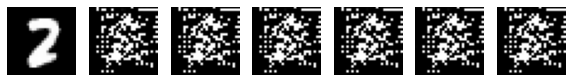

Epoch 5701 g_loss= 6.9621706 d_loss= 0.00095915265 real_acc= 1.0 fake_acc= 1.0
Epoch 5702 g_loss= 6.9921904 d_loss= 0.00093713327 real_acc= 1.0 fake_acc= 1.0
Epoch 5703 g_loss= 6.91718 d_loss= 0.0010077766 real_acc= 1.0 fake_acc= 1.0
Epoch 5704 g_loss= 6.9744244 d_loss= 0.00095493696 real_acc= 1.0 fake_acc= 1.0
Epoch 5705 g_loss= 6.9392815 d_loss= 0.0009944645 real_acc= 1.0 fake_acc= 1.0
Epoch 5706 g_loss= 6.9689703 d_loss= 0.00096418685 real_acc= 1.0 fake_acc= 1.0
Epoch 5707 g_loss= 6.9634995 d_loss= 0.0009634037 real_acc= 1.0 fake_acc= 1.0
Epoch 5708 g_loss= 6.9549274 d_loss= 0.00097575056 real_acc= 1.0 fake_acc= 1.0
Epoch 5709 g_loss= 6.954603 d_loss= 0.00097279047 real_acc= 1.0 fake_acc= 1.0
Epoch 5710 g_loss= 6.9625077 d_loss= 0.00096891006 real_acc= 1.0 fake_acc= 1.0


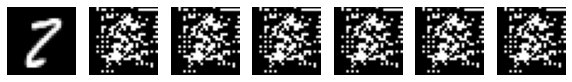

Epoch 5711 g_loss= 7.00063 d_loss= 0.00092370244 real_acc= 1.0 fake_acc= 1.0
Epoch 5712 g_loss= 6.958756 d_loss= 0.0009760327 real_acc= 1.0 fake_acc= 1.0
Epoch 5713 g_loss= 7.0409193 d_loss= 0.0008913454 real_acc= 1.0 fake_acc= 1.0
Epoch 5714 g_loss= 6.9736004 d_loss= 0.00095588446 real_acc= 1.0 fake_acc= 1.0
Epoch 5715 g_loss= 6.9785457 d_loss= 0.00094885024 real_acc= 1.0 fake_acc= 1.0
Epoch 5716 g_loss= 6.926157 d_loss= 0.0010035745 real_acc= 1.0 fake_acc= 1.0
Epoch 5717 g_loss= 7.007632 d_loss= 0.00092504063 real_acc= 1.0 fake_acc= 1.0
Epoch 5718 g_loss= 6.9822316 d_loss= 0.0009427591 real_acc= 1.0 fake_acc= 1.0
Epoch 5719 g_loss= 7.0389404 d_loss= 0.00089631625 real_acc= 1.0 fake_acc= 1.0
Epoch 5720 g_loss= 7.0162377 d_loss= 0.000920824 real_acc= 1.0 fake_acc= 1.0


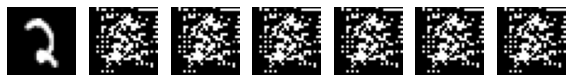

Epoch 5721 g_loss= 6.968819 d_loss= 0.0009642789 real_acc= 1.0 fake_acc= 1.0
Epoch 5722 g_loss= 7.027796 d_loss= 0.0009015511 real_acc= 1.0 fake_acc= 1.0
Epoch 5723 g_loss= 6.9309564 d_loss= 0.000998436 real_acc= 1.0 fake_acc= 1.0
Epoch 5724 g_loss= 7.0037627 d_loss= 0.0009284816 real_acc= 1.0 fake_acc= 1.0
Epoch 5725 g_loss= 7.0380287 d_loss= 0.0008999889 real_acc= 1.0 fake_acc= 1.0
Epoch 5726 g_loss= 6.974858 d_loss= 0.00095691567 real_acc= 1.0 fake_acc= 1.0
Epoch 5727 g_loss= 7.0326066 d_loss= 0.00090380834 real_acc= 1.0 fake_acc= 1.0
Epoch 5728 g_loss= 6.986031 d_loss= 0.00094939483 real_acc= 1.0 fake_acc= 1.0
Epoch 5729 g_loss= 6.9981165 d_loss= 0.0009340678 real_acc= 1.0 fake_acc= 1.0
Epoch 5730 g_loss= 7.029844 d_loss= 0.0009066437 real_acc= 1.0 fake_acc= 1.0


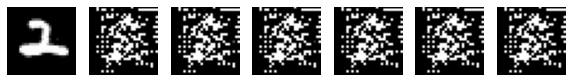

Epoch 5731 g_loss= 6.9856954 d_loss= 0.0009420754 real_acc= 1.0 fake_acc= 1.0
Epoch 5732 g_loss= 7.0236754 d_loss= 0.0009129997 real_acc= 1.0 fake_acc= 1.0
Epoch 5733 g_loss= 7.023938 d_loss= 0.0009135123 real_acc= 1.0 fake_acc= 1.0
Epoch 5734 g_loss= 6.9932876 d_loss= 0.00094538403 real_acc= 1.0 fake_acc= 1.0
Epoch 5735 g_loss= 6.963728 d_loss= 0.00096755265 real_acc= 1.0 fake_acc= 1.0
Epoch 5736 g_loss= 7.065792 d_loss= 0.0008754183 real_acc= 1.0 fake_acc= 1.0
Epoch 5737 g_loss= 6.991231 d_loss= 0.0009449204 real_acc= 1.0 fake_acc= 1.0
Epoch 5738 g_loss= 7.0147414 d_loss= 0.0009161984 real_acc= 1.0 fake_acc= 1.0
Epoch 5739 g_loss= 6.998291 d_loss= 0.00092927745 real_acc= 1.0 fake_acc= 1.0
Epoch 5740 g_loss= 7.0146456 d_loss= 0.00092170766 real_acc= 1.0 fake_acc= 1.0


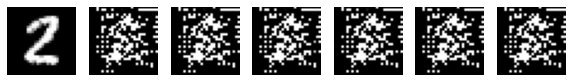

Epoch 5741 g_loss= 7.0176864 d_loss= 0.0009233728 real_acc= 1.0 fake_acc= 1.0
Epoch 5742 g_loss= 7.0626163 d_loss= 0.00087522366 real_acc= 1.0 fake_acc= 1.0
Epoch 5743 g_loss= 7.0410285 d_loss= 0.0008941548 real_acc= 1.0 fake_acc= 1.0
Epoch 5744 g_loss= 7.002379 d_loss= 0.00092859304 real_acc= 1.0 fake_acc= 1.0
Epoch 5745 g_loss= 7.099124 d_loss= 0.00084257626 real_acc= 1.0 fake_acc= 1.0
Epoch 5746 g_loss= 7.0401726 d_loss= 0.00090221764 real_acc= 1.0 fake_acc= 1.0
Epoch 5747 g_loss= 7.064654 d_loss= 0.0008679816 real_acc= 1.0 fake_acc= 1.0
Epoch 5748 g_loss= 7.0395775 d_loss= 0.00089480705 real_acc= 1.0 fake_acc= 1.0
Epoch 5749 g_loss= 7.075491 d_loss= 0.0008664628 real_acc= 1.0 fake_acc= 1.0
Epoch 5750 g_loss= 6.9941454 d_loss= 0.0009405424 real_acc= 1.0 fake_acc= 1.0


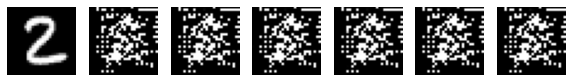

Epoch 5751 g_loss= 7.0734844 d_loss= 0.0008627538 real_acc= 1.0 fake_acc= 1.0
Epoch 5752 g_loss= 7.0438623 d_loss= 0.0008927401 real_acc= 1.0 fake_acc= 1.0
Epoch 5753 g_loss= 7.0204897 d_loss= 0.0009121153 real_acc= 1.0 fake_acc= 1.0
Epoch 5754 g_loss= 7.0522766 d_loss= 0.0008822237 real_acc= 1.0 fake_acc= 1.0
Epoch 5755 g_loss= 7.0144367 d_loss= 0.00091907906 real_acc= 1.0 fake_acc= 1.0
Epoch 5756 g_loss= 7.0819187 d_loss= 0.000860431 real_acc= 1.0 fake_acc= 1.0
Epoch 5757 g_loss= 7.0451374 d_loss= 0.0008867688 real_acc= 1.0 fake_acc= 1.0
Epoch 5758 g_loss= 7.064362 d_loss= 0.00087852374 real_acc= 1.0 fake_acc= 1.0
Epoch 5759 g_loss= 7.0366 d_loss= 0.0008955198 real_acc= 1.0 fake_acc= 1.0
Epoch 5760 g_loss= 7.00235 d_loss= 0.00092397653 real_acc= 1.0 fake_acc= 1.0


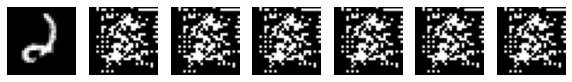

Epoch 5761 g_loss= 7.085452 d_loss= 0.0008545215 real_acc= 1.0 fake_acc= 1.0
Epoch 5762 g_loss= 7.0646815 d_loss= 0.0008709554 real_acc= 1.0 fake_acc= 1.0
Epoch 5763 g_loss= 7.054064 d_loss= 0.000887166 real_acc= 1.0 fake_acc= 1.0
Epoch 5764 g_loss= 7.0567775 d_loss= 0.00088206836 real_acc= 1.0 fake_acc= 1.0
Epoch 5765 g_loss= 7.059754 d_loss= 0.0008847323 real_acc= 1.0 fake_acc= 1.0
Epoch 5766 g_loss= 7.095078 d_loss= 0.00084610836 real_acc= 1.0 fake_acc= 1.0
Epoch 5767 g_loss= 7.0891633 d_loss= 0.00085122994 real_acc= 1.0 fake_acc= 1.0
Epoch 5768 g_loss= 7.0570693 d_loss= 0.0008775488 real_acc= 1.0 fake_acc= 1.0
Epoch 5769 g_loss= 7.0729675 d_loss= 0.0008627478 real_acc= 1.0 fake_acc= 1.0
Epoch 5770 g_loss= 7.0587068 d_loss= 0.00087879034 real_acc= 1.0 fake_acc= 1.0


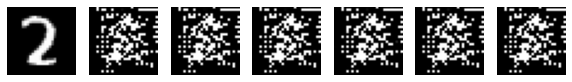

Epoch 5771 g_loss= 7.0689464 d_loss= 0.00086678483 real_acc= 1.0 fake_acc= 1.0
Epoch 5772 g_loss= 7.0958323 d_loss= 0.0008433973 real_acc= 1.0 fake_acc= 1.0
Epoch 5773 g_loss= 7.050179 d_loss= 0.0008930494 real_acc= 1.0 fake_acc= 1.0
Epoch 5774 g_loss= 7.083914 d_loss= 0.0008521093 real_acc= 1.0 fake_acc= 1.0
Epoch 5775 g_loss= 7.0926604 d_loss= 0.00084852154 real_acc= 1.0 fake_acc= 1.0
Epoch 5776 g_loss= 7.1406713 d_loss= 0.000805916 real_acc= 1.0 fake_acc= 1.0
Epoch 5777 g_loss= 7.0696254 d_loss= 0.00086889503 real_acc= 1.0 fake_acc= 1.0
Epoch 5778 g_loss= 7.122738 d_loss= 0.00082361186 real_acc= 1.0 fake_acc= 1.0
Epoch 5779 g_loss= 7.149883 d_loss= 0.0008002277 real_acc= 1.0 fake_acc= 1.0
Epoch 5780 g_loss= 7.1046405 d_loss= 0.0008351227 real_acc= 1.0 fake_acc= 1.0


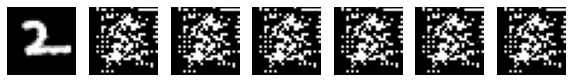

Epoch 5781 g_loss= 7.0967784 d_loss= 0.00084380613 real_acc= 1.0 fake_acc= 1.0
Epoch 5782 g_loss= 7.0668654 d_loss= 0.0008705475 real_acc= 1.0 fake_acc= 1.0
Epoch 5783 g_loss= 7.107082 d_loss= 0.0008387626 real_acc= 1.0 fake_acc= 1.0
Epoch 5784 g_loss= 7.080496 d_loss= 0.00085759244 real_acc= 1.0 fake_acc= 1.0
Epoch 5785 g_loss= 7.1235795 d_loss= 0.0008298135 real_acc= 1.0 fake_acc= 1.0
Epoch 5786 g_loss= 7.162225 d_loss= 0.000789228 real_acc= 1.0 fake_acc= 1.0
Epoch 5787 g_loss= 7.0822496 d_loss= 0.000858072 real_acc= 1.0 fake_acc= 1.0
Epoch 5788 g_loss= 7.1300917 d_loss= 0.00081834913 real_acc= 1.0 fake_acc= 1.0
Epoch 5789 g_loss= 7.149244 d_loss= 0.00080089 real_acc= 1.0 fake_acc= 1.0
Epoch 5790 g_loss= 7.1011543 d_loss= 0.0008393545 real_acc= 1.0 fake_acc= 1.0


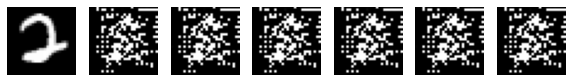

Epoch 5791 g_loss= 7.1505475 d_loss= 0.00080660917 real_acc= 1.0 fake_acc= 1.0
Epoch 5792 g_loss= 7.1502037 d_loss= 0.00079893233 real_acc= 1.0 fake_acc= 1.0
Epoch 5793 g_loss= 7.1315346 d_loss= 0.00081776985 real_acc= 1.0 fake_acc= 1.0
Epoch 5794 g_loss= 7.1066823 d_loss= 0.0008363448 real_acc= 1.0 fake_acc= 1.0
Epoch 5795 g_loss= 7.1846504 d_loss= 0.00077280914 real_acc= 1.0 fake_acc= 1.0
Epoch 5796 g_loss= 7.127967 d_loss= 0.00081956974 real_acc= 1.0 fake_acc= 1.0
Epoch 5797 g_loss= 7.1867723 d_loss= 0.000771486 real_acc= 1.0 fake_acc= 1.0
Epoch 5798 g_loss= 7.167219 d_loss= 0.00078801496 real_acc= 1.0 fake_acc= 1.0
Epoch 5799 g_loss= 7.1429067 d_loss= 0.0008011176 real_acc= 1.0 fake_acc= 1.0
Epoch 5800 g_loss= 7.159674 d_loss= 0.0007963051 real_acc= 1.0 fake_acc= 1.0


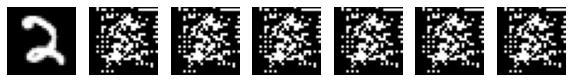

Epoch 5801 g_loss= 7.204125 d_loss= 0.0007561571 real_acc= 1.0 fake_acc= 1.0
Epoch 5802 g_loss= 7.115696 d_loss= 0.0008323736 real_acc= 1.0 fake_acc= 1.0
Epoch 5803 g_loss= 7.1283817 d_loss= 0.0008201582 real_acc= 1.0 fake_acc= 1.0
Epoch 5804 g_loss= 7.1527257 d_loss= 0.0007993009 real_acc= 1.0 fake_acc= 1.0
Epoch 5805 g_loss= 7.1503477 d_loss= 0.0007999008 real_acc= 1.0 fake_acc= 1.0
Epoch 5806 g_loss= 7.1480384 d_loss= 0.0007975977 real_acc= 1.0 fake_acc= 1.0
Epoch 5807 g_loss= 7.140148 d_loss= 0.0008094419 real_acc= 1.0 fake_acc= 1.0
Epoch 5808 g_loss= 7.1287923 d_loss= 0.0008170221 real_acc= 1.0 fake_acc= 1.0
Epoch 5809 g_loss= 7.15992 d_loss= 0.00079945364 real_acc= 1.0 fake_acc= 1.0
Epoch 5810 g_loss= 7.1604724 d_loss= 0.0007925888 real_acc= 1.0 fake_acc= 1.0


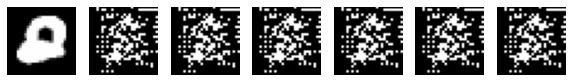

Epoch 5811 g_loss= 7.1586237 d_loss= 0.00079615327 real_acc= 1.0 fake_acc= 1.0
Epoch 5812 g_loss= 7.179359 d_loss= 0.00077642425 real_acc= 1.0 fake_acc= 1.0
Epoch 5813 g_loss= 7.1605816 d_loss= 0.00079359417 real_acc= 1.0 fake_acc= 1.0
Epoch 5814 g_loss= 7.192903 d_loss= 0.00090399967 real_acc= 1.0 fake_acc= 1.0
Epoch 5815 g_loss= 7.148514 d_loss= 0.0008036119 real_acc= 1.0 fake_acc= 1.0
Epoch 5816 g_loss= 7.14854 d_loss= 0.0008029716 real_acc= 1.0 fake_acc= 1.0
Epoch 5817 g_loss= 7.2099843 d_loss= 0.0007557893 real_acc= 1.0 fake_acc= 1.0
Epoch 5818 g_loss= 7.1781306 d_loss= 0.000780533 real_acc= 1.0 fake_acc= 1.0
Epoch 5819 g_loss= 7.1713758 d_loss= 0.000784618 real_acc= 1.0 fake_acc= 1.0
Epoch 5820 g_loss= 7.159792 d_loss= 0.00079603656 real_acc= 1.0 fake_acc= 1.0


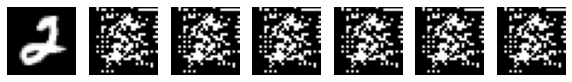

Epoch 5821 g_loss= 7.18472 d_loss= 0.00077317434 real_acc= 1.0 fake_acc= 1.0
Epoch 5822 g_loss= 7.132551 d_loss= 0.0008248829 real_acc= 1.0 fake_acc= 1.0
Epoch 5823 g_loss= 7.139092 d_loss= 0.0008074032 real_acc= 1.0 fake_acc= 1.0
Epoch 5824 g_loss= 7.1989923 d_loss= 0.0007673973 real_acc= 1.0 fake_acc= 1.0
Epoch 5825 g_loss= 7.2069874 d_loss= 0.0007601995 real_acc= 1.0 fake_acc= 1.0
Epoch 5826 g_loss= 7.251866 d_loss= 0.0007294752 real_acc= 1.0 fake_acc= 1.0
Epoch 5827 g_loss= 7.158499 d_loss= 0.00079587556 real_acc= 1.0 fake_acc= 1.0
Epoch 5828 g_loss= 7.2339935 d_loss= 0.00073565246 real_acc= 1.0 fake_acc= 1.0
Epoch 5829 g_loss= 7.17067 d_loss= 0.0007831737 real_acc= 1.0 fake_acc= 1.0
Epoch 5830 g_loss= 7.203178 d_loss= 0.0007620856 real_acc= 1.0 fake_acc= 1.0


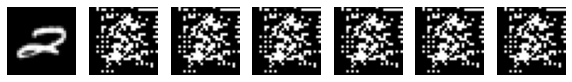

Epoch 5831 g_loss= 7.203193 d_loss= 0.00076186063 real_acc= 1.0 fake_acc= 1.0
Epoch 5832 g_loss= 7.2302523 d_loss= 0.0007438682 real_acc= 1.0 fake_acc= 1.0
Epoch 5833 g_loss= 7.166507 d_loss= 0.0007872216 real_acc= 1.0 fake_acc= 1.0
Epoch 5834 g_loss= 7.1860185 d_loss= 0.00077100354 real_acc= 1.0 fake_acc= 1.0
Epoch 5835 g_loss= 7.1600566 d_loss= 0.0007993047 real_acc= 1.0 fake_acc= 1.0
Epoch 5836 g_loss= 7.178779 d_loss= 0.0007783726 real_acc= 1.0 fake_acc= 1.0
Epoch 5837 g_loss= 7.218342 d_loss= 0.0007564053 real_acc= 1.0 fake_acc= 1.0
Epoch 5838 g_loss= 7.212082 d_loss= 0.021846838 real_acc= 0.98 fake_acc= 1.0
Epoch 5839 g_loss= 7.1495423 d_loss= 0.00080336374 real_acc= 1.0 fake_acc= 1.0
Epoch 5840 g_loss= 7.0551066 d_loss= 0.00088177813 real_acc= 1.0 fake_acc= 1.0


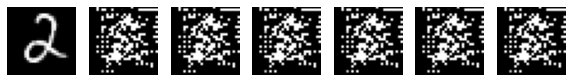

Epoch 5841 g_loss= 6.995507 d_loss= 0.0009410234 real_acc= 1.0 fake_acc= 1.0
Epoch 5842 g_loss= 6.9380326 d_loss= 0.000991913 real_acc= 1.0 fake_acc= 1.0
Epoch 5843 g_loss= 6.872677 d_loss= 0.0010524757 real_acc= 1.0 fake_acc= 1.0
Epoch 5844 g_loss= 6.858015 d_loss= 0.0010678663 real_acc= 1.0 fake_acc= 1.0
Epoch 5845 g_loss= 6.7516236 d_loss= 0.0011880931 real_acc= 1.0 fake_acc= 1.0
Epoch 5846 g_loss= 6.716682 d_loss= 0.0012318706 real_acc= 1.0 fake_acc= 1.0
Epoch 5847 g_loss= 6.726532 d_loss= 0.001223902 real_acc= 1.0 fake_acc= 1.0
Epoch 5848 g_loss= 6.700762 d_loss= 0.0012579752 real_acc= 1.0 fake_acc= 1.0
Epoch 5849 g_loss= 6.70094 d_loss= 0.0012519701 real_acc= 1.0 fake_acc= 1.0
Epoch 5850 g_loss= 6.631006 d_loss= 0.001337874 real_acc= 1.0 fake_acc= 1.0


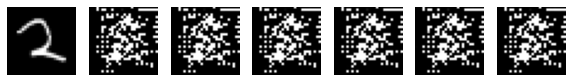

Epoch 5851 g_loss= 6.5643115 d_loss= 0.0014434899 real_acc= 1.0 fake_acc= 1.0
Epoch 5852 g_loss= 6.6081343 d_loss= 0.0013687845 real_acc= 1.0 fake_acc= 1.0
Epoch 5853 g_loss= 6.573235 d_loss= 0.0014229038 real_acc= 1.0 fake_acc= 1.0
Epoch 5854 g_loss= 6.551793 d_loss= 0.0014622739 real_acc= 1.0 fake_acc= 1.0
Epoch 5855 g_loss= 6.5086174 d_loss= 0.0015110852 real_acc= 1.0 fake_acc= 1.0
Epoch 5856 g_loss= 6.4835553 d_loss= 0.001560937 real_acc= 1.0 fake_acc= 1.0
Epoch 5857 g_loss= 6.4761868 d_loss= 0.0015755292 real_acc= 1.0 fake_acc= 1.0
Epoch 5858 g_loss= 6.4399133 d_loss= 0.001627093 real_acc= 1.0 fake_acc= 1.0
Epoch 5859 g_loss= 6.4890075 d_loss= 0.0015634203 real_acc= 1.0 fake_acc= 1.0
Epoch 5860 g_loss= 6.4978943 d_loss= 0.0015388008 real_acc= 1.0 fake_acc= 1.0


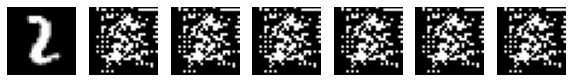

Epoch 5861 g_loss= 6.4232183 d_loss= 0.001658125 real_acc= 1.0 fake_acc= 1.0
Epoch 5862 g_loss= 6.474132 d_loss= 0.0015644385 real_acc= 1.0 fake_acc= 1.0
Epoch 5863 g_loss= 6.4705286 d_loss= 0.0015865233 real_acc= 1.0 fake_acc= 1.0
Epoch 5864 g_loss= 6.4669456 d_loss= 0.0015837593 real_acc= 1.0 fake_acc= 1.0
Epoch 5865 g_loss= 6.426034 d_loss= 0.0016607095 real_acc= 1.0 fake_acc= 1.0
Epoch 5866 g_loss= 6.473912 d_loss= 0.0015782479 real_acc= 1.0 fake_acc= 1.0
Epoch 5867 g_loss= 6.4121537 d_loss= 0.0016591835 real_acc= 1.0 fake_acc= 1.0
Epoch 5868 g_loss= 6.4514036 d_loss= 0.0016186542 real_acc= 1.0 fake_acc= 1.0
Epoch 5869 g_loss= 6.4140563 d_loss= 0.0016690138 real_acc= 1.0 fake_acc= 1.0
Epoch 5870 g_loss= 6.462548 d_loss= 0.001589821 real_acc= 1.0 fake_acc= 1.0


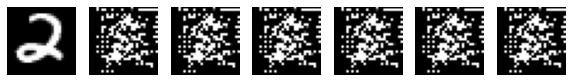

Epoch 5871 g_loss= 6.4225197 d_loss= 0.0016579214 real_acc= 1.0 fake_acc= 1.0
Epoch 5872 g_loss= 6.427671 d_loss= 0.0016380656 real_acc= 1.0 fake_acc= 1.0
Epoch 5873 g_loss= 6.392413 d_loss= 0.0017015047 real_acc= 1.0 fake_acc= 1.0
Epoch 5874 g_loss= 6.4118633 d_loss= 0.0016697207 real_acc= 1.0 fake_acc= 1.0
Epoch 5875 g_loss= 6.345993 d_loss= 0.0017748155 real_acc= 1.0 fake_acc= 1.0
Epoch 5876 g_loss= 6.45553 d_loss= 0.0016077633 real_acc= 1.0 fake_acc= 1.0
Epoch 5877 g_loss= 6.426581 d_loss= 0.0016616673 real_acc= 1.0 fake_acc= 1.0
Epoch 5878 g_loss= 6.3774953 d_loss= 0.0017356208 real_acc= 1.0 fake_acc= 1.0
Epoch 5879 g_loss= 6.365684 d_loss= 0.0017720206 real_acc= 1.0 fake_acc= 1.0
Epoch 5880 g_loss= 6.3445644 d_loss= 0.0017819457 real_acc= 1.0 fake_acc= 1.0


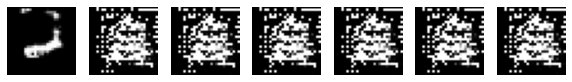

Epoch 5881 g_loss= 6.3765736 d_loss= 0.0017254399 real_acc= 1.0 fake_acc= 1.0
Epoch 5882 g_loss= 6.4316883 d_loss= 0.0016409584 real_acc= 1.0 fake_acc= 1.0
Epoch 5883 g_loss= 6.3990626 d_loss= 0.0017153333 real_acc= 1.0 fake_acc= 1.0
Epoch 5884 g_loss= 6.3421397 d_loss= 0.0017943567 real_acc= 1.0 fake_acc= 1.0
Epoch 5885 g_loss= 6.3190923 d_loss= 0.001846793 real_acc= 1.0 fake_acc= 1.0
Epoch 5886 g_loss= 6.3031316 d_loss= 0.001856526 real_acc= 1.0 fake_acc= 1.0
Epoch 5887 g_loss= 6.3854136 d_loss= 0.0017211945 real_acc= 1.0 fake_acc= 1.0
Epoch 5888 g_loss= 6.3211555 d_loss= 0.0018353707 real_acc= 1.0 fake_acc= 1.0
Epoch 5889 g_loss= 6.2969947 d_loss= 0.0018747955 real_acc= 1.0 fake_acc= 1.0
Epoch 5890 g_loss= 6.3442626 d_loss= 0.0017869804 real_acc= 1.0 fake_acc= 1.0


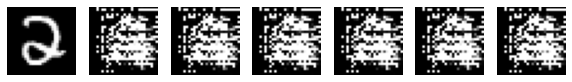

Epoch 5891 g_loss= 6.392367 d_loss= 0.0017125511 real_acc= 1.0 fake_acc= 1.0
Epoch 5892 g_loss= 6.3116755 d_loss= 0.0018495406 real_acc= 1.0 fake_acc= 1.0
Epoch 5893 g_loss= 6.302083 d_loss= 0.001871512 real_acc= 1.0 fake_acc= 1.0
Epoch 5894 g_loss= 6.342562 d_loss= 0.0017937794 real_acc= 1.0 fake_acc= 1.0
Epoch 5895 g_loss= 6.2906938 d_loss= 0.0018837993 real_acc= 1.0 fake_acc= 1.0
Epoch 5896 g_loss= 6.3206434 d_loss= 0.0018331482 real_acc= 1.0 fake_acc= 1.0
Epoch 5897 g_loss= 6.297641 d_loss= 0.0018712066 real_acc= 1.0 fake_acc= 1.0
Epoch 5898 g_loss= 6.26804 d_loss= 0.0019415535 real_acc= 1.0 fake_acc= 1.0
Epoch 5899 g_loss= 6.304143 d_loss= 0.0018723017 real_acc= 1.0 fake_acc= 1.0
Epoch 5900 g_loss= 6.2772174 d_loss= 0.0019052604 real_acc= 1.0 fake_acc= 1.0


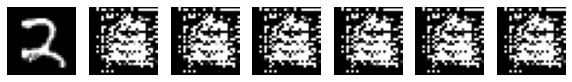

Epoch 5901 g_loss= 6.363065 d_loss= 0.0017560399 real_acc= 1.0 fake_acc= 1.0
Epoch 5902 g_loss= 6.3421907 d_loss= 0.001797817 real_acc= 1.0 fake_acc= 1.0
Epoch 5903 g_loss= 6.357618 d_loss= 0.001754967 real_acc= 1.0 fake_acc= 1.0
Epoch 5904 g_loss= 6.3624043 d_loss= 0.0017597921 real_acc= 1.0 fake_acc= 1.0
Epoch 5905 g_loss= 6.311175 d_loss= 0.0018474945 real_acc= 1.0 fake_acc= 1.0
Epoch 5906 g_loss= 6.349808 d_loss= 0.0017801437 real_acc= 1.0 fake_acc= 1.0
Epoch 5907 g_loss= 6.3053246 d_loss= 0.0018565428 real_acc= 1.0 fake_acc= 1.0
Epoch 5908 g_loss= 6.2423854 d_loss= 0.0019814388 real_acc= 1.0 fake_acc= 1.0
Epoch 5909 g_loss= 6.279388 d_loss= 0.0019021273 real_acc= 1.0 fake_acc= 1.0
Epoch 5910 g_loss= 6.306033 d_loss= 0.0018558754 real_acc= 1.0 fake_acc= 1.0


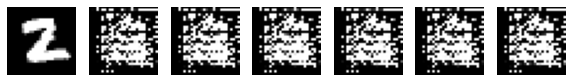

Epoch 5911 g_loss= 6.274368 d_loss= 0.0019177069 real_acc= 1.0 fake_acc= 1.0
Epoch 5912 g_loss= 6.3612695 d_loss= 0.0017539808 real_acc= 1.0 fake_acc= 1.0
Epoch 5913 g_loss= 6.311105 d_loss= 0.0018520532 real_acc= 1.0 fake_acc= 1.0
Epoch 5914 g_loss= 6.3395715 d_loss= 0.0017964344 real_acc= 1.0 fake_acc= 1.0
Epoch 5915 g_loss= 6.3519506 d_loss= 0.0017856518 real_acc= 1.0 fake_acc= 1.0
Epoch 5916 g_loss= 6.336982 d_loss= 0.0018022903 real_acc= 1.0 fake_acc= 1.0
Epoch 5917 g_loss= 6.3451037 d_loss= 0.0017849639 real_acc= 1.0 fake_acc= 1.0
Epoch 5918 g_loss= 6.311122 d_loss= 0.0018515638 real_acc= 1.0 fake_acc= 1.0
Epoch 5919 g_loss= 6.3003674 d_loss= 0.0018713932 real_acc= 1.0 fake_acc= 1.0
Epoch 5920 g_loss= 6.357788 d_loss= 0.001762176 real_acc= 1.0 fake_acc= 1.0


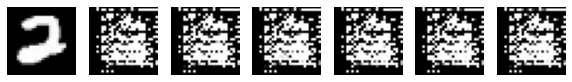

Epoch 5921 g_loss= 6.3510914 d_loss= 0.0017764253 real_acc= 1.0 fake_acc= 1.0
Epoch 5922 g_loss= 6.296956 d_loss= 0.0018905783 real_acc= 1.0 fake_acc= 1.0
Epoch 5923 g_loss= 6.338841 d_loss= 0.0017989809 real_acc= 1.0 fake_acc= 1.0
Epoch 5924 g_loss= 6.3382683 d_loss= 0.0017942971 real_acc= 1.0 fake_acc= 1.0
Epoch 5925 g_loss= 6.371519 d_loss= 0.0017458855 real_acc= 1.0 fake_acc= 1.0
Epoch 5926 g_loss= 6.355614 d_loss= 0.0017686236 real_acc= 1.0 fake_acc= 1.0
Epoch 5927 g_loss= 6.342668 d_loss= 0.0018025928 real_acc= 1.0 fake_acc= 1.0
Epoch 5928 g_loss= 6.327971 d_loss= 0.0018229282 real_acc= 1.0 fake_acc= 1.0
Epoch 5929 g_loss= 6.3710766 d_loss= 0.0017456531 real_acc= 1.0 fake_acc= 1.0
Epoch 5930 g_loss= 6.351222 d_loss= 0.0017845253 real_acc= 1.0 fake_acc= 1.0


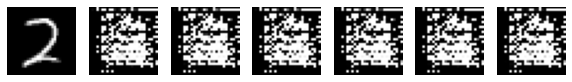

Epoch 5931 g_loss= 6.3685875 d_loss= 0.0017422576 real_acc= 1.0 fake_acc= 1.0
Epoch 5932 g_loss= 6.375238 d_loss= 0.0017449879 real_acc= 1.0 fake_acc= 1.0
Epoch 5933 g_loss= 6.3387294 d_loss= 0.0018028053 real_acc= 1.0 fake_acc= 1.0
Epoch 5934 g_loss= 6.3656282 d_loss= 0.0017594285 real_acc= 1.0 fake_acc= 1.0
Epoch 5935 g_loss= 6.376304 d_loss= 0.0017497401 real_acc= 1.0 fake_acc= 1.0
Epoch 5936 g_loss= 6.3487196 d_loss= 0.0018017961 real_acc= 1.0 fake_acc= 1.0
Epoch 5937 g_loss= 6.338172 d_loss= 0.0018044026 real_acc= 1.0 fake_acc= 1.0
Epoch 5938 g_loss= 6.3633137 d_loss= 0.0017750562 real_acc= 1.0 fake_acc= 1.0
Epoch 5939 g_loss= 6.382208 d_loss= 0.001715892 real_acc= 1.0 fake_acc= 1.0
Epoch 5940 g_loss= 6.406304 d_loss= 0.001672575 real_acc= 1.0 fake_acc= 1.0


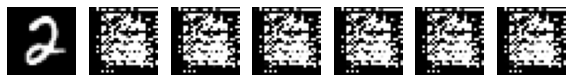

Epoch 5941 g_loss= 6.4094763 d_loss= 0.0016896707 real_acc= 1.0 fake_acc= 1.0
Epoch 5942 g_loss= 6.3933177 d_loss= 0.0017011887 real_acc= 1.0 fake_acc= 1.0
Epoch 5943 g_loss= 6.341278 d_loss= 0.0018048971 real_acc= 1.0 fake_acc= 1.0
Epoch 5944 g_loss= 6.4060693 d_loss= 0.0016775801 real_acc= 1.0 fake_acc= 1.0
Epoch 5945 g_loss= 6.361574 d_loss= 0.0017618792 real_acc= 1.0 fake_acc= 1.0
Epoch 5946 g_loss= 6.3902154 d_loss= 0.0017129693 real_acc= 1.0 fake_acc= 1.0
Epoch 5947 g_loss= 6.4077816 d_loss= 0.0016863492 real_acc= 1.0 fake_acc= 1.0
Epoch 5948 g_loss= 6.361788 d_loss= 0.0017585127 real_acc= 1.0 fake_acc= 1.0
Epoch 5949 g_loss= 6.3591237 d_loss= 0.0017577538 real_acc= 1.0 fake_acc= 1.0
Epoch 5950 g_loss= 6.3665733 d_loss= 0.0017505314 real_acc= 1.0 fake_acc= 1.0


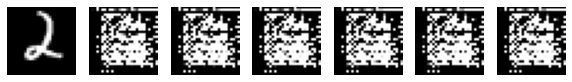

Epoch 5951 g_loss= 6.4241347 d_loss= 0.0016489057 real_acc= 1.0 fake_acc= 1.0
Epoch 5952 g_loss= 6.4263105 d_loss= 0.0016611768 real_acc= 1.0 fake_acc= 1.0
Epoch 5953 g_loss= 6.358773 d_loss= 0.0017705128 real_acc= 1.0 fake_acc= 1.0
Epoch 5954 g_loss= 6.483286 d_loss= 0.0015529474 real_acc= 1.0 fake_acc= 1.0
Epoch 5955 g_loss= 6.408271 d_loss= 0.0016824278 real_acc= 1.0 fake_acc= 1.0
Epoch 5956 g_loss= 6.434668 d_loss= 0.0016379585 real_acc= 1.0 fake_acc= 1.0
Epoch 5957 g_loss= 6.388026 d_loss= 0.0017092382 real_acc= 1.0 fake_acc= 1.0
Epoch 5958 g_loss= 6.40907 d_loss= 0.0016872704 real_acc= 1.0 fake_acc= 1.0
Epoch 5959 g_loss= 6.4200816 d_loss= 0.0016560794 real_acc= 1.0 fake_acc= 1.0
Epoch 5960 g_loss= 6.4195123 d_loss= 0.0016712019 real_acc= 1.0 fake_acc= 1.0


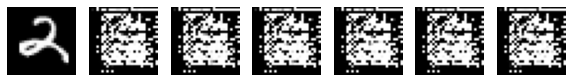

Epoch 5961 g_loss= 6.440238 d_loss= 0.0016157705 real_acc= 1.0 fake_acc= 1.0
Epoch 5962 g_loss= 6.4444637 d_loss= 0.0016121942 real_acc= 1.0 fake_acc= 1.0
Epoch 5963 g_loss= 6.4940324 d_loss= 0.0015344478 real_acc= 1.0 fake_acc= 1.0
Epoch 5964 g_loss= 6.462063 d_loss= 0.0016128799 real_acc= 1.0 fake_acc= 1.0
Epoch 5965 g_loss= 6.4678016 d_loss= 0.0015901123 real_acc= 1.0 fake_acc= 1.0
Epoch 5966 g_loss= 6.453404 d_loss= 0.0016016144 real_acc= 1.0 fake_acc= 1.0
Epoch 5967 g_loss= 6.442252 d_loss= 0.0016290102 real_acc= 1.0 fake_acc= 1.0
Epoch 5968 g_loss= 6.482919 d_loss= 0.0015609291 real_acc= 1.0 fake_acc= 1.0
Epoch 5969 g_loss= 6.5217 d_loss= 0.0014954901 real_acc= 1.0 fake_acc= 1.0
Epoch 5970 g_loss= 6.4377594 d_loss= 0.001632723 real_acc= 1.0 fake_acc= 1.0


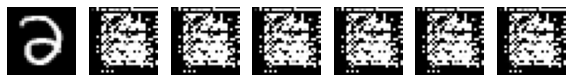

Epoch 5971 g_loss= 6.506491 d_loss= 0.0015391427 real_acc= 1.0 fake_acc= 1.0
Epoch 5972 g_loss= 6.5070634 d_loss= 0.0015331517 real_acc= 1.0 fake_acc= 1.0
Epoch 5973 g_loss= 6.4729633 d_loss= 0.00157624 real_acc= 1.0 fake_acc= 1.0
Epoch 5974 g_loss= 6.4930143 d_loss= 0.0015532025 real_acc= 1.0 fake_acc= 1.0
Epoch 5975 g_loss= 6.481973 d_loss= 0.0015555588 real_acc= 1.0 fake_acc= 1.0
Epoch 5976 g_loss= 6.493117 d_loss= 0.0015474036 real_acc= 1.0 fake_acc= 1.0
Epoch 5977 g_loss= 6.5659194 d_loss= 0.0014339025 real_acc= 1.0 fake_acc= 1.0
Epoch 5978 g_loss= 6.558295 d_loss= 0.001450312 real_acc= 1.0 fake_acc= 1.0
Epoch 5979 g_loss= 6.472506 d_loss= 0.0015789091 real_acc= 1.0 fake_acc= 1.0
Epoch 5980 g_loss= 6.5093493 d_loss= 0.0015216129 real_acc= 1.0 fake_acc= 1.0


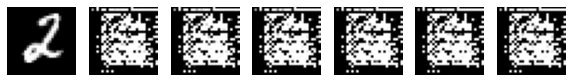

Epoch 5981 g_loss= 6.5290446 d_loss= 0.0014916424 real_acc= 1.0 fake_acc= 1.0
Epoch 5982 g_loss= 6.5500536 d_loss= 0.0014620839 real_acc= 1.0 fake_acc= 1.0
Epoch 5983 g_loss= 6.57256 d_loss= 0.0014216355 real_acc= 1.0 fake_acc= 1.0
Epoch 5984 g_loss= 6.55006 d_loss= 0.0014475514 real_acc= 1.0 fake_acc= 1.0
Epoch 5985 g_loss= 6.59855 d_loss= 0.0013846116 real_acc= 1.0 fake_acc= 1.0
Epoch 5986 g_loss= 6.518223 d_loss= 0.0015123567 real_acc= 1.0 fake_acc= 1.0
Epoch 5987 g_loss= 6.529873 d_loss= 0.0014935681 real_acc= 1.0 fake_acc= 1.0
Epoch 5988 g_loss= 6.597257 d_loss= 0.0013850182 real_acc= 1.0 fake_acc= 1.0
Epoch 5989 g_loss= 6.526335 d_loss= 0.0014953272 real_acc= 1.0 fake_acc= 1.0
Epoch 5990 g_loss= 6.5780725 d_loss= 0.0014206604 real_acc= 1.0 fake_acc= 1.0


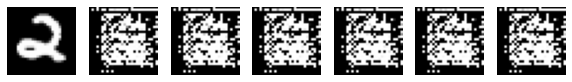

Epoch 5991 g_loss= 6.5821743 d_loss= 0.0014291276 real_acc= 1.0 fake_acc= 1.0
Epoch 5992 g_loss= 6.517718 d_loss= 0.0014994069 real_acc= 1.0 fake_acc= 1.0
Epoch 5993 g_loss= 6.6037765 d_loss= 0.001394201 real_acc= 1.0 fake_acc= 1.0
Epoch 5994 g_loss= 6.581423 d_loss= 0.001419051 real_acc= 1.0 fake_acc= 1.0
Epoch 5995 g_loss= 6.598254 d_loss= 0.001393124 real_acc= 1.0 fake_acc= 1.0
Epoch 5996 g_loss= 6.5384383 d_loss= 0.001470515 real_acc= 1.0 fake_acc= 1.0
Epoch 5997 g_loss= 6.5846815 d_loss= 0.0014144349 real_acc= 1.0 fake_acc= 1.0
Epoch 5998 g_loss= 6.595191 d_loss= 0.0014054817 real_acc= 1.0 fake_acc= 1.0
Epoch 5999 g_loss= 6.6180754 d_loss= 0.0013596832 real_acc= 1.0 fake_acc= 1.0
Done


In [15]:
epochs = 2000
for epoch in range(epochs):
    new_samples = sample_from_dataset(50,testSamples)
    do_step(new_samples)
    
    if epoch % 10 == 0:
        num_examples_to_generate = 6
        seed = tf.random.normal([num_examples_to_generate, noise_dim])
        predictions = generator(seed, training=False)
        fig = plt.figure(figsize=(10,10))
        r = random.randrange(len(testSamples))
        plt.subplot(1, num_examples_to_generate+1, 1)
        plt.imshow(testSamples[r, :, :] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        for i in range(predictions.shape[0]):
            plt.subplot(1, num_examples_to_generate+1, i+2)
            plt.imshow(predictions[i, :, :, 0], cmap='gray')
            plt.axis('off')
        plt.show()    
print("Done")